### GAN介绍
生成对抗网络（Generative Adversarial Networks，GAN）最早由 Ian Goodfellow 在 2014 年提出，是目前深度学习领域最具潜力的研究成果之一。它的核心思想是：同时训练两个相互协作、同时又相互竞争的深度神经网络（一个称为生成器 Generator，另一个称为判别器 Discriminator）来处理无监督学习的相关问题。  

通常，我们会用下面这个例子来说明 GAN 的原理：将警察视为判别器，制造假币的犯罪分子视为生成器。一开始，犯罪分子会首先向警察展示一张假币。警察识别出该假币，并向犯罪分子反馈哪些地方是假的。接着，根据警察的反馈，犯罪分子改进工艺，制作一张更逼真的假币给警方检查。这时警方再反馈，犯罪分子再改进工艺。不断重复这一过程，直到警察识别不出真假，那么模型就训练成功了。  

GAN的变体非常多，我们就以深度卷积生成对抗网络（Deep Convolutional GAN，DCGAN）为例，自动生成 MNIST 手写体数字。

### 判别器：
输入一张图片，输出一个数值，输入的图像越接近真实图像，该值越接近1。  
判别器的作用是判断一个模型生成的图像和真实图像比，有多逼真。它的基本结构就是如下图所示的卷积神经网络（Convolutional Neural Network，CNN）。对于 MNIST 数据集来说，模型输入是一个 28x28 像素的单通道图像。Sigmoid 函数的输出值在 0-1 之间，表示图像真实度的概率，其中 0 表示肯定是假的，1 表示肯定是真的。与典型的 CNN 结构相比，这里去掉了层之间的 max-pooling。这里每个 CNN 层都以 LeakyReLU 为激活函数。而且为了防止过拟合，层之间的 dropout 值均被设置在 0.4-0.7 之间，模型结构如下：
<center><img src="images/Discriminator.jpg" alt="FAO" width="500"></center> 
ReLU激活函数极为f(x)=alpha * x for x < 0, f(x) = x for x>=0。alpha是一个小的非零数。
<center><img src="images/LeakyRelu.png" alt="FAO" width="200"></center>

### 生成器：
生成器的作用是合成假的图像，其基本机构如下图所示。图中，我们使用了卷积的倒数，即[转置卷积（transposed convolution）](https://github.com/vdumoulin/conv_arithmetic)，从 100 维的噪声（满足 -1 至 1 之间的均匀分布）中生成了假图像。这里我们采用了模型前三层之间的上采样来合成更逼真的手写图像。在层与层之间，我们采用了批量归一化的方法来平稳化训练过程。以 ReLU 函数为每一层结构之后的激活函数。最后一层 Sigmoid 函数输出最后的假图像。第一层设置了 0.3-0.5 之间的 dropout 值来防止过拟合。
<center><img src="images/Generator.jpg" alt="FAO" width="500"></center> 
批量正则化：
<center><img src="images/batch normalization.png" alt="FAO" width="500"></center>

### GAN应用
[1.图像生成](http://make.girls.moe)  
2.向量空间运算
<center><img src="images/GAN1.jpg" alt="FAO" width="500"></center>
3.文本转图像
<center><img src="images/GAN2.jpg" alt="FAO" width="500"></center>
4.超分辨率
<center><img src="images/GAN4.jpg" alt="FAO" width="500"></center>

#### 导入包

In [3]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### 创建模型

In [0]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None    # discriminator 判别器
        self.G =None     # generator 生成器
        self.AM = None   # adversarial model 对抗模型
        self.DM = None   # discriminator model 判别模型
        
    # 定义判别器的网络结构
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64      # 定义kernel数
        dropout = 0.4   # dropout系数
        # 输入大小
        input_shape = (self.img_rows, self.img_cols, self.channel)      # 输入28*28*1
        self.D.add(Conv2D(input_shape=input_shape, filters=depth*1, kernel_size=5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))    # 输出14*14*64    #### 【问题：为啥这层输出就变为14*14*64】：因为步长为2 ####
        
        self.D.add(Conv2D(filters=depth*2, kernel_size=5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))    # 输出7*7*128
        
        self.D.add(Conv2D(filters=depth*4, kernel_size=5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))    # 输出4*4*256
        
        self.D.add(Conv2D(filters=depth*8, kernel_size=5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))    # 输出4*4*512
        
        # 全连接层
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D
    
    # 定义判别模型
    def discriminator_model(self):
        if self.DM:
            return self.DM
        # 定义优化器
        optimizer = RMSprop(lr=0.0002, decay=6e-8)    # decay 学习衰减率
        # 构建模型
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        ## binary_crossentropy 交叉熵损失，一般用于二分类
        return self.DM
    
    # 定义生成器
    def generator(self):
        '''输入100维的噪声数据，最后输出28*28*1，即一张图片'''
        if self.G:
            return self.G
        self.G = Sequential()
        depth = 64*4      # 通道数为256
        dropout = 0.4     # dropout系数
        dim = 7           # 定义初始平面大小
        # 全连接层，输入：100个随机噪声数据，输出：7*7*256个神经网络
        self.G.add(Dense(input_dim=100, units=dim*dim*depth))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        # 把1维的向量变成3维数据(7,7,256)
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        #### 两个上采样(高宽：7-->14-->28)，四个转置卷积(通道数：256-->128-->64-->32-->1) ####
        # 上采样，UpSampling2D(size=(2,2)), 用法与MaxPooling2D相反，扩大一倍，变成(14,14,256)
        self.G.add(UpSampling2D(size=(2,2)))
        # 转置卷积：将提取的特征图还原到原始图像的大小
        self.G.add(Conv2DTranspose(filters=int(depth/2), kernel_size=5, padding='same'))    #### 【问题：为什么不使用卷积】 ####
        ## 转置卷积后，为(14,14,128)
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D(size=(2,2)))    # 上采样，变为28*28*128
        self.G.add(Conv2DTranspose(filters=int(depth/4), kernel_size=5, padding='same'))# 变为28*28*64
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(filters=int(depth/8), kernel_size=5, padding='same'))# 变为28*28*32
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(filters=1, kernel_size=5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G
        
    # 定义对抗模型
    ## 对抗模型的实质就是生成器，为了生成更逼真的图片
    def adversarial_model(self):
        if self.AM:
            return self.AM
        # 定义优化器
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        # 构建模型
        self.AM = Sequential()
        self.AM.add(self.generator())         # 生成器
        self.AM.add(self.discriminator())     # 判别器
        self.AM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        #### 【问题：对抗模型中，如何体现出了只更新生成器模型的参数，不更新判别器的参数】 ####
        return self.AM

In [0]:
class MNIST_DCGAN(object):
    def __init__(self):
        # 图片的行数
        self.img_rows = 28
        # 图片的列数
        self.img_cols = 28
        # 图片的通道数
        self.channel = 1
        
        # 导入数据
        (x_train,y_train), (x_test, y_test) = mnist.load_data()
        self.x_train = x_train / 255.0    # (60000,28,28)
        # 将data转换为4维的
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
        
        # 实例化DCGAN类
        self.DCGAN = DCGAN()
        # 定义判别器模型
        self.discriminator = self.DCGAN.discriminator_model()
        # 定义对抗模型
        self.adversarial = self.DCGAN.adversarial_model()
        # 定义生成模型
        self.generator = self.DCGAN.generator()
    
    # 训练模型
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            # 生成16个100维的噪声数据   ####【问题：这个有什么用处】:测试生成器时输入的噪声数据，在train中没用到 ####
            noise_input = np.random.uniform(-1.0, 1.0, size=[16,100])    
            #### 【问题：[16,100]里的16是什么意思，有什么用处】:指测试模型时是16个噪声数据 ####
        for i in range(train_steps):
        # 训练判别器，提升判断能力
            # 随机得到一个batch的图片数据，在这里是每次取了256张照片出来
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            # 随机生成batch的一个噪声数据
            noise = np.random.randint(-1.0, 1.0, size=[batch_size, 100])
            # 生成伪造的图片数据
            images_fake = self.generator.predict(noise)    #### 【问题：generator没定义predict这个方法呀】 ####
            # 合并一个batch的真实图片和伪造图片
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            # 把数据放入判别器进行判断，进而提升判别器的效果
            d_loss = self.discriminator.train_on_batch(x, y)    #### 【问题：也没有定义train_on_batch这个方法】 ####

        # 训练生成器，提升生成器的造假能力
            # 标签定义为1
            y = np.ones([batch_size, 1])    # y是[256,1]的数据
            # 随机生成一个batch的噪声数据
            noise = np.random.randint(-1.0,1.0, size=[batch_size, 100])
            # 训练对抗模型
            a_loss = self.adversarial.train_on_batch(noise, y)
            # 分别输出判别器和生成器的loss及accuracy
            log_msg = '%d: [D loss:%f, acc:%f]'%(i, d_loss[0], d_loss[1])
            log_msg = '%s [A loss:%f, acc:%f]'%(log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            # 如果需要保存图片
            if save_interval>0:
                # 每save_interval保存一次
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1)) 
                    #### 【问题：noise_input有什么用，该模型一次到底训练多少张图片】:每次train 256张图片，noise_input与train没有关系 ####

    # 保存图片
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = './mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0,1.0,size=[samples,100])
            else:
                # filename = 'mnist_' + str(step) + '.png'
                pass
            # 生成伪造的图片数据
            images = self.generator.predict(noise)    # 通过生成image来查看模型训练的结果
        else:
            # 获取真实图片
            i = np.random.randint(low=0, high=self.x_train.shape[0], size=samples)
            images = self.x_train[i, :, :, :]

        # 设置图片大小
        plt.figure(figsize=(10,10))
        # 生成16张图片
        for i in range(images.shape[0]):
            plt.subplot(4,4,i+1)
            image = images[i,:,:,:]
            # 变成二维的图片
            image = np.reshape(image, [self.img_rows, self.img_cols])
            # 显示灰度图像
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        # 保存图像
        plt.show()    # 这没毛病
        if save2file:
            pass
            # plt.savefig(filename)    # 在colab保存图片出错
            # plt.close('all')
        # 不保存的话就显示图片
        else:
            plt.show()

#####  训练模型

11493376/11490434 [==============================] - 0s 0us/step




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dr

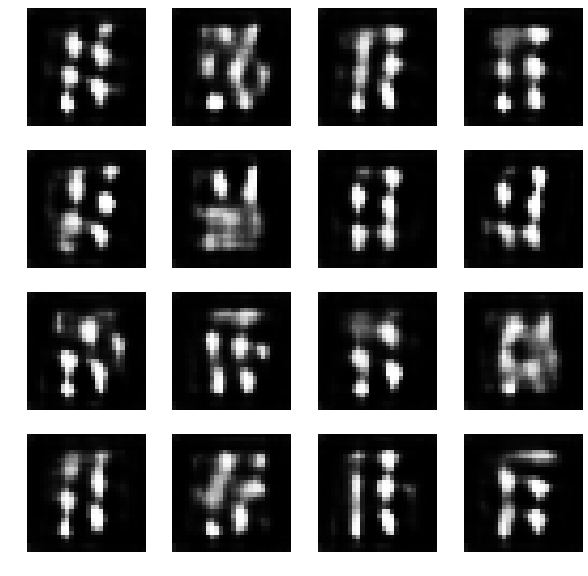

100: [D loss:0.626796, acc:0.521484] [A loss:2.251131, acc:0.000000]
101: [D loss:0.485449, acc:0.839844] [A loss:0.604313, acc:0.695312]
102: [D loss:0.765454, acc:0.500000] [A loss:1.891956, acc:0.000000]
103: [D loss:0.438242, acc:0.921875] [A loss:0.798183, acc:0.308594]
104: [D loss:0.603263, acc:0.515625] [A loss:1.729930, acc:0.000000]
105: [D loss:0.433886, acc:0.904297] [A loss:1.042126, acc:0.031250]
106: [D loss:0.542439, acc:0.570312] [A loss:1.899543, acc:0.000000]
107: [D loss:0.430485, acc:0.898438] [A loss:0.935463, acc:0.140625]
108: [D loss:0.627400, acc:0.515625] [A loss:2.314595, acc:0.000000]
109: [D loss:0.480858, acc:0.832031] [A loss:0.621052, acc:0.707031]
110: [D loss:0.772604, acc:0.500000] [A loss:1.950722, acc:0.000000]
111: [D loss:0.471174, acc:0.884766] [A loss:0.760110, acc:0.363281]
112: [D loss:0.655157, acc:0.505859] [A loss:1.744097, acc:0.000000]
113: [D loss:0.447932, acc:0.910156] [A loss:1.029376, acc:0.066406]
114: [D loss:0.573094, acc:0.54101

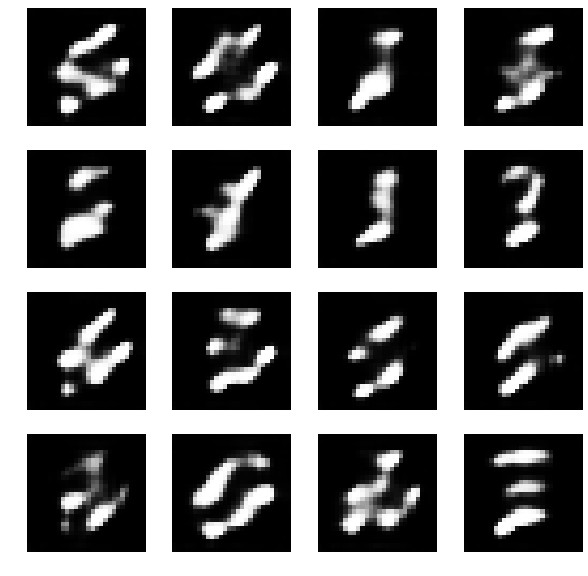

200: [D loss:0.691867, acc:0.503906] [A loss:1.678604, acc:0.000000]
201: [D loss:0.572855, acc:0.748047] [A loss:0.681838, acc:0.550781]
202: [D loss:0.698178, acc:0.515625] [A loss:1.519987, acc:0.000000]
203: [D loss:0.561192, acc:0.787109] [A loss:0.764345, acc:0.371094]
204: [D loss:0.673421, acc:0.521484] [A loss:1.623068, acc:0.000000]
205: [D loss:0.582854, acc:0.757812] [A loss:0.721268, acc:0.476562]
206: [D loss:0.698144, acc:0.517578] [A loss:1.522380, acc:0.000000]
207: [D loss:0.574794, acc:0.757812] [A loss:0.770082, acc:0.378906]
208: [D loss:0.652397, acc:0.535156] [A loss:1.498892, acc:0.000000]
209: [D loss:0.572813, acc:0.775391] [A loss:0.828119, acc:0.289062]
210: [D loss:0.649925, acc:0.531250] [A loss:1.551476, acc:0.000000]
211: [D loss:0.580828, acc:0.753906] [A loss:0.749824, acc:0.414062]
212: [D loss:0.682882, acc:0.529297] [A loss:1.603664, acc:0.000000]
213: [D loss:0.584552, acc:0.738281] [A loss:0.718612, acc:0.468750]
214: [D loss:0.674877, acc:0.51171

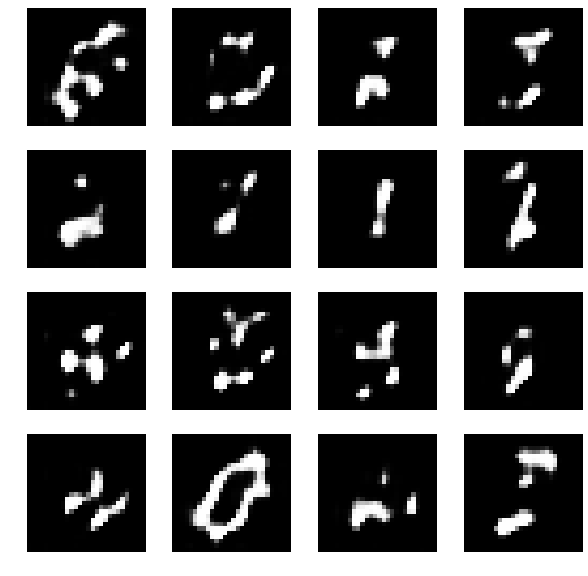

300: [D loss:0.678582, acc:0.535156] [A loss:1.205038, acc:0.007812]
301: [D loss:0.665064, acc:0.615234] [A loss:0.773637, acc:0.367188]
302: [D loss:0.684393, acc:0.535156] [A loss:1.257308, acc:0.000000]
303: [D loss:0.650430, acc:0.611328] [A loss:0.675531, acc:0.605469]
304: [D loss:0.704204, acc:0.521484] [A loss:1.325818, acc:0.000000]
305: [D loss:0.663253, acc:0.593750] [A loss:0.661053, acc:0.609375]
306: [D loss:0.745383, acc:0.507812] [A loss:1.288245, acc:0.000000]
307: [D loss:0.661028, acc:0.628906] [A loss:0.674829, acc:0.601562]
308: [D loss:0.708358, acc:0.521484] [A loss:1.206222, acc:0.000000]
309: [D loss:0.661527, acc:0.597656] [A loss:0.713145, acc:0.496094]
310: [D loss:0.689255, acc:0.541016] [A loss:1.089995, acc:0.003906]
311: [D loss:0.656101, acc:0.626953] [A loss:0.792808, acc:0.328125]
312: [D loss:0.680530, acc:0.541016] [A loss:1.112744, acc:0.007812]
313: [D loss:0.650617, acc:0.658203] [A loss:0.829678, acc:0.242188]
314: [D loss:0.677863, acc:0.55859

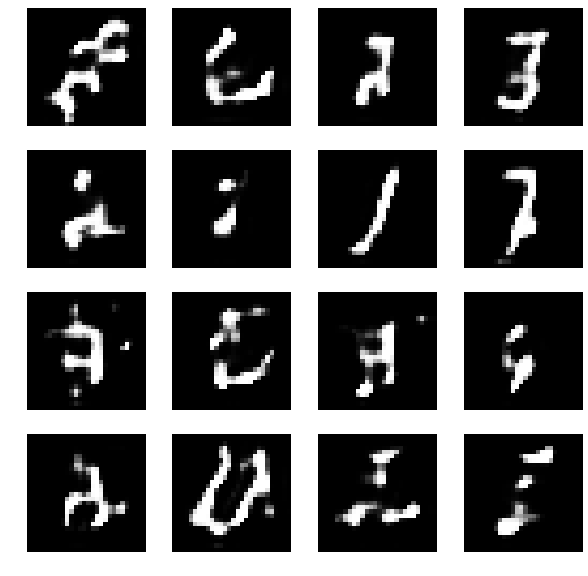

400: [D loss:0.684413, acc:0.546875] [A loss:0.991247, acc:0.078125]
401: [D loss:0.692534, acc:0.542969] [A loss:0.874348, acc:0.140625]
402: [D loss:0.689922, acc:0.560547] [A loss:0.943988, acc:0.046875]
403: [D loss:0.669574, acc:0.580078] [A loss:0.816640, acc:0.207031]
404: [D loss:0.677832, acc:0.562500] [A loss:0.989256, acc:0.058594]
405: [D loss:0.674542, acc:0.587891] [A loss:0.854651, acc:0.160156]
406: [D loss:0.675358, acc:0.582031] [A loss:0.996443, acc:0.042969]
407: [D loss:0.664887, acc:0.609375] [A loss:0.885268, acc:0.144531]
408: [D loss:0.682899, acc:0.558594] [A loss:1.068628, acc:0.035156]
409: [D loss:0.662195, acc:0.609375] [A loss:0.882261, acc:0.175781]
410: [D loss:0.674271, acc:0.570312] [A loss:1.092964, acc:0.015625]
411: [D loss:0.665998, acc:0.601562] [A loss:0.760149, acc:0.375000]
412: [D loss:0.701152, acc:0.511719] [A loss:1.321303, acc:0.000000]
413: [D loss:0.662847, acc:0.609375] [A loss:0.611540, acc:0.710938]
414: [D loss:0.743429, acc:0.50781

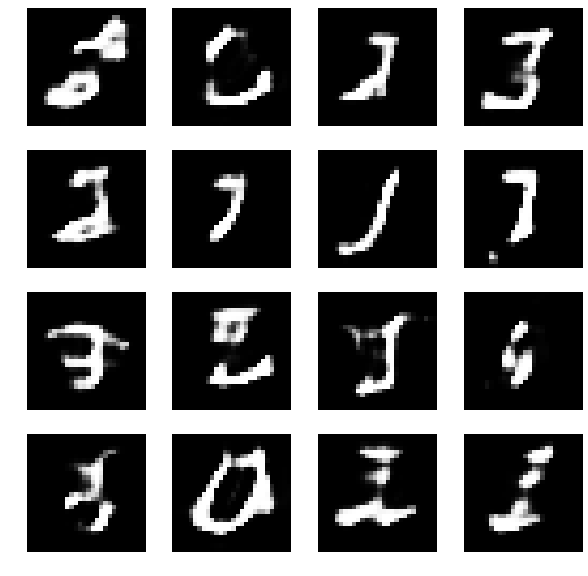

500: [D loss:0.668903, acc:0.605469] [A loss:0.893641, acc:0.152344]
501: [D loss:0.674300, acc:0.578125] [A loss:0.934999, acc:0.109375]
502: [D loss:0.666065, acc:0.601562] [A loss:0.838381, acc:0.203125]
503: [D loss:0.677200, acc:0.578125] [A loss:0.971687, acc:0.050781]
504: [D loss:0.666641, acc:0.583984] [A loss:0.843206, acc:0.238281]
505: [D loss:0.672721, acc:0.591797] [A loss:0.999584, acc:0.082031]
506: [D loss:0.663648, acc:0.613281] [A loss:0.871881, acc:0.199219]
507: [D loss:0.670775, acc:0.576172] [A loss:0.987316, acc:0.078125]
508: [D loss:0.670094, acc:0.578125] [A loss:0.850732, acc:0.238281]
509: [D loss:0.675273, acc:0.556641] [A loss:1.057931, acc:0.027344]
510: [D loss:0.655937, acc:0.630859] [A loss:0.801880, acc:0.300781]
511: [D loss:0.668007, acc:0.574219] [A loss:1.141253, acc:0.023438]
512: [D loss:0.675606, acc:0.562500] [A loss:0.697292, acc:0.535156]
513: [D loss:0.721945, acc:0.513672] [A loss:1.231905, acc:0.003906]
514: [D loss:0.685192, acc:0.55859

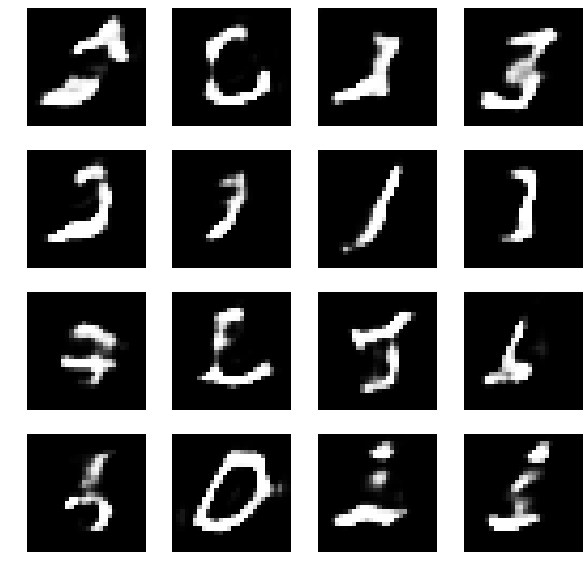

600: [D loss:0.679351, acc:0.566406] [A loss:0.860233, acc:0.203125]
601: [D loss:0.665190, acc:0.605469] [A loss:0.882312, acc:0.156250]
602: [D loss:0.679474, acc:0.572266] [A loss:0.952926, acc:0.105469]
603: [D loss:0.664680, acc:0.617188] [A loss:0.838404, acc:0.277344]
604: [D loss:0.681927, acc:0.570312] [A loss:1.066680, acc:0.042969]
605: [D loss:0.671325, acc:0.611328] [A loss:0.808130, acc:0.277344]
606: [D loss:0.696998, acc:0.535156] [A loss:1.080414, acc:0.035156]
607: [D loss:0.667620, acc:0.595703] [A loss:0.723239, acc:0.441406]
608: [D loss:0.713477, acc:0.527344] [A loss:1.101789, acc:0.019531]
609: [D loss:0.661690, acc:0.613281] [A loss:0.782291, acc:0.324219]
610: [D loss:0.687466, acc:0.539062] [A loss:1.000250, acc:0.070312]
611: [D loss:0.660999, acc:0.611328] [A loss:0.808437, acc:0.277344]
612: [D loss:0.675152, acc:0.574219] [A loss:0.961838, acc:0.082031]
613: [D loss:0.669815, acc:0.605469] [A loss:0.865058, acc:0.210938]
614: [D loss:0.660374, acc:0.60156

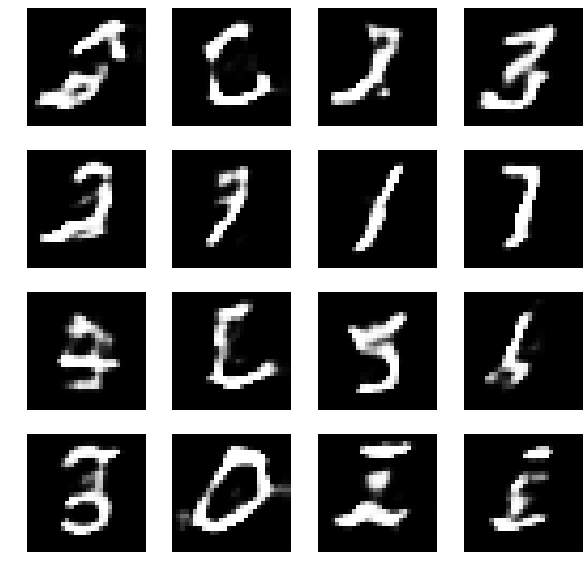

700: [D loss:0.668262, acc:0.580078] [A loss:0.919130, acc:0.121094]
701: [D loss:0.674054, acc:0.582031] [A loss:0.903558, acc:0.152344]
702: [D loss:0.678568, acc:0.574219] [A loss:0.925858, acc:0.144531]
703: [D loss:0.688076, acc:0.574219] [A loss:0.861942, acc:0.238281]
704: [D loss:0.678665, acc:0.556641] [A loss:0.956599, acc:0.097656]
705: [D loss:0.666755, acc:0.595703] [A loss:0.817385, acc:0.238281]
706: [D loss:0.682723, acc:0.550781] [A loss:0.997488, acc:0.066406]
707: [D loss:0.666292, acc:0.597656] [A loss:0.827351, acc:0.277344]
708: [D loss:0.693226, acc:0.560547] [A loss:1.071002, acc:0.039062]
709: [D loss:0.690230, acc:0.533203] [A loss:0.759018, acc:0.402344]
710: [D loss:0.694648, acc:0.552734] [A loss:1.003565, acc:0.058594]
711: [D loss:0.680970, acc:0.556641] [A loss:0.753881, acc:0.394531]
712: [D loss:0.682504, acc:0.566406] [A loss:1.052290, acc:0.031250]
713: [D loss:0.659495, acc:0.632812] [A loss:0.731530, acc:0.425781]
714: [D loss:0.686639, acc:0.56250

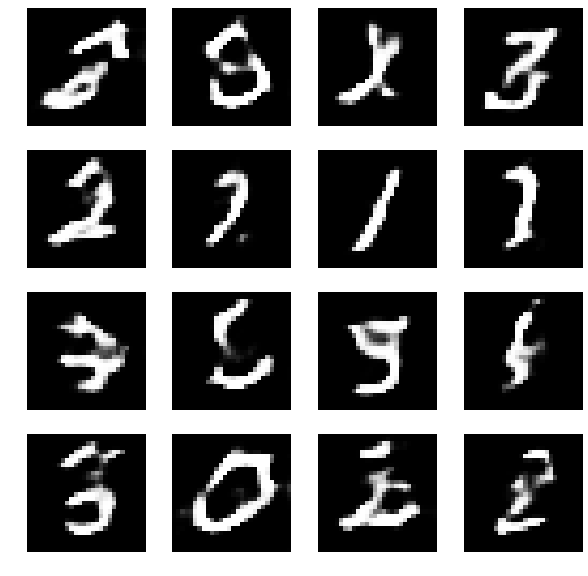

800: [D loss:0.683818, acc:0.564453] [A loss:0.954589, acc:0.093750]
801: [D loss:0.657187, acc:0.609375] [A loss:0.863841, acc:0.203125]
802: [D loss:0.683444, acc:0.585938] [A loss:0.933239, acc:0.101562]
803: [D loss:0.655480, acc:0.648438] [A loss:0.879228, acc:0.183594]
804: [D loss:0.656126, acc:0.615234] [A loss:0.912891, acc:0.175781]
805: [D loss:0.691037, acc:0.525391] [A loss:0.996789, acc:0.089844]
806: [D loss:0.674511, acc:0.576172] [A loss:0.832137, acc:0.246094]
807: [D loss:0.687788, acc:0.548828] [A loss:1.046230, acc:0.074219]
808: [D loss:0.664484, acc:0.591797] [A loss:0.716311, acc:0.500000]
809: [D loss:0.702353, acc:0.544922] [A loss:1.133037, acc:0.011719]
810: [D loss:0.671296, acc:0.589844] [A loss:0.719077, acc:0.464844]
811: [D loss:0.713412, acc:0.533203] [A loss:1.033486, acc:0.050781]
812: [D loss:0.670428, acc:0.593750] [A loss:0.753194, acc:0.417969]
813: [D loss:0.681406, acc:0.550781] [A loss:0.931031, acc:0.121094]
814: [D loss:0.659308, acc:0.63085

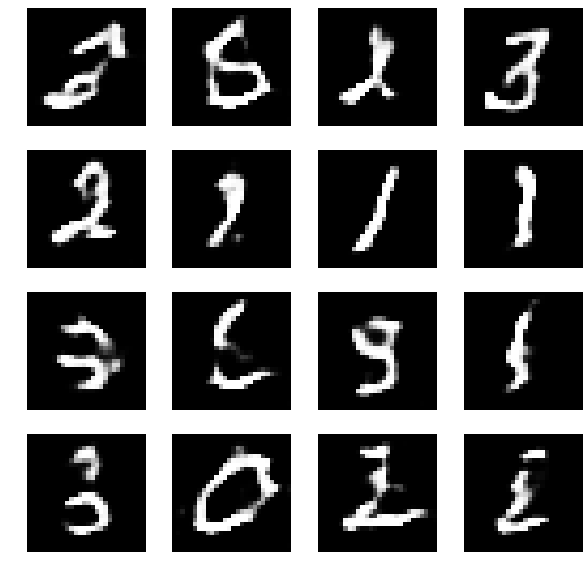

900: [D loss:0.666082, acc:0.578125] [A loss:0.828628, acc:0.308594]
901: [D loss:0.679962, acc:0.548828] [A loss:1.018533, acc:0.089844]
902: [D loss:0.679607, acc:0.564453] [A loss:0.906288, acc:0.167969]
903: [D loss:0.696679, acc:0.550781] [A loss:0.948567, acc:0.109375]
904: [D loss:0.681554, acc:0.562500] [A loss:0.846055, acc:0.234375]
905: [D loss:0.685994, acc:0.564453] [A loss:0.969766, acc:0.093750]
906: [D loss:0.668321, acc:0.595703] [A loss:0.767672, acc:0.347656]
907: [D loss:0.675823, acc:0.583984] [A loss:1.010780, acc:0.066406]
908: [D loss:0.662737, acc:0.613281] [A loss:0.805826, acc:0.324219]
909: [D loss:0.703806, acc:0.539062] [A loss:1.057180, acc:0.042969]
910: [D loss:0.670340, acc:0.591797] [A loss:0.773345, acc:0.324219]
911: [D loss:0.683467, acc:0.564453] [A loss:1.037763, acc:0.046875]
912: [D loss:0.672134, acc:0.568359] [A loss:0.773097, acc:0.359375]
913: [D loss:0.687300, acc:0.558594] [A loss:1.025196, acc:0.070312]
914: [D loss:0.684282, acc:0.57031

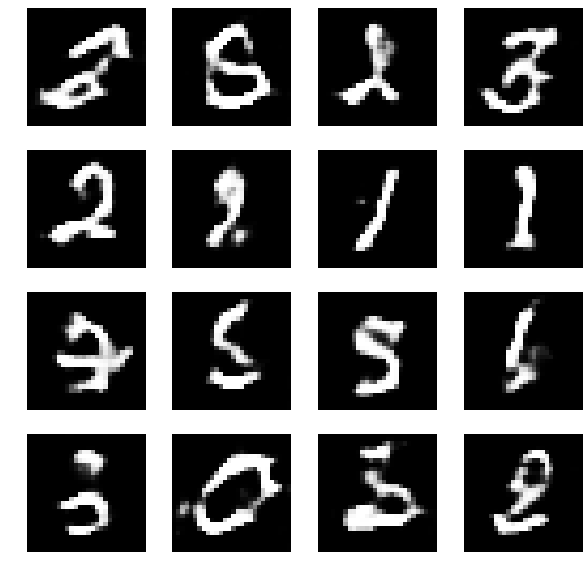

1000: [D loss:0.693299, acc:0.550781] [A loss:0.999361, acc:0.070312]
1001: [D loss:0.665575, acc:0.599609] [A loss:0.785817, acc:0.316406]
1002: [D loss:0.688505, acc:0.568359] [A loss:0.963283, acc:0.121094]
1003: [D loss:0.678269, acc:0.601562] [A loss:0.825511, acc:0.265625]
1004: [D loss:0.698310, acc:0.535156] [A loss:0.963150, acc:0.113281]
1005: [D loss:0.673280, acc:0.574219] [A loss:0.815932, acc:0.281250]
1006: [D loss:0.681564, acc:0.582031] [A loss:0.993142, acc:0.082031]
1007: [D loss:0.672186, acc:0.582031] [A loss:0.769693, acc:0.390625]
1008: [D loss:0.690874, acc:0.566406] [A loss:0.982159, acc:0.109375]
1009: [D loss:0.674491, acc:0.583984] [A loss:0.779174, acc:0.328125]
1010: [D loss:0.694585, acc:0.541016] [A loss:1.038792, acc:0.066406]
1011: [D loss:0.672639, acc:0.572266] [A loss:0.771744, acc:0.359375]
1012: [D loss:0.699177, acc:0.554688] [A loss:1.034455, acc:0.062500]
1013: [D loss:0.660307, acc:0.607422] [A loss:0.763143, acc:0.382812]
1014: [D loss:0.6906

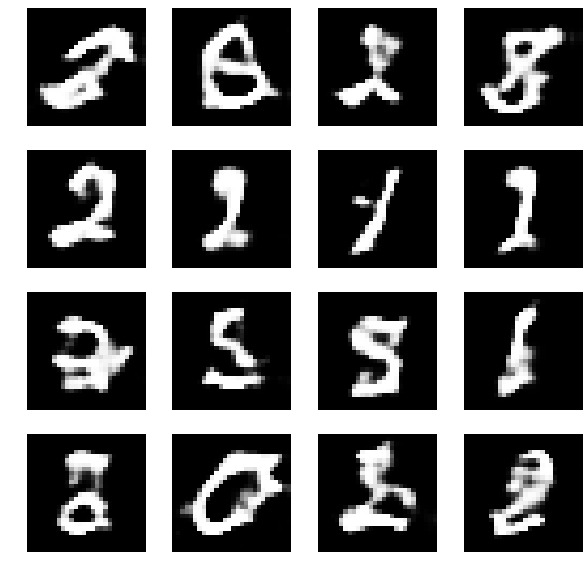

1100: [D loss:0.684001, acc:0.550781] [A loss:0.893090, acc:0.207031]
1101: [D loss:0.675427, acc:0.587891] [A loss:0.952581, acc:0.121094]
1102: [D loss:0.674708, acc:0.566406] [A loss:0.832768, acc:0.277344]
1103: [D loss:0.689362, acc:0.544922] [A loss:1.040652, acc:0.078125]
1104: [D loss:0.668699, acc:0.566406] [A loss:0.789366, acc:0.339844]
1105: [D loss:0.703502, acc:0.542969] [A loss:1.060742, acc:0.062500]
1106: [D loss:0.669352, acc:0.582031] [A loss:0.783887, acc:0.335938]
1107: [D loss:0.704507, acc:0.539062] [A loss:1.030565, acc:0.089844]
1108: [D loss:0.675831, acc:0.587891] [A loss:0.815278, acc:0.332031]
1109: [D loss:0.680223, acc:0.589844] [A loss:1.013381, acc:0.105469]
1110: [D loss:0.666880, acc:0.597656] [A loss:0.824579, acc:0.281250]
1111: [D loss:0.682429, acc:0.558594] [A loss:1.055307, acc:0.046875]
1112: [D loss:0.692028, acc:0.523438] [A loss:0.819968, acc:0.324219]
1113: [D loss:0.702486, acc:0.525391] [A loss:1.033594, acc:0.070312]
1114: [D loss:0.6797

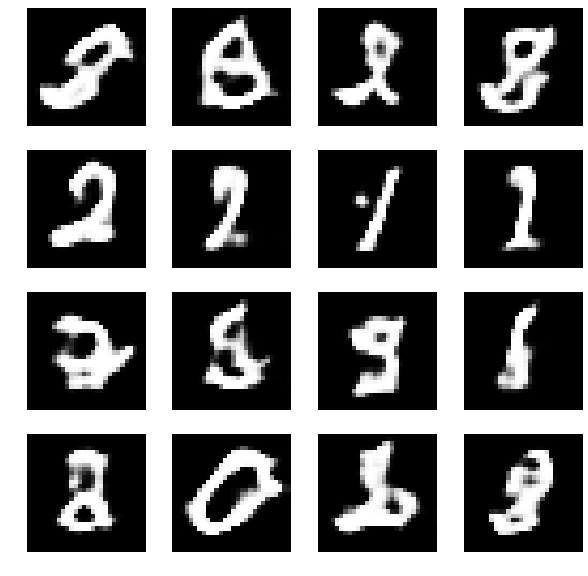

1200: [D loss:0.682078, acc:0.550781] [A loss:0.752545, acc:0.371094]
1201: [D loss:0.681873, acc:0.566406] [A loss:1.096911, acc:0.050781]
1202: [D loss:0.677181, acc:0.560547] [A loss:0.725118, acc:0.457031]
1203: [D loss:0.690256, acc:0.564453] [A loss:1.016522, acc:0.089844]
1204: [D loss:0.670732, acc:0.591797] [A loss:0.805699, acc:0.304688]
1205: [D loss:0.690742, acc:0.552734] [A loss:0.958976, acc:0.113281]
1206: [D loss:0.666212, acc:0.597656] [A loss:0.821984, acc:0.296875]
1207: [D loss:0.697170, acc:0.550781] [A loss:1.041268, acc:0.085938]
1208: [D loss:0.665439, acc:0.597656] [A loss:0.727538, acc:0.441406]
1209: [D loss:0.682536, acc:0.560547] [A loss:1.069042, acc:0.078125]
1210: [D loss:0.673893, acc:0.570312] [A loss:0.725475, acc:0.484375]
1211: [D loss:0.698619, acc:0.529297] [A loss:1.013489, acc:0.089844]
1212: [D loss:0.696179, acc:0.513672] [A loss:0.761954, acc:0.378906]
1213: [D loss:0.699104, acc:0.546875] [A loss:0.927923, acc:0.140625]
1214: [D loss:0.6646

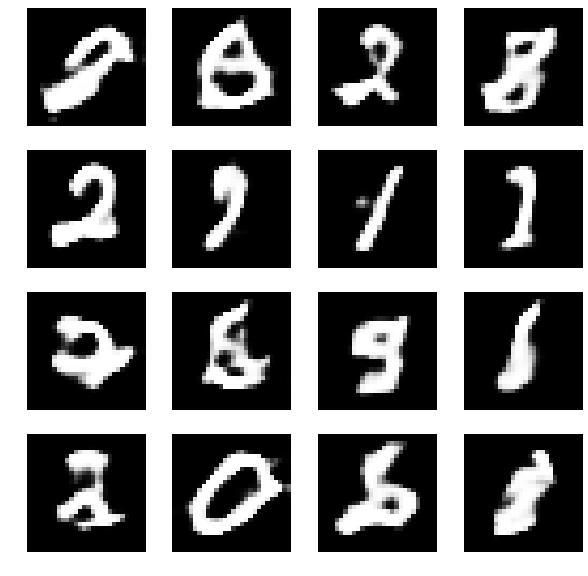

1300: [D loss:0.681054, acc:0.552734] [A loss:0.833879, acc:0.281250]
1301: [D loss:0.674860, acc:0.585938] [A loss:0.870514, acc:0.210938]
1302: [D loss:0.676686, acc:0.566406] [A loss:0.955788, acc:0.128906]
1303: [D loss:0.681007, acc:0.562500] [A loss:0.845601, acc:0.234375]
1304: [D loss:0.693215, acc:0.527344] [A loss:1.014847, acc:0.070312]
1305: [D loss:0.692629, acc:0.546875] [A loss:0.797731, acc:0.324219]
1306: [D loss:0.694389, acc:0.566406] [A loss:0.955516, acc:0.074219]
1307: [D loss:0.672521, acc:0.580078] [A loss:0.789990, acc:0.289062]
1308: [D loss:0.680166, acc:0.578125] [A loss:0.964018, acc:0.125000]
1309: [D loss:0.684520, acc:0.548828] [A loss:0.801922, acc:0.308594]
1310: [D loss:0.677769, acc:0.564453] [A loss:1.004548, acc:0.070312]
1311: [D loss:0.701696, acc:0.541016] [A loss:0.874959, acc:0.222656]
1312: [D loss:0.697660, acc:0.531250] [A loss:0.909929, acc:0.156250]
1313: [D loss:0.682191, acc:0.558594] [A loss:0.936026, acc:0.144531]
1314: [D loss:0.6914

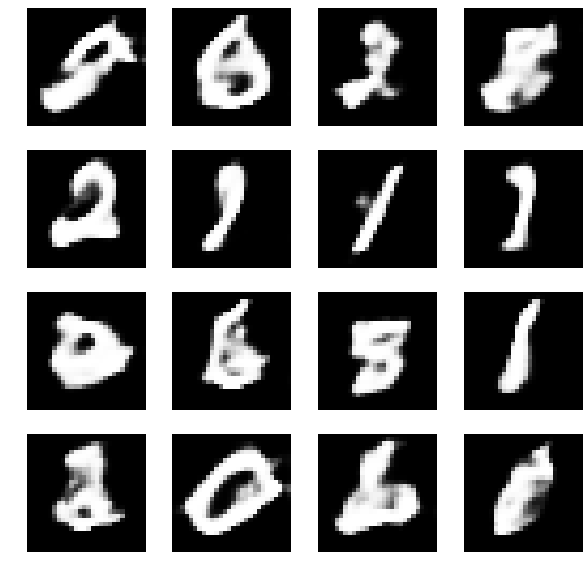

1400: [D loss:0.687272, acc:0.548828] [A loss:0.840187, acc:0.261719]
1401: [D loss:0.692020, acc:0.537109] [A loss:0.931928, acc:0.113281]
1402: [D loss:0.680832, acc:0.580078] [A loss:0.816981, acc:0.261719]
1403: [D loss:0.673251, acc:0.605469] [A loss:0.929252, acc:0.144531]
1404: [D loss:0.686155, acc:0.556641] [A loss:0.932755, acc:0.125000]
1405: [D loss:0.672847, acc:0.566406] [A loss:0.800912, acc:0.312500]
1406: [D loss:0.689825, acc:0.554688] [A loss:0.937230, acc:0.113281]
1407: [D loss:0.676681, acc:0.578125] [A loss:0.835334, acc:0.250000]
1408: [D loss:0.709409, acc:0.525391] [A loss:0.948142, acc:0.128906]
1409: [D loss:0.689980, acc:0.533203] [A loss:0.966880, acc:0.128906]
1410: [D loss:0.676825, acc:0.580078] [A loss:0.794335, acc:0.324219]
1411: [D loss:0.683134, acc:0.548828] [A loss:1.006749, acc:0.089844]
1412: [D loss:0.692609, acc:0.544922] [A loss:0.776577, acc:0.339844]
1413: [D loss:0.690882, acc:0.535156] [A loss:0.991909, acc:0.082031]
1414: [D loss:0.6880

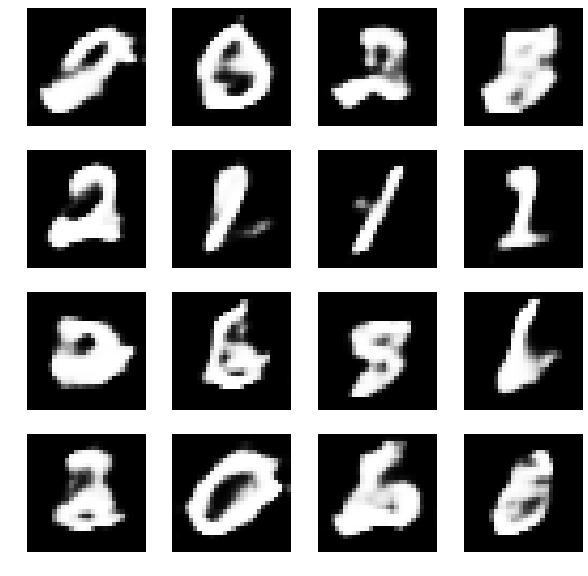

1500: [D loss:0.678233, acc:0.578125] [A loss:0.749144, acc:0.347656]
1501: [D loss:0.700495, acc:0.542969] [A loss:1.059134, acc:0.046875]
1502: [D loss:0.693272, acc:0.537109] [A loss:0.724829, acc:0.429688]
1503: [D loss:0.733974, acc:0.484375] [A loss:0.902958, acc:0.121094]
1504: [D loss:0.688423, acc:0.541016] [A loss:0.821067, acc:0.222656]
1505: [D loss:0.698890, acc:0.542969] [A loss:0.905247, acc:0.144531]
1506: [D loss:0.693177, acc:0.527344] [A loss:0.795842, acc:0.289062]
1507: [D loss:0.686337, acc:0.556641] [A loss:0.927177, acc:0.117188]
1508: [D loss:0.679401, acc:0.564453] [A loss:0.717091, acc:0.488281]
1509: [D loss:0.709441, acc:0.507812] [A loss:0.902418, acc:0.136719]
1510: [D loss:0.680755, acc:0.576172] [A loss:0.792689, acc:0.296875]
1511: [D loss:0.673948, acc:0.605469] [A loss:0.894016, acc:0.148438]
1512: [D loss:0.682788, acc:0.554688] [A loss:0.774976, acc:0.292969]
1513: [D loss:0.712717, acc:0.515625] [A loss:0.921867, acc:0.109375]
1514: [D loss:0.6896

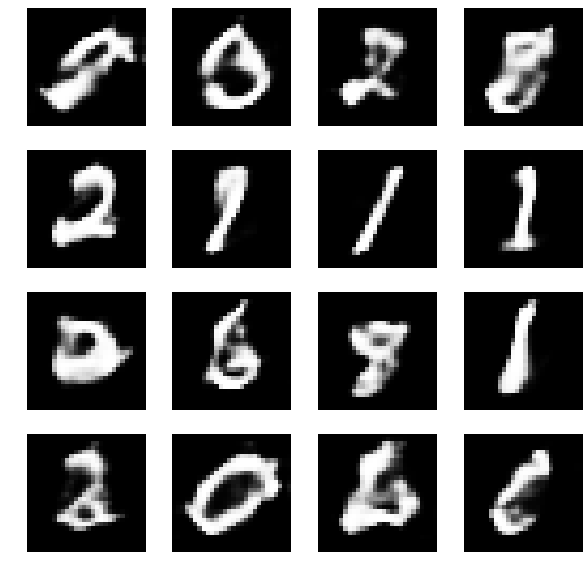

1600: [D loss:0.675229, acc:0.597656] [A loss:0.775444, acc:0.339844]
1601: [D loss:0.696202, acc:0.539062] [A loss:1.036751, acc:0.054688]
1602: [D loss:0.686335, acc:0.542969] [A loss:0.728485, acc:0.429688]
1603: [D loss:0.699591, acc:0.529297] [A loss:1.039844, acc:0.058594]
1604: [D loss:0.677180, acc:0.521484] [A loss:0.697276, acc:0.515625]
1605: [D loss:0.698532, acc:0.533203] [A loss:1.022760, acc:0.046875]
1606: [D loss:0.690068, acc:0.544922] [A loss:0.679436, acc:0.570312]
1607: [D loss:0.705058, acc:0.515625] [A loss:0.994516, acc:0.070312]
1608: [D loss:0.698149, acc:0.544922] [A loss:0.736363, acc:0.429688]
1609: [D loss:0.692820, acc:0.523438] [A loss:0.943344, acc:0.121094]
1610: [D loss:0.681816, acc:0.572266] [A loss:0.769963, acc:0.351562]
1611: [D loss:0.700523, acc:0.511719] [A loss:0.943951, acc:0.097656]
1612: [D loss:0.693397, acc:0.525391] [A loss:0.771465, acc:0.335938]
1613: [D loss:0.698323, acc:0.535156] [A loss:0.915070, acc:0.105469]
1614: [D loss:0.6926

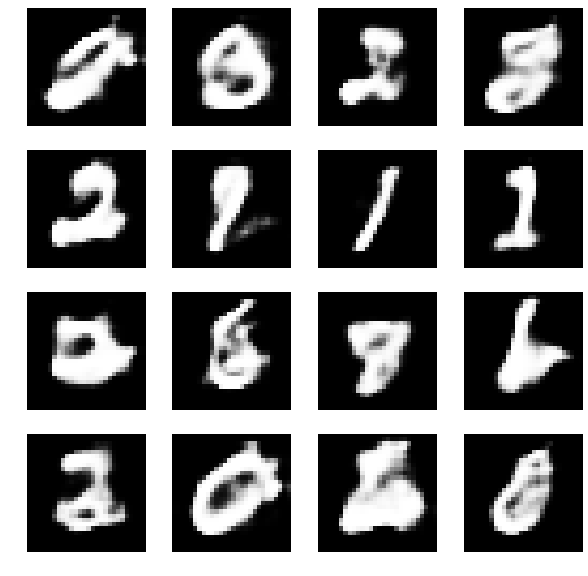

1700: [D loss:0.717800, acc:0.496094] [A loss:1.026193, acc:0.058594]
1701: [D loss:0.682366, acc:0.568359] [A loss:0.652433, acc:0.652344]
1702: [D loss:0.716287, acc:0.515625] [A loss:0.968896, acc:0.082031]
1703: [D loss:0.693092, acc:0.546875] [A loss:0.704975, acc:0.492188]
1704: [D loss:0.693273, acc:0.548828] [A loss:0.923057, acc:0.117188]
1705: [D loss:0.683256, acc:0.539062] [A loss:0.772598, acc:0.312500]
1706: [D loss:0.708021, acc:0.525391] [A loss:0.916939, acc:0.109375]
1707: [D loss:0.689002, acc:0.533203] [A loss:0.768056, acc:0.351562]
1708: [D loss:0.694084, acc:0.554688] [A loss:0.948384, acc:0.140625]
1709: [D loss:0.681256, acc:0.574219] [A loss:0.755242, acc:0.363281]
1710: [D loss:0.698910, acc:0.552734] [A loss:0.915520, acc:0.105469]
1711: [D loss:0.683061, acc:0.558594] [A loss:0.737305, acc:0.386719]
1712: [D loss:0.704864, acc:0.517578] [A loss:0.956350, acc:0.082031]
1713: [D loss:0.676833, acc:0.572266] [A loss:0.756530, acc:0.363281]
1714: [D loss:0.6806

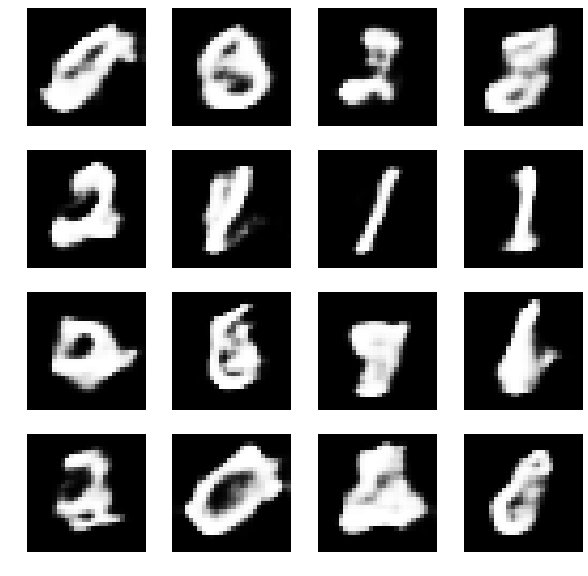

1800: [D loss:0.686358, acc:0.560547] [A loss:0.695247, acc:0.488281]
1801: [D loss:0.709655, acc:0.529297] [A loss:1.019182, acc:0.074219]
1802: [D loss:0.690072, acc:0.560547] [A loss:0.647620, acc:0.644531]
1803: [D loss:0.723286, acc:0.513672] [A loss:0.955982, acc:0.089844]
1804: [D loss:0.690409, acc:0.560547] [A loss:0.751368, acc:0.398438]
1805: [D loss:0.700971, acc:0.537109] [A loss:0.927663, acc:0.109375]
1806: [D loss:0.691332, acc:0.535156] [A loss:0.758717, acc:0.335938]
1807: [D loss:0.700131, acc:0.544922] [A loss:0.864530, acc:0.187500]
1808: [D loss:0.689952, acc:0.517578] [A loss:0.780412, acc:0.343750]
1809: [D loss:0.694068, acc:0.554688] [A loss:0.937222, acc:0.093750]
1810: [D loss:0.683874, acc:0.566406] [A loss:0.740248, acc:0.417969]
1811: [D loss:0.701705, acc:0.515625] [A loss:0.932885, acc:0.121094]
1812: [D loss:0.688222, acc:0.529297] [A loss:0.731303, acc:0.421875]
1813: [D loss:0.699801, acc:0.535156] [A loss:0.904560, acc:0.167969]
1814: [D loss:0.6839

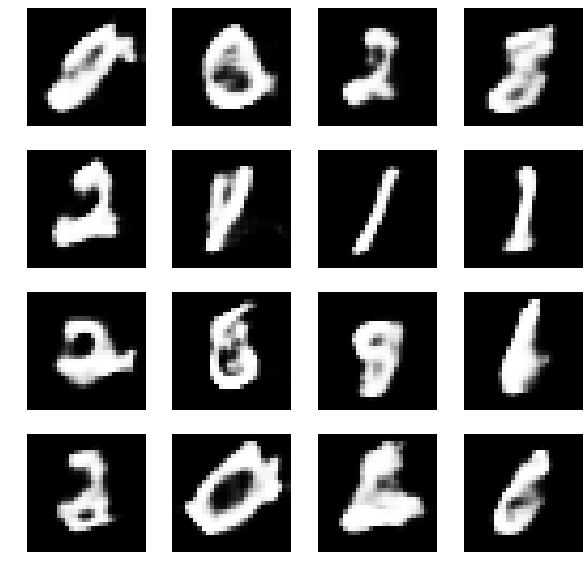

1900: [D loss:0.692819, acc:0.556641] [A loss:0.778357, acc:0.347656]
1901: [D loss:0.707321, acc:0.517578] [A loss:0.981375, acc:0.066406]
1902: [D loss:0.692877, acc:0.535156] [A loss:0.794398, acc:0.273438]
1903: [D loss:0.693634, acc:0.521484] [A loss:0.924304, acc:0.132812]
1904: [D loss:0.681646, acc:0.541016] [A loss:0.725700, acc:0.429688]
1905: [D loss:0.707537, acc:0.531250] [A loss:1.004495, acc:0.070312]
1906: [D loss:0.688722, acc:0.546875] [A loss:0.712827, acc:0.476562]
1907: [D loss:0.695978, acc:0.544922] [A loss:0.899862, acc:0.109375]
1908: [D loss:0.681852, acc:0.548828] [A loss:0.741397, acc:0.398438]
1909: [D loss:0.687738, acc:0.568359] [A loss:0.872516, acc:0.191406]
1910: [D loss:0.678891, acc:0.556641] [A loss:0.792446, acc:0.316406]
1911: [D loss:0.694887, acc:0.529297] [A loss:0.907208, acc:0.144531]
1912: [D loss:0.692403, acc:0.535156] [A loss:0.798274, acc:0.320312]
1913: [D loss:0.689885, acc:0.574219] [A loss:0.933727, acc:0.117188]
1914: [D loss:0.6916

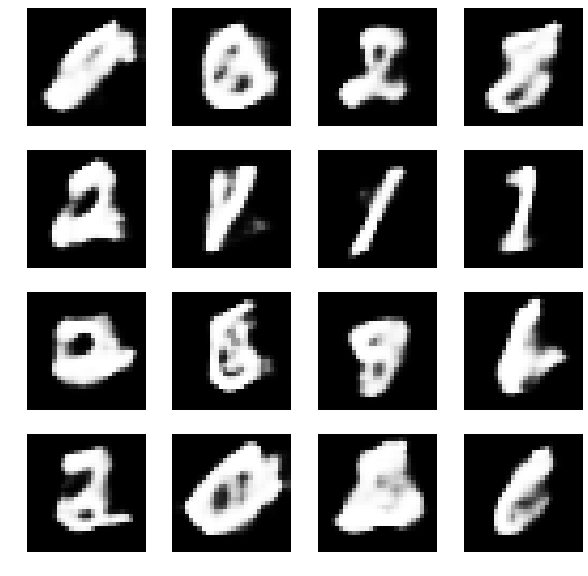

2000: [D loss:0.709879, acc:0.533203] [A loss:1.097727, acc:0.066406]
2001: [D loss:0.690285, acc:0.535156] [A loss:0.612947, acc:0.718750]
2002: [D loss:0.719192, acc:0.535156] [A loss:0.998132, acc:0.078125]
2003: [D loss:0.687672, acc:0.548828] [A loss:0.771197, acc:0.328125]
2004: [D loss:0.713874, acc:0.529297] [A loss:0.925128, acc:0.113281]
2005: [D loss:0.696730, acc:0.525391] [A loss:0.852964, acc:0.210938]
2006: [D loss:0.691825, acc:0.541016] [A loss:0.849261, acc:0.230469]
2007: [D loss:0.683704, acc:0.562500] [A loss:0.868936, acc:0.179688]
2008: [D loss:0.691108, acc:0.548828] [A loss:0.818611, acc:0.230469]
2009: [D loss:0.686836, acc:0.554688] [A loss:0.883612, acc:0.195312]
2010: [D loss:0.690706, acc:0.535156] [A loss:0.861271, acc:0.195312]
2011: [D loss:0.688537, acc:0.535156] [A loss:0.800073, acc:0.253906]
2012: [D loss:0.685913, acc:0.570312] [A loss:0.948968, acc:0.125000]
2013: [D loss:0.695292, acc:0.550781] [A loss:0.808301, acc:0.296875]
2014: [D loss:0.6906

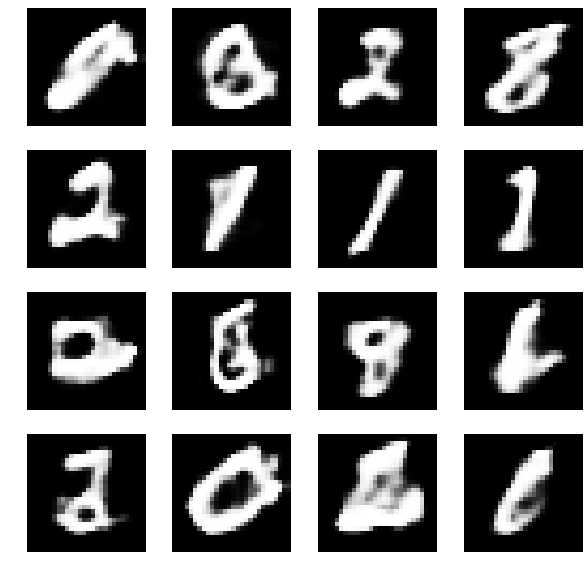

2100: [D loss:0.690400, acc:0.568359] [A loss:0.903317, acc:0.144531]
2101: [D loss:0.690607, acc:0.558594] [A loss:0.747747, acc:0.406250]
2102: [D loss:0.710143, acc:0.523438] [A loss:0.984685, acc:0.101562]
2103: [D loss:0.689063, acc:0.527344] [A loss:0.718980, acc:0.433594]
2104: [D loss:0.690884, acc:0.560547] [A loss:0.922963, acc:0.132812]
2105: [D loss:0.692797, acc:0.523438] [A loss:0.791949, acc:0.316406]
2106: [D loss:0.693823, acc:0.527344] [A loss:0.886617, acc:0.167969]
2107: [D loss:0.691954, acc:0.537109] [A loss:0.795670, acc:0.335938]
2108: [D loss:0.693331, acc:0.539062] [A loss:0.826488, acc:0.238281]
2109: [D loss:0.703017, acc:0.529297] [A loss:1.014037, acc:0.070312]
2110: [D loss:0.681943, acc:0.560547] [A loss:0.754029, acc:0.375000]
2111: [D loss:0.707841, acc:0.523438] [A loss:0.914612, acc:0.167969]
2112: [D loss:0.682962, acc:0.544922] [A loss:0.841666, acc:0.203125]
2113: [D loss:0.694146, acc:0.533203] [A loss:0.862260, acc:0.199219]
2114: [D loss:0.7028

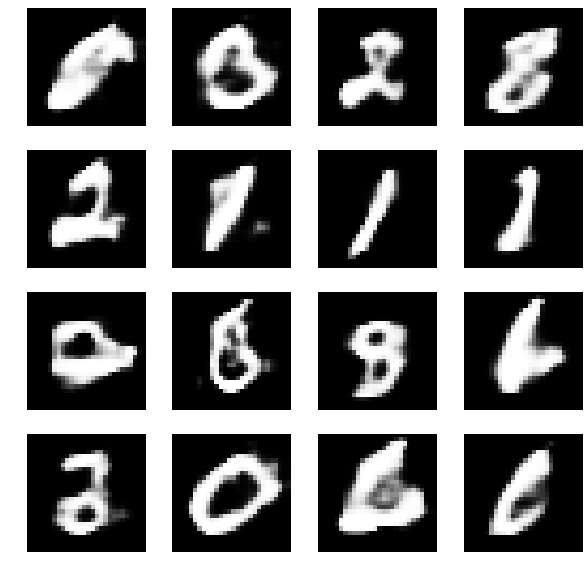

2200: [D loss:0.674904, acc:0.554688] [A loss:0.721117, acc:0.457031]
2201: [D loss:0.690872, acc:0.542969] [A loss:0.929110, acc:0.156250]
2202: [D loss:0.685678, acc:0.562500] [A loss:0.773798, acc:0.390625]
2203: [D loss:0.692651, acc:0.539062] [A loss:0.930802, acc:0.152344]
2204: [D loss:0.686855, acc:0.537109] [A loss:0.747423, acc:0.464844]
2205: [D loss:0.690810, acc:0.539062] [A loss:0.935261, acc:0.117188]
2206: [D loss:0.666193, acc:0.582031] [A loss:0.782224, acc:0.316406]
2207: [D loss:0.718827, acc:0.511719] [A loss:0.930110, acc:0.140625]
2208: [D loss:0.683458, acc:0.552734] [A loss:0.790499, acc:0.343750]
2209: [D loss:0.709707, acc:0.509766] [A loss:1.000748, acc:0.078125]
2210: [D loss:0.691870, acc:0.537109] [A loss:0.707342, acc:0.492188]
2211: [D loss:0.717193, acc:0.498047] [A loss:0.996366, acc:0.093750]
2212: [D loss:0.725742, acc:0.482422] [A loss:0.738872, acc:0.425781]
2213: [D loss:0.706177, acc:0.525391] [A loss:0.939748, acc:0.132812]
2214: [D loss:0.6954

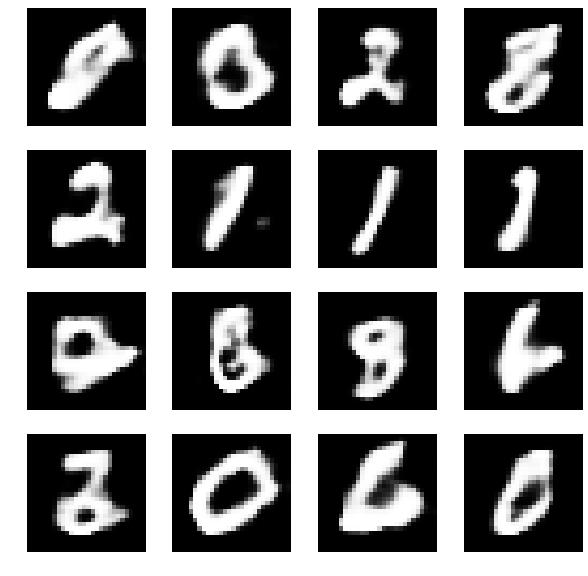

2300: [D loss:0.688499, acc:0.568359] [A loss:0.857149, acc:0.175781]
2301: [D loss:0.706919, acc:0.509766] [A loss:0.803970, acc:0.253906]
2302: [D loss:0.681841, acc:0.562500] [A loss:0.795133, acc:0.285156]
2303: [D loss:0.705048, acc:0.513672] [A loss:0.877628, acc:0.195312]
2304: [D loss:0.716646, acc:0.507812] [A loss:0.772343, acc:0.343750]
2305: [D loss:0.691899, acc:0.548828] [A loss:0.950429, acc:0.105469]
2306: [D loss:0.693602, acc:0.546875] [A loss:0.727380, acc:0.464844]
2307: [D loss:0.707796, acc:0.527344] [A loss:0.916684, acc:0.140625]
2308: [D loss:0.695349, acc:0.548828] [A loss:0.757246, acc:0.355469]
2309: [D loss:0.706573, acc:0.513672] [A loss:0.960071, acc:0.089844]
2310: [D loss:0.696874, acc:0.531250] [A loss:0.690156, acc:0.492188]
2311: [D loss:0.724407, acc:0.496094] [A loss:0.916630, acc:0.105469]
2312: [D loss:0.675177, acc:0.574219] [A loss:0.734554, acc:0.441406]
2313: [D loss:0.697853, acc:0.523438] [A loss:0.863687, acc:0.175781]
2314: [D loss:0.7035

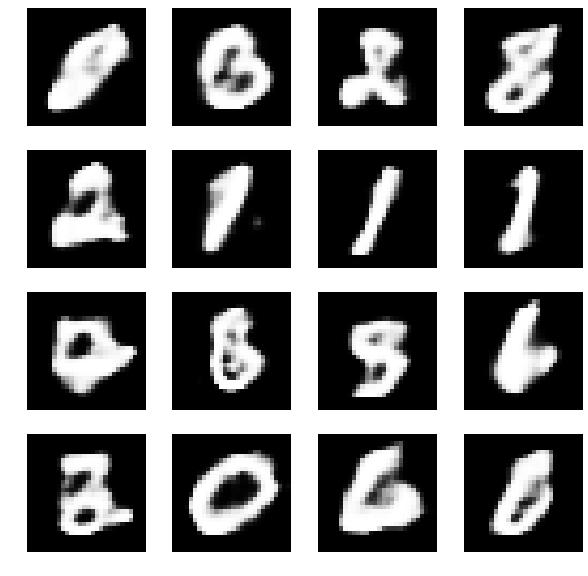

2400: [D loss:0.723994, acc:0.503906] [A loss:0.992828, acc:0.078125]
2401: [D loss:0.692659, acc:0.533203] [A loss:0.716368, acc:0.437500]
2402: [D loss:0.710563, acc:0.503906] [A loss:0.919799, acc:0.125000]
2403: [D loss:0.686375, acc:0.541016] [A loss:0.816041, acc:0.265625]
2404: [D loss:0.702275, acc:0.521484] [A loss:0.853326, acc:0.203125]
2405: [D loss:0.703178, acc:0.505859] [A loss:0.779709, acc:0.308594]
2406: [D loss:0.707931, acc:0.517578] [A loss:0.867134, acc:0.148438]
2407: [D loss:0.698317, acc:0.529297] [A loss:0.779255, acc:0.328125]
2408: [D loss:0.702982, acc:0.511719] [A loss:0.878517, acc:0.175781]
2409: [D loss:0.683162, acc:0.560547] [A loss:0.776954, acc:0.320312]
2410: [D loss:0.702621, acc:0.509766] [A loss:0.911222, acc:0.152344]
2411: [D loss:0.688827, acc:0.542969] [A loss:0.803787, acc:0.308594]
2412: [D loss:0.705014, acc:0.507812] [A loss:0.879604, acc:0.195312]
2413: [D loss:0.682709, acc:0.558594] [A loss:0.851478, acc:0.242188]
2414: [D loss:0.6987

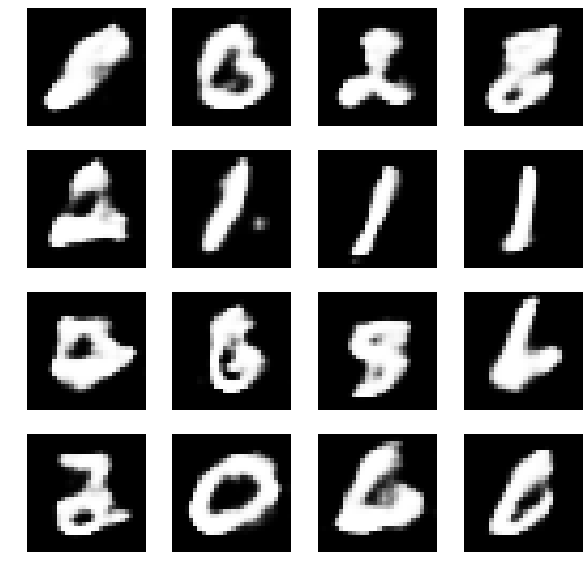

2500: [D loss:0.724620, acc:0.505859] [A loss:0.962104, acc:0.089844]
2501: [D loss:0.704290, acc:0.501953] [A loss:0.697725, acc:0.496094]
2502: [D loss:0.730579, acc:0.496094] [A loss:0.898535, acc:0.171875]
2503: [D loss:0.697631, acc:0.509766] [A loss:0.727604, acc:0.417969]
2504: [D loss:0.696340, acc:0.539062] [A loss:0.898274, acc:0.128906]
2505: [D loss:0.687129, acc:0.523438] [A loss:0.777653, acc:0.355469]
2506: [D loss:0.723014, acc:0.503906] [A loss:0.833228, acc:0.250000]
2507: [D loss:0.690546, acc:0.558594] [A loss:0.817163, acc:0.253906]
2508: [D loss:0.692738, acc:0.550781] [A loss:0.869032, acc:0.210938]
2509: [D loss:0.714153, acc:0.501953] [A loss:0.798005, acc:0.300781]
2510: [D loss:0.695823, acc:0.525391] [A loss:0.953753, acc:0.082031]
2511: [D loss:0.683059, acc:0.574219] [A loss:0.764559, acc:0.371094]
2512: [D loss:0.712766, acc:0.500000] [A loss:0.865136, acc:0.199219]
2513: [D loss:0.702919, acc:0.533203] [A loss:0.772599, acc:0.375000]
2514: [D loss:0.7174

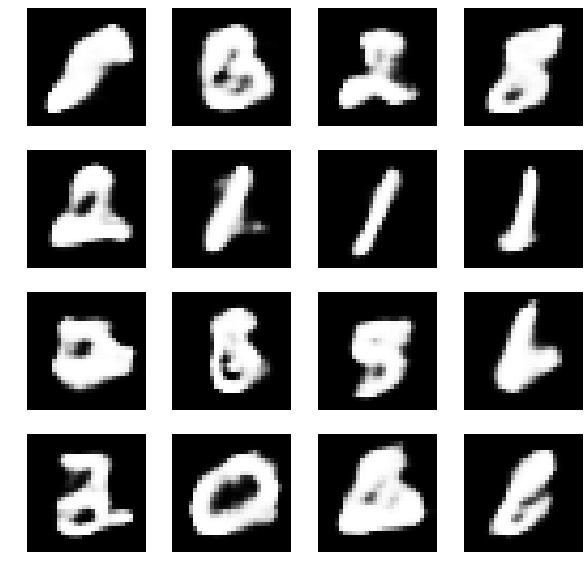

2600: [D loss:0.696862, acc:0.531250] [A loss:0.923068, acc:0.128906]
2601: [D loss:0.695625, acc:0.537109] [A loss:0.802285, acc:0.277344]
2602: [D loss:0.692596, acc:0.558594] [A loss:0.835256, acc:0.218750]
2603: [D loss:0.687711, acc:0.566406] [A loss:0.853168, acc:0.257812]
2604: [D loss:0.694397, acc:0.513672] [A loss:0.762275, acc:0.363281]
2605: [D loss:0.696126, acc:0.544922] [A loss:0.912296, acc:0.128906]
2606: [D loss:0.702371, acc:0.507812] [A loss:0.723405, acc:0.429688]
2607: [D loss:0.703230, acc:0.529297] [A loss:1.027692, acc:0.035156]
2608: [D loss:0.704630, acc:0.529297] [A loss:0.669973, acc:0.597656]
2609: [D loss:0.729451, acc:0.509766] [A loss:0.968264, acc:0.042969]
2610: [D loss:0.698776, acc:0.525391] [A loss:0.705992, acc:0.457031]
2611: [D loss:0.726913, acc:0.517578] [A loss:0.965120, acc:0.082031]
2612: [D loss:0.694085, acc:0.531250] [A loss:0.754452, acc:0.386719]
2613: [D loss:0.702283, acc:0.513672] [A loss:0.839064, acc:0.164062]
2614: [D loss:0.6867

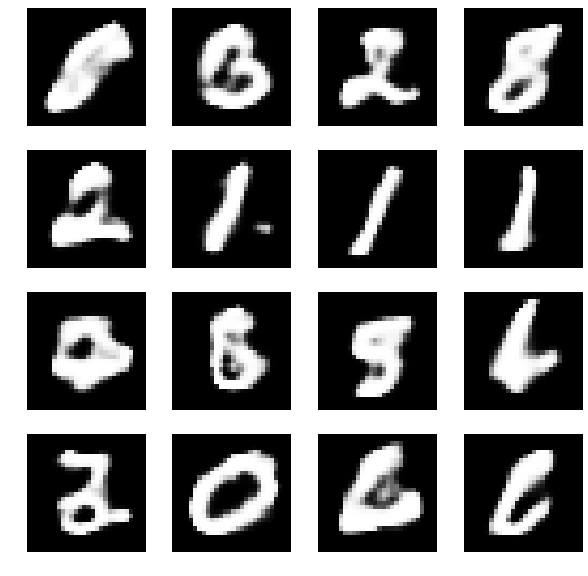

2700: [D loss:0.730176, acc:0.500000] [A loss:0.989997, acc:0.085938]
2701: [D loss:0.693514, acc:0.541016] [A loss:0.736437, acc:0.402344]
2702: [D loss:0.706515, acc:0.511719] [A loss:0.921303, acc:0.125000]
2703: [D loss:0.689328, acc:0.546875] [A loss:0.756108, acc:0.351562]
2704: [D loss:0.686897, acc:0.574219] [A loss:0.879520, acc:0.167969]
2705: [D loss:0.682674, acc:0.558594] [A loss:0.720839, acc:0.484375]
2706: [D loss:0.704723, acc:0.503906] [A loss:0.909396, acc:0.148438]
2707: [D loss:0.683630, acc:0.541016] [A loss:0.711517, acc:0.476562]
2708: [D loss:0.703853, acc:0.517578] [A loss:0.959577, acc:0.109375]
2709: [D loss:0.684464, acc:0.550781] [A loss:0.687855, acc:0.542969]
2710: [D loss:0.711603, acc:0.513672] [A loss:0.959312, acc:0.105469]
2711: [D loss:0.697906, acc:0.507812] [A loss:0.743703, acc:0.332031]
2712: [D loss:0.704500, acc:0.507812] [A loss:0.934857, acc:0.128906]
2713: [D loss:0.695115, acc:0.541016] [A loss:0.724437, acc:0.472656]
2714: [D loss:0.7141

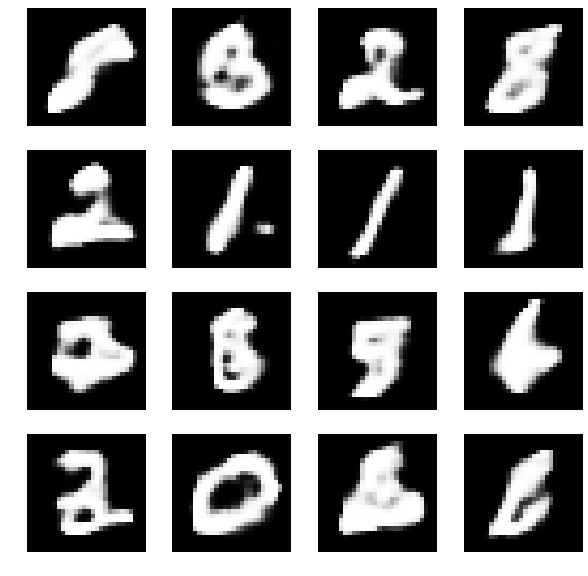

2800: [D loss:0.711280, acc:0.513672] [A loss:0.960733, acc:0.097656]
2801: [D loss:0.702072, acc:0.480469] [A loss:0.732749, acc:0.425781]
2802: [D loss:0.717735, acc:0.527344] [A loss:0.904397, acc:0.113281]
2803: [D loss:0.689758, acc:0.535156] [A loss:0.780203, acc:0.339844]
2804: [D loss:0.689279, acc:0.556641] [A loss:0.864796, acc:0.164062]
2805: [D loss:0.695456, acc:0.535156] [A loss:0.810446, acc:0.273438]
2806: [D loss:0.693258, acc:0.533203] [A loss:0.881011, acc:0.152344]
2807: [D loss:0.701342, acc:0.517578] [A loss:0.781175, acc:0.304688]
2808: [D loss:0.691045, acc:0.519531] [A loss:0.998248, acc:0.089844]
2809: [D loss:0.696512, acc:0.519531] [A loss:0.710307, acc:0.476562]
2810: [D loss:0.719732, acc:0.503906] [A loss:0.966466, acc:0.101562]
2811: [D loss:0.686381, acc:0.525391] [A loss:0.717070, acc:0.492188]
2812: [D loss:0.715698, acc:0.517578] [A loss:0.899875, acc:0.140625]
2813: [D loss:0.698815, acc:0.533203] [A loss:0.710327, acc:0.488281]
2814: [D loss:0.7308

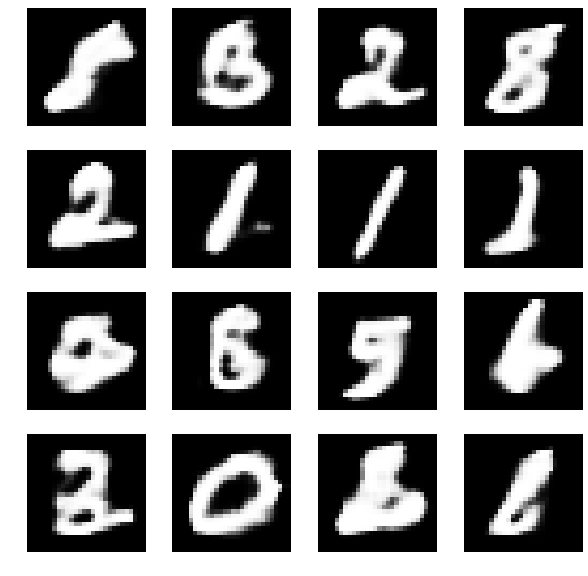

2900: [D loss:0.690856, acc:0.533203] [A loss:0.686884, acc:0.535156]
2901: [D loss:0.715482, acc:0.533203] [A loss:1.009110, acc:0.066406]
2902: [D loss:0.701949, acc:0.511719] [A loss:0.689496, acc:0.519531]
2903: [D loss:0.721142, acc:0.500000] [A loss:0.924508, acc:0.101562]
2904: [D loss:0.700520, acc:0.521484] [A loss:0.738958, acc:0.429688]
2905: [D loss:0.712589, acc:0.494141] [A loss:0.911556, acc:0.140625]
2906: [D loss:0.692655, acc:0.533203] [A loss:0.759887, acc:0.375000]
2907: [D loss:0.710957, acc:0.523438] [A loss:0.888773, acc:0.160156]
2908: [D loss:0.682869, acc:0.560547] [A loss:0.739767, acc:0.433594]
2909: [D loss:0.697204, acc:0.537109] [A loss:0.865962, acc:0.199219]
2910: [D loss:0.698259, acc:0.511719] [A loss:0.744980, acc:0.406250]
2911: [D loss:0.714667, acc:0.515625] [A loss:0.884167, acc:0.121094]
2912: [D loss:0.697783, acc:0.527344] [A loss:0.730183, acc:0.402344]
2913: [D loss:0.696969, acc:0.527344] [A loss:0.953174, acc:0.105469]
2914: [D loss:0.6788

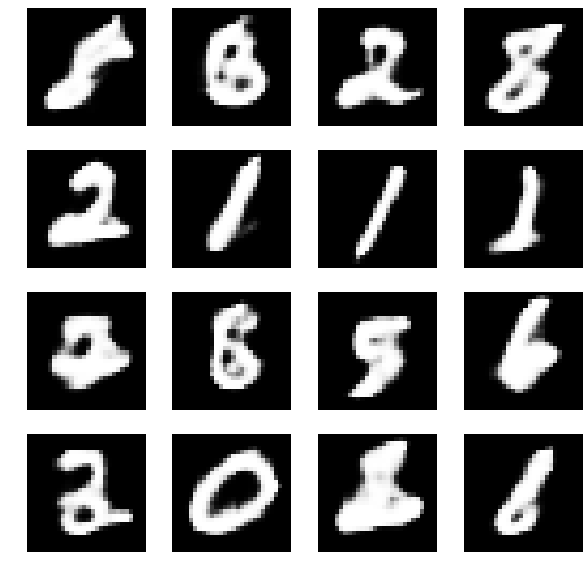

3000: [D loss:0.711386, acc:0.507812] [A loss:0.853549, acc:0.187500]
3001: [D loss:0.695657, acc:0.531250] [A loss:0.783260, acc:0.312500]
3002: [D loss:0.683134, acc:0.535156] [A loss:0.844950, acc:0.191406]
3003: [D loss:0.710247, acc:0.511719] [A loss:0.790391, acc:0.285156]
3004: [D loss:0.703235, acc:0.501953] [A loss:0.963641, acc:0.078125]
3005: [D loss:0.686181, acc:0.550781] [A loss:0.684387, acc:0.519531]
3006: [D loss:0.724635, acc:0.500000] [A loss:0.994437, acc:0.062500]
3007: [D loss:0.698824, acc:0.511719] [A loss:0.645140, acc:0.675781]
3008: [D loss:0.741894, acc:0.498047] [A loss:0.953358, acc:0.085938]
3009: [D loss:0.685331, acc:0.564453] [A loss:0.725421, acc:0.468750]
3010: [D loss:0.716849, acc:0.503906] [A loss:0.834699, acc:0.238281]
3011: [D loss:0.681772, acc:0.574219] [A loss:0.751085, acc:0.406250]
3012: [D loss:0.710783, acc:0.523438] [A loss:0.843122, acc:0.218750]
3013: [D loss:0.688896, acc:0.529297] [A loss:0.779028, acc:0.328125]
3014: [D loss:0.6888

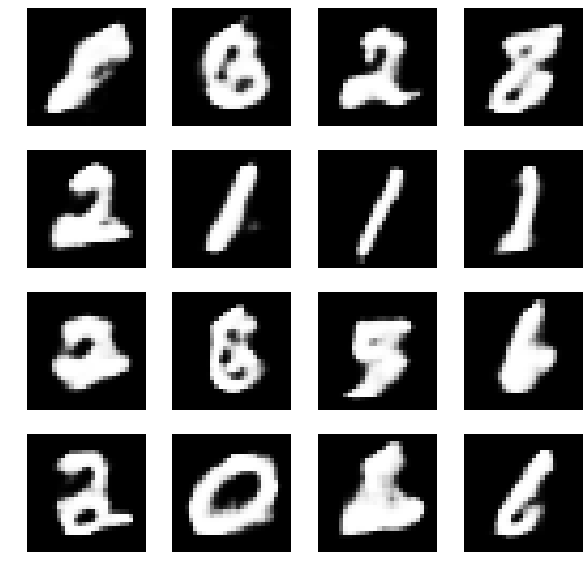

3100: [D loss:0.699952, acc:0.505859] [A loss:0.776948, acc:0.308594]
3101: [D loss:0.713295, acc:0.529297] [A loss:0.882615, acc:0.152344]
3102: [D loss:0.697423, acc:0.541016] [A loss:0.757281, acc:0.371094]
3103: [D loss:0.712735, acc:0.505859] [A loss:0.929729, acc:0.156250]
3104: [D loss:0.690059, acc:0.544922] [A loss:0.668219, acc:0.554688]
3105: [D loss:0.715207, acc:0.527344] [A loss:0.944850, acc:0.148438]
3106: [D loss:0.704515, acc:0.505859] [A loss:0.733265, acc:0.429688]
3107: [D loss:0.702288, acc:0.515625] [A loss:0.883297, acc:0.187500]
3108: [D loss:0.709384, acc:0.509766] [A loss:0.756341, acc:0.367188]
3109: [D loss:0.688934, acc:0.541016] [A loss:0.846965, acc:0.222656]
3110: [D loss:0.697757, acc:0.539062] [A loss:0.776431, acc:0.335938]
3111: [D loss:0.703443, acc:0.511719] [A loss:0.826021, acc:0.261719]
3112: [D loss:0.710958, acc:0.507812] [A loss:0.822513, acc:0.269531]
3113: [D loss:0.681798, acc:0.537109] [A loss:0.864046, acc:0.152344]
3114: [D loss:0.6863

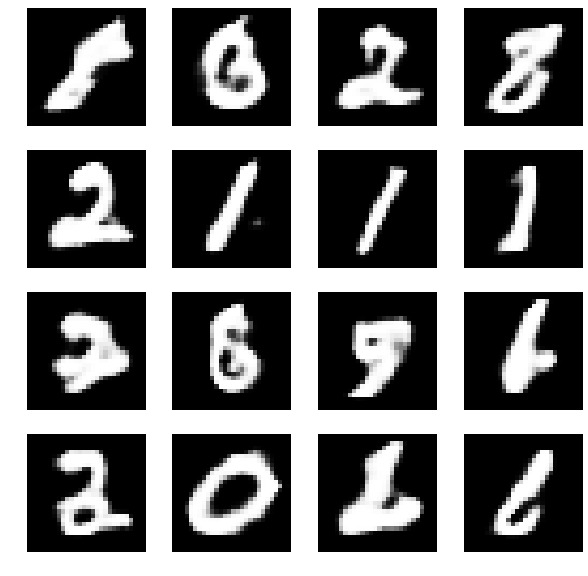

3200: [D loss:0.700997, acc:0.546875] [A loss:0.969619, acc:0.105469]
3201: [D loss:0.699236, acc:0.494141] [A loss:0.653602, acc:0.617188]
3202: [D loss:0.727316, acc:0.527344] [A loss:1.004112, acc:0.062500]
3203: [D loss:0.707130, acc:0.507812] [A loss:0.699505, acc:0.484375]
3204: [D loss:0.731267, acc:0.517578] [A loss:0.906447, acc:0.109375]
3205: [D loss:0.688703, acc:0.544922] [A loss:0.739186, acc:0.421875]
3206: [D loss:0.705252, acc:0.531250] [A loss:0.835673, acc:0.250000]
3207: [D loss:0.686572, acc:0.554688] [A loss:0.783276, acc:0.332031]
3208: [D loss:0.684967, acc:0.537109] [A loss:0.829295, acc:0.226562]
3209: [D loss:0.695857, acc:0.539062] [A loss:0.898902, acc:0.125000]
3210: [D loss:0.701153, acc:0.521484] [A loss:0.813833, acc:0.273438]
3211: [D loss:0.704295, acc:0.515625] [A loss:0.841153, acc:0.253906]
3212: [D loss:0.703663, acc:0.513672] [A loss:0.807391, acc:0.281250]
3213: [D loss:0.713918, acc:0.527344] [A loss:0.819247, acc:0.230469]
3214: [D loss:0.6887

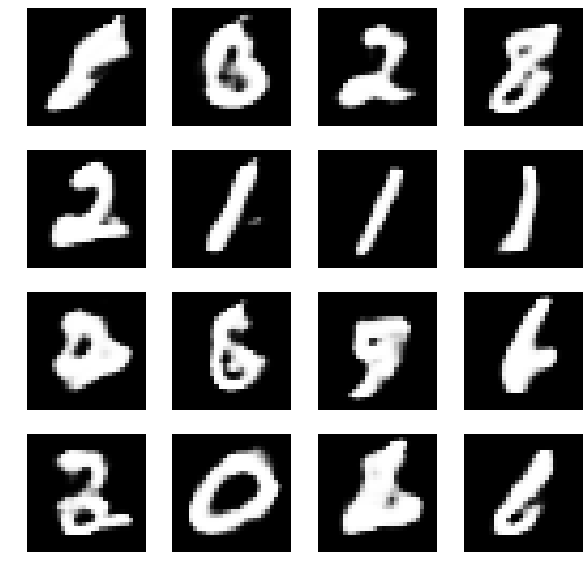

3300: [D loss:0.696446, acc:0.515625] [A loss:0.702920, acc:0.453125]
3301: [D loss:0.704985, acc:0.527344] [A loss:0.947538, acc:0.109375]
3302: [D loss:0.681990, acc:0.585938] [A loss:0.741777, acc:0.406250]
3303: [D loss:0.713151, acc:0.535156] [A loss:0.863641, acc:0.167969]
3304: [D loss:0.690515, acc:0.552734] [A loss:0.740955, acc:0.402344]
3305: [D loss:0.689679, acc:0.531250] [A loss:0.889318, acc:0.183594]
3306: [D loss:0.695239, acc:0.529297] [A loss:0.743709, acc:0.386719]
3307: [D loss:0.702954, acc:0.525391] [A loss:0.876121, acc:0.164062]
3308: [D loss:0.699018, acc:0.511719] [A loss:0.751663, acc:0.359375]
3309: [D loss:0.701512, acc:0.525391] [A loss:0.858273, acc:0.195312]
3310: [D loss:0.697448, acc:0.531250] [A loss:0.804891, acc:0.312500]
3311: [D loss:0.694927, acc:0.541016] [A loss:0.804666, acc:0.273438]
3312: [D loss:0.685734, acc:0.564453] [A loss:0.758093, acc:0.359375]
3313: [D loss:0.706082, acc:0.517578] [A loss:0.876707, acc:0.175781]
3314: [D loss:0.7081

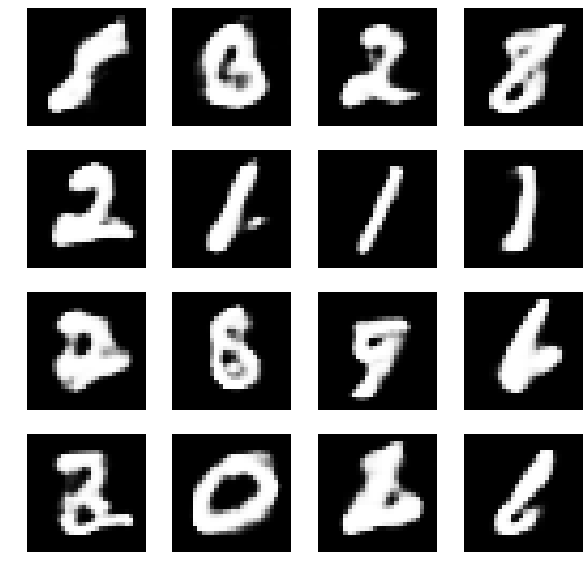

3400: [D loss:0.699157, acc:0.546875] [A loss:0.776485, acc:0.328125]
3401: [D loss:0.705020, acc:0.531250] [A loss:0.803969, acc:0.257812]
3402: [D loss:0.706101, acc:0.509766] [A loss:0.818720, acc:0.246094]
3403: [D loss:0.704285, acc:0.525391] [A loss:0.825092, acc:0.242188]
3404: [D loss:0.698596, acc:0.533203] [A loss:0.747814, acc:0.390625]
3405: [D loss:0.706198, acc:0.525391] [A loss:0.845214, acc:0.183594]
3406: [D loss:0.693208, acc:0.552734] [A loss:0.778010, acc:0.320312]
3407: [D loss:0.705897, acc:0.529297] [A loss:0.834802, acc:0.234375]
3408: [D loss:0.689634, acc:0.541016] [A loss:0.775798, acc:0.320312]
3409: [D loss:0.685212, acc:0.583984] [A loss:0.877897, acc:0.160156]
3410: [D loss:0.692259, acc:0.517578] [A loss:0.733201, acc:0.429688]
3411: [D loss:0.708103, acc:0.527344] [A loss:0.890169, acc:0.132812]
3412: [D loss:0.674155, acc:0.564453] [A loss:0.762035, acc:0.367188]
3413: [D loss:0.724239, acc:0.488281] [A loss:0.906469, acc:0.125000]
3414: [D loss:0.7102

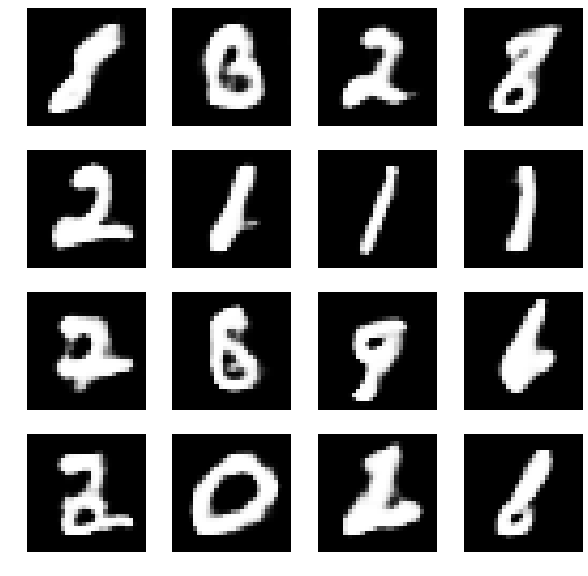

3500: [D loss:0.718305, acc:0.511719] [A loss:0.854065, acc:0.207031]
3501: [D loss:0.686527, acc:0.529297] [A loss:0.729653, acc:0.433594]
3502: [D loss:0.709122, acc:0.513672] [A loss:0.909072, acc:0.148438]
3503: [D loss:0.697328, acc:0.501953] [A loss:0.751971, acc:0.386719]
3504: [D loss:0.689906, acc:0.541016] [A loss:0.840046, acc:0.222656]
3505: [D loss:0.708831, acc:0.501953] [A loss:0.831734, acc:0.226562]
3506: [D loss:0.697406, acc:0.531250] [A loss:0.791665, acc:0.281250]
3507: [D loss:0.705246, acc:0.529297] [A loss:0.761686, acc:0.351562]
3508: [D loss:0.712600, acc:0.503906] [A loss:0.918766, acc:0.105469]
3509: [D loss:0.701009, acc:0.521484] [A loss:0.761296, acc:0.363281]
3510: [D loss:0.708134, acc:0.541016] [A loss:0.871883, acc:0.167969]
3511: [D loss:0.695805, acc:0.544922] [A loss:0.789338, acc:0.269531]
3512: [D loss:0.707229, acc:0.509766] [A loss:0.828588, acc:0.246094]
3513: [D loss:0.694178, acc:0.535156] [A loss:0.776600, acc:0.324219]
3514: [D loss:0.6902

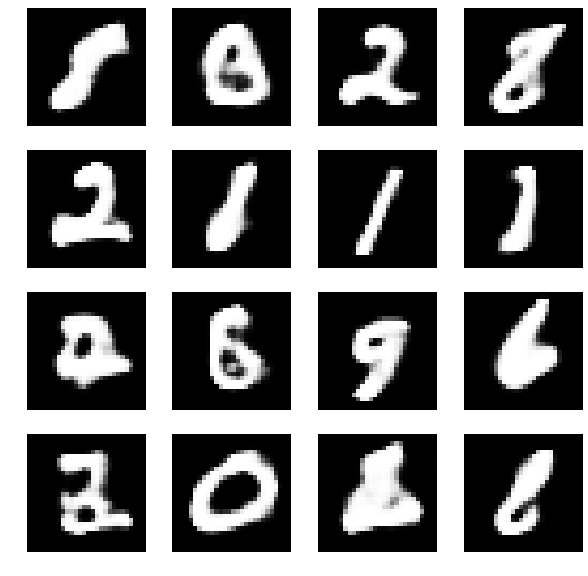

3600: [D loss:0.719305, acc:0.496094] [A loss:0.871650, acc:0.160156]
3601: [D loss:0.704896, acc:0.517578] [A loss:0.779967, acc:0.289062]
3602: [D loss:0.714447, acc:0.517578] [A loss:0.894928, acc:0.140625]
3603: [D loss:0.689671, acc:0.541016] [A loss:0.698071, acc:0.500000]
3604: [D loss:0.715160, acc:0.498047] [A loss:0.880811, acc:0.132812]
3605: [D loss:0.701146, acc:0.531250] [A loss:0.745695, acc:0.378906]
3606: [D loss:0.701205, acc:0.519531] [A loss:0.839068, acc:0.191406]
3607: [D loss:0.696612, acc:0.509766] [A loss:0.729163, acc:0.429688]
3608: [D loss:0.719581, acc:0.515625] [A loss:0.906917, acc:0.136719]
3609: [D loss:0.704935, acc:0.513672] [A loss:0.724924, acc:0.425781]
3610: [D loss:0.704709, acc:0.492188] [A loss:0.870172, acc:0.152344]
3611: [D loss:0.701481, acc:0.511719] [A loss:0.699572, acc:0.503906]
3612: [D loss:0.698108, acc:0.521484] [A loss:0.871406, acc:0.222656]
3613: [D loss:0.694615, acc:0.527344] [A loss:0.723524, acc:0.421875]
3614: [D loss:0.7092

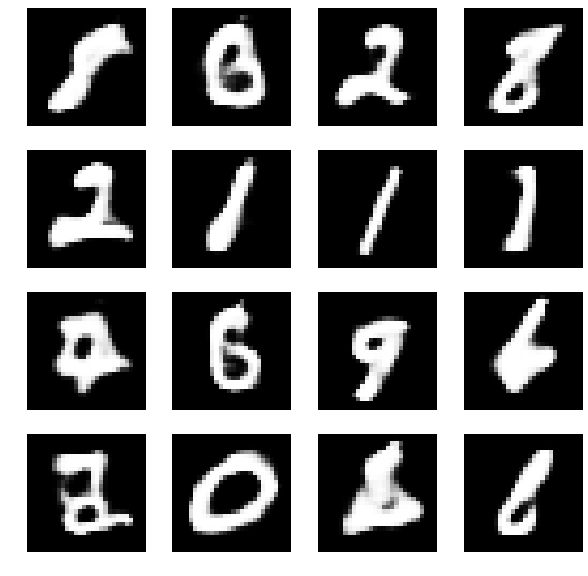

3700: [D loss:0.709058, acc:0.500000] [A loss:0.853029, acc:0.183594]
3701: [D loss:0.709789, acc:0.488281] [A loss:0.729346, acc:0.429688]
3702: [D loss:0.702161, acc:0.519531] [A loss:0.856022, acc:0.179688]
3703: [D loss:0.690780, acc:0.539062] [A loss:0.699638, acc:0.500000]
3704: [D loss:0.720338, acc:0.539062] [A loss:1.055789, acc:0.046875]
3705: [D loss:0.701448, acc:0.494141] [A loss:0.659750, acc:0.613281]
3706: [D loss:0.714995, acc:0.519531] [A loss:0.861382, acc:0.152344]
3707: [D loss:0.702779, acc:0.513672] [A loss:0.774549, acc:0.296875]
3708: [D loss:0.708402, acc:0.496094] [A loss:0.844885, acc:0.214844]
3709: [D loss:0.696251, acc:0.527344] [A loss:0.754221, acc:0.332031]
3710: [D loss:0.690695, acc:0.539062] [A loss:0.803114, acc:0.265625]
3711: [D loss:0.683683, acc:0.570312] [A loss:0.737261, acc:0.421875]
3712: [D loss:0.699869, acc:0.537109] [A loss:0.834530, acc:0.191406]
3713: [D loss:0.706511, acc:0.503906] [A loss:0.777519, acc:0.285156]
3714: [D loss:0.7053

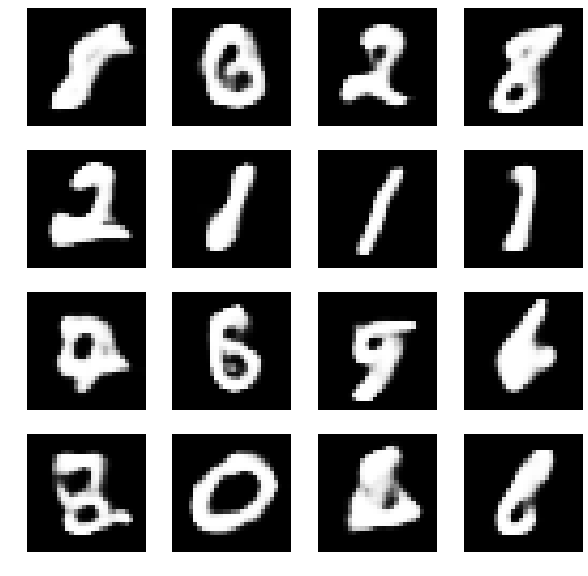

3800: [D loss:0.732241, acc:0.505859] [A loss:1.029763, acc:0.046875]
3801: [D loss:0.693996, acc:0.511719] [A loss:0.676928, acc:0.582031]
3802: [D loss:0.723546, acc:0.500000] [A loss:0.876286, acc:0.148438]
3803: [D loss:0.698219, acc:0.527344] [A loss:0.718181, acc:0.441406]
3804: [D loss:0.707642, acc:0.525391] [A loss:0.804245, acc:0.238281]
3805: [D loss:0.701114, acc:0.515625] [A loss:0.803689, acc:0.234375]
3806: [D loss:0.699930, acc:0.531250] [A loss:0.797151, acc:0.289062]
3807: [D loss:0.695843, acc:0.501953] [A loss:0.765792, acc:0.363281]
3808: [D loss:0.718199, acc:0.488281] [A loss:0.864101, acc:0.191406]
3809: [D loss:0.685526, acc:0.560547] [A loss:0.770624, acc:0.343750]
3810: [D loss:0.724441, acc:0.478516] [A loss:0.876283, acc:0.132812]
3811: [D loss:0.704640, acc:0.500000] [A loss:0.789397, acc:0.308594]
3812: [D loss:0.698773, acc:0.529297] [A loss:0.864390, acc:0.187500]
3813: [D loss:0.705793, acc:0.525391] [A loss:0.755418, acc:0.375000]
3814: [D loss:0.6961

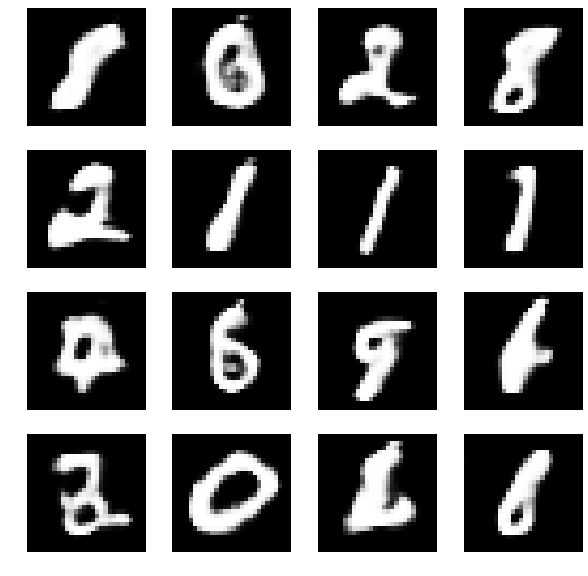

3900: [D loss:0.703652, acc:0.521484] [A loss:0.857319, acc:0.187500]
3901: [D loss:0.688032, acc:0.554688] [A loss:0.738624, acc:0.382812]
3902: [D loss:0.705147, acc:0.537109] [A loss:0.814144, acc:0.230469]
3903: [D loss:0.701800, acc:0.531250] [A loss:0.817934, acc:0.242188]
3904: [D loss:0.693501, acc:0.517578] [A loss:0.818637, acc:0.253906]
3905: [D loss:0.694358, acc:0.535156] [A loss:0.769122, acc:0.328125]
3906: [D loss:0.694984, acc:0.539062] [A loss:0.814629, acc:0.261719]
3907: [D loss:0.698664, acc:0.507812] [A loss:0.786122, acc:0.285156]
3908: [D loss:0.703571, acc:0.486328] [A loss:0.824301, acc:0.234375]
3909: [D loss:0.711020, acc:0.482422] [A loss:0.808629, acc:0.253906]
3910: [D loss:0.698682, acc:0.525391] [A loss:0.858370, acc:0.207031]
3911: [D loss:0.688199, acc:0.548828] [A loss:0.821850, acc:0.246094]
3912: [D loss:0.702294, acc:0.515625] [A loss:0.845448, acc:0.171875]
3913: [D loss:0.715487, acc:0.472656] [A loss:0.926797, acc:0.113281]
3914: [D loss:0.7013

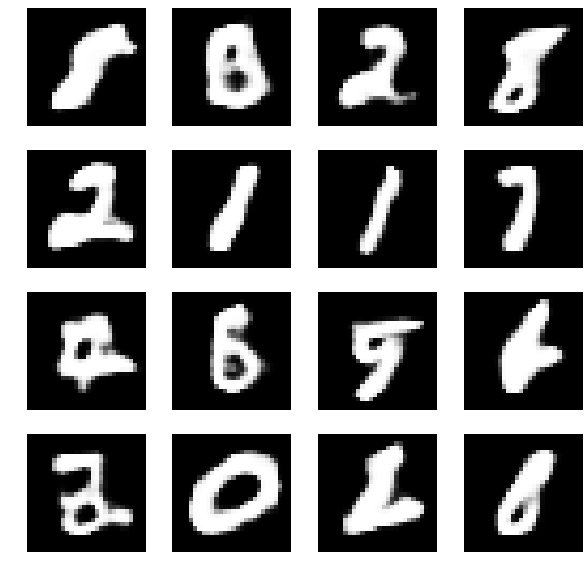

4000: [D loss:0.706993, acc:0.503906] [A loss:0.743836, acc:0.386719]
4001: [D loss:0.707934, acc:0.498047] [A loss:0.856845, acc:0.187500]
4002: [D loss:0.682608, acc:0.564453] [A loss:0.766228, acc:0.332031]
4003: [D loss:0.701628, acc:0.535156] [A loss:0.871853, acc:0.148438]
4004: [D loss:0.689771, acc:0.541016] [A loss:0.810872, acc:0.292969]
4005: [D loss:0.687652, acc:0.562500] [A loss:0.819203, acc:0.253906]
4006: [D loss:0.705769, acc:0.507812] [A loss:0.808810, acc:0.226562]
4007: [D loss:0.700996, acc:0.531250] [A loss:0.932723, acc:0.089844]
4008: [D loss:0.691825, acc:0.537109] [A loss:0.736378, acc:0.394531]
4009: [D loss:0.714209, acc:0.523438] [A loss:0.980274, acc:0.058594]
4010: [D loss:0.691382, acc:0.521484] [A loss:0.629088, acc:0.687500]
4011: [D loss:0.728600, acc:0.513672] [A loss:0.992118, acc:0.062500]
4012: [D loss:0.707984, acc:0.501953] [A loss:0.715820, acc:0.500000]
4013: [D loss:0.705595, acc:0.521484] [A loss:0.832356, acc:0.218750]
4014: [D loss:0.7000

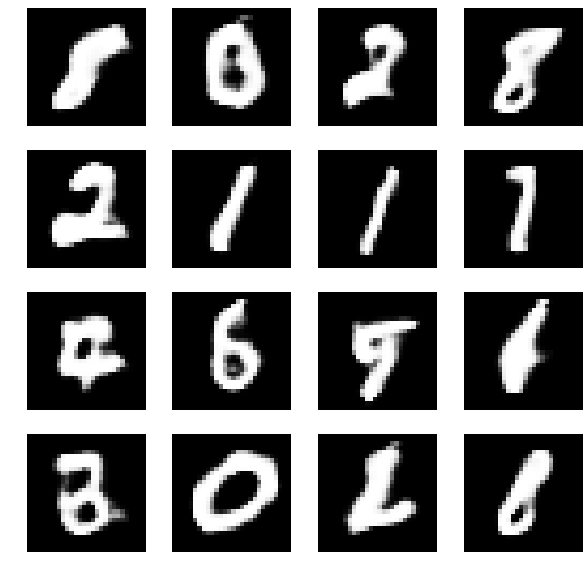

4100: [D loss:0.702943, acc:0.519531] [A loss:0.838978, acc:0.195312]
4101: [D loss:0.711056, acc:0.476562] [A loss:0.789719, acc:0.269531]
4102: [D loss:0.703362, acc:0.492188] [A loss:0.809079, acc:0.230469]
4103: [D loss:0.698200, acc:0.515625] [A loss:0.868977, acc:0.183594]
4104: [D loss:0.699380, acc:0.523438] [A loss:0.777560, acc:0.300781]
4105: [D loss:0.700302, acc:0.511719] [A loss:0.797409, acc:0.289062]
4106: [D loss:0.700698, acc:0.519531] [A loss:0.814319, acc:0.238281]
4107: [D loss:0.700933, acc:0.517578] [A loss:0.787591, acc:0.265625]
4108: [D loss:0.701701, acc:0.525391] [A loss:0.869846, acc:0.136719]
4109: [D loss:0.694381, acc:0.535156] [A loss:0.800051, acc:0.265625]
4110: [D loss:0.700047, acc:0.525391] [A loss:0.855220, acc:0.148438]
4111: [D loss:0.698542, acc:0.523438] [A loss:0.811058, acc:0.234375]
4112: [D loss:0.700224, acc:0.509766] [A loss:0.825291, acc:0.218750]
4113: [D loss:0.700858, acc:0.533203] [A loss:0.799400, acc:0.277344]
4114: [D loss:0.6912

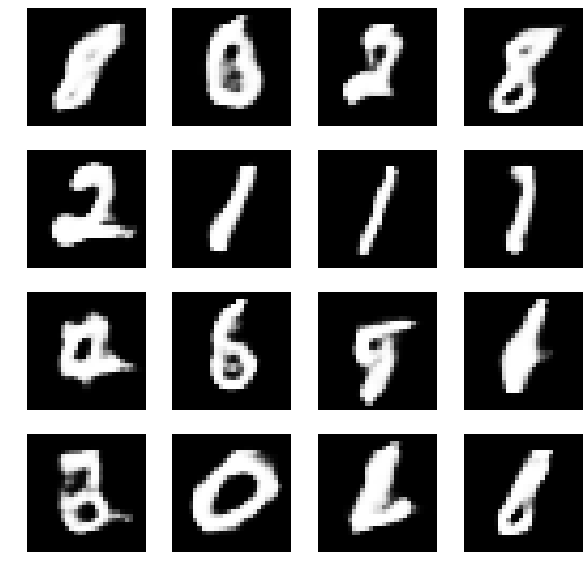

4200: [D loss:0.699120, acc:0.519531] [A loss:0.756419, acc:0.351562]
4201: [D loss:0.681704, acc:0.570312] [A loss:0.790616, acc:0.300781]
4202: [D loss:0.703891, acc:0.531250] [A loss:0.828546, acc:0.265625]
4203: [D loss:0.696107, acc:0.507812] [A loss:0.801861, acc:0.265625]
4204: [D loss:0.697335, acc:0.531250] [A loss:0.833472, acc:0.214844]
4205: [D loss:0.690234, acc:0.537109] [A loss:0.737528, acc:0.421875]
4206: [D loss:0.703080, acc:0.529297] [A loss:0.949669, acc:0.093750]
4207: [D loss:0.703144, acc:0.517578] [A loss:0.693366, acc:0.515625]
4208: [D loss:0.716456, acc:0.509766] [A loss:0.932964, acc:0.113281]
4209: [D loss:0.698832, acc:0.513672] [A loss:0.702596, acc:0.507812]
4210: [D loss:0.712285, acc:0.507812] [A loss:0.889947, acc:0.156250]
4211: [D loss:0.701413, acc:0.505859] [A loss:0.730261, acc:0.390625]
4212: [D loss:0.705921, acc:0.531250] [A loss:0.865194, acc:0.156250]
4213: [D loss:0.693542, acc:0.515625] [A loss:0.750909, acc:0.402344]
4214: [D loss:0.7038

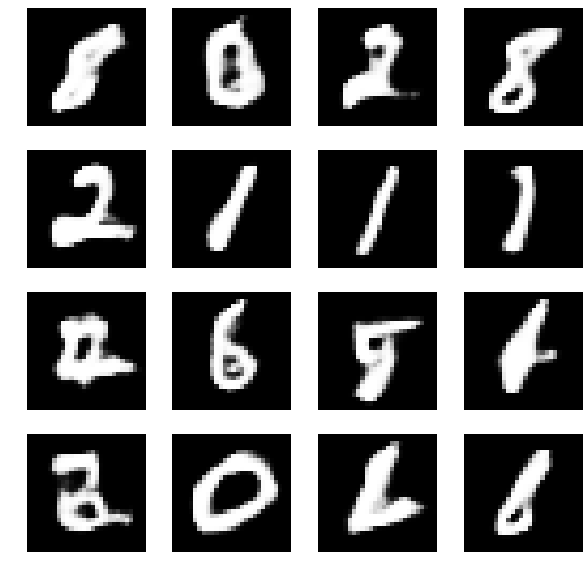

4300: [D loss:0.686876, acc:0.554688] [A loss:0.774850, acc:0.343750]
4301: [D loss:0.706556, acc:0.500000] [A loss:0.761627, acc:0.335938]
4302: [D loss:0.714097, acc:0.500000] [A loss:0.929238, acc:0.078125]
4303: [D loss:0.690289, acc:0.533203] [A loss:0.686010, acc:0.554688]
4304: [D loss:0.723020, acc:0.521484] [A loss:0.954391, acc:0.089844]
4305: [D loss:0.692959, acc:0.507812] [A loss:0.747858, acc:0.390625]
4306: [D loss:0.695264, acc:0.558594] [A loss:0.840023, acc:0.218750]
4307: [D loss:0.698425, acc:0.523438] [A loss:0.777818, acc:0.335938]
4308: [D loss:0.701935, acc:0.537109] [A loss:0.790779, acc:0.292969]
4309: [D loss:0.704597, acc:0.509766] [A loss:0.851914, acc:0.171875]
4310: [D loss:0.689183, acc:0.519531] [A loss:0.708387, acc:0.464844]
4311: [D loss:0.714022, acc:0.505859] [A loss:0.911529, acc:0.117188]
4312: [D loss:0.700212, acc:0.546875] [A loss:0.683630, acc:0.546875]
4313: [D loss:0.699597, acc:0.527344] [A loss:0.897306, acc:0.117188]
4314: [D loss:0.6869

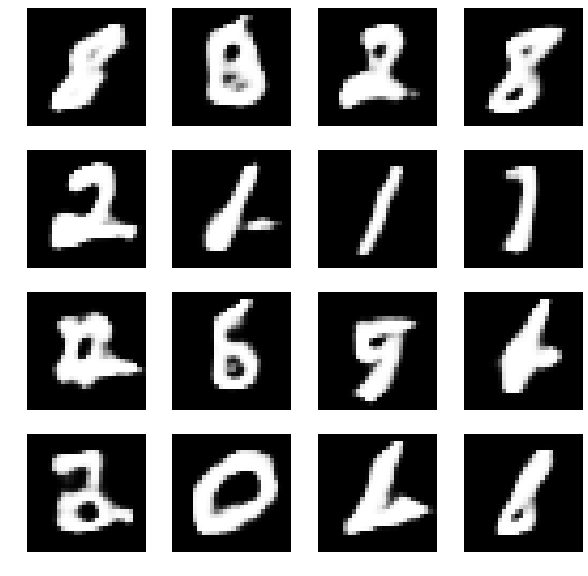

4400: [D loss:0.697759, acc:0.529297] [A loss:0.821095, acc:0.203125]
4401: [D loss:0.707097, acc:0.511719] [A loss:0.787136, acc:0.312500]
4402: [D loss:0.703739, acc:0.505859] [A loss:0.801339, acc:0.281250]
4403: [D loss:0.694624, acc:0.525391] [A loss:0.754450, acc:0.402344]
4404: [D loss:0.711578, acc:0.511719] [A loss:0.893913, acc:0.101562]
4405: [D loss:0.700115, acc:0.503906] [A loss:0.679365, acc:0.601562]
4406: [D loss:0.728989, acc:0.525391] [A loss:0.996189, acc:0.046875]
4407: [D loss:0.689590, acc:0.531250] [A loss:0.691613, acc:0.527344]
4408: [D loss:0.722836, acc:0.496094] [A loss:0.837659, acc:0.191406]
4409: [D loss:0.691013, acc:0.550781] [A loss:0.742192, acc:0.359375]
4410: [D loss:0.711623, acc:0.490234] [A loss:0.829656, acc:0.218750]
4411: [D loss:0.702445, acc:0.501953] [A loss:0.765291, acc:0.335938]
4412: [D loss:0.689565, acc:0.556641] [A loss:0.794118, acc:0.273438]
4413: [D loss:0.691214, acc:0.533203] [A loss:0.749084, acc:0.351562]
4414: [D loss:0.7143

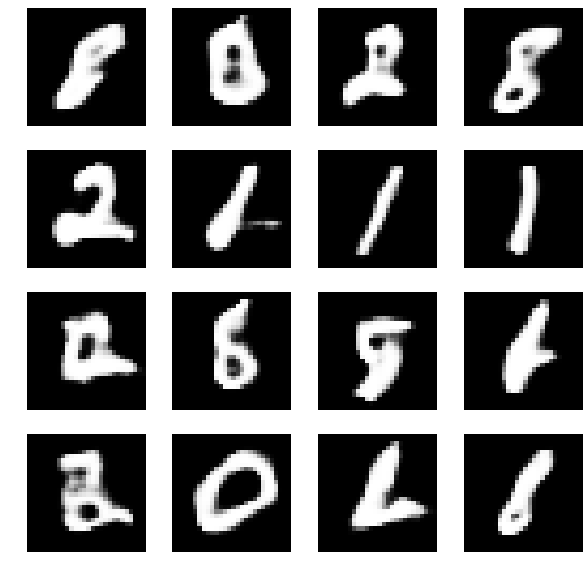

4500: [D loss:0.690152, acc:0.539062] [A loss:0.759000, acc:0.367188]
4501: [D loss:0.709985, acc:0.501953] [A loss:0.895205, acc:0.144531]
4502: [D loss:0.700832, acc:0.523438] [A loss:0.675398, acc:0.566406]
4503: [D loss:0.713208, acc:0.535156] [A loss:0.960640, acc:0.121094]
4504: [D loss:0.697790, acc:0.513672] [A loss:0.724369, acc:0.445312]
4505: [D loss:0.704266, acc:0.523438] [A loss:0.871298, acc:0.152344]
4506: [D loss:0.707934, acc:0.492188] [A loss:0.739335, acc:0.402344]
4507: [D loss:0.709667, acc:0.494141] [A loss:0.906129, acc:0.140625]
4508: [D loss:0.699592, acc:0.492188] [A loss:0.712448, acc:0.460938]
4509: [D loss:0.715522, acc:0.492188] [A loss:0.843885, acc:0.171875]
4510: [D loss:0.701647, acc:0.521484] [A loss:0.792804, acc:0.285156]
4511: [D loss:0.703647, acc:0.498047] [A loss:0.891677, acc:0.144531]
4512: [D loss:0.702991, acc:0.525391] [A loss:0.776747, acc:0.296875]
4513: [D loss:0.700464, acc:0.505859] [A loss:0.876124, acc:0.132812]
4514: [D loss:0.6788

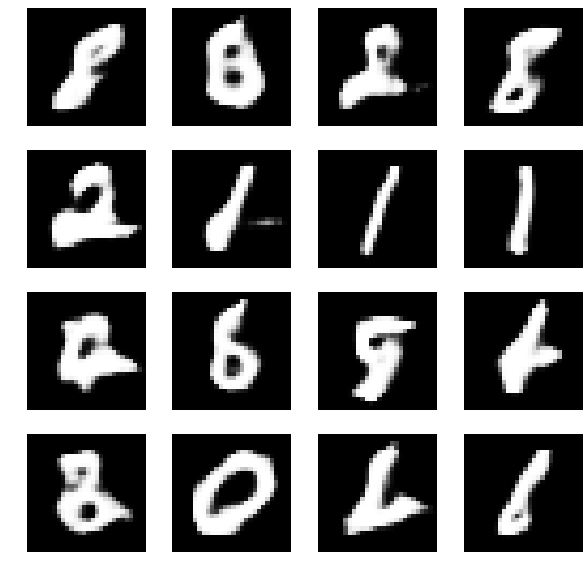

4600: [D loss:0.701878, acc:0.517578] [A loss:0.856965, acc:0.156250]
4601: [D loss:0.698637, acc:0.486328] [A loss:0.802727, acc:0.253906]
4602: [D loss:0.690611, acc:0.539062] [A loss:0.807816, acc:0.250000]
4603: [D loss:0.694051, acc:0.521484] [A loss:0.808018, acc:0.253906]
4604: [D loss:0.700888, acc:0.505859] [A loss:0.780815, acc:0.300781]
4605: [D loss:0.695932, acc:0.511719] [A loss:0.836873, acc:0.199219]
4606: [D loss:0.694633, acc:0.509766] [A loss:0.758709, acc:0.382812]
4607: [D loss:0.697945, acc:0.542969] [A loss:0.966645, acc:0.085938]
4608: [D loss:0.695401, acc:0.519531] [A loss:0.714542, acc:0.460938]
4609: [D loss:0.716935, acc:0.515625] [A loss:0.840378, acc:0.187500]
4610: [D loss:0.702572, acc:0.537109] [A loss:0.739758, acc:0.433594]
4611: [D loss:0.733573, acc:0.482422] [A loss:1.024399, acc:0.031250]
4612: [D loss:0.705356, acc:0.519531] [A loss:0.668120, acc:0.601562]
4613: [D loss:0.704953, acc:0.523438] [A loss:0.825524, acc:0.187500]
4614: [D loss:0.6920

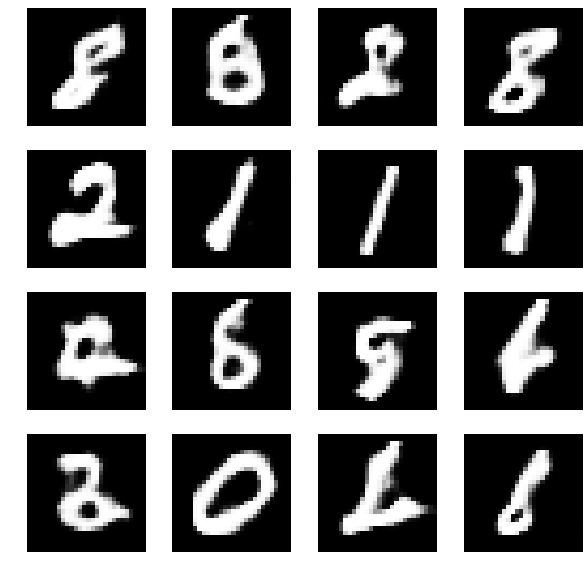

4700: [D loss:0.703641, acc:0.482422] [A loss:0.765346, acc:0.347656]
4701: [D loss:0.693895, acc:0.523438] [A loss:0.812023, acc:0.222656]
4702: [D loss:0.704796, acc:0.503906] [A loss:0.832168, acc:0.214844]
4703: [D loss:0.707717, acc:0.511719] [A loss:0.808605, acc:0.257812]
4704: [D loss:0.701838, acc:0.517578] [A loss:0.878723, acc:0.132812]
4705: [D loss:0.705361, acc:0.488281] [A loss:0.721850, acc:0.464844]
4706: [D loss:0.697515, acc:0.529297] [A loss:0.840196, acc:0.179688]
4707: [D loss:0.702197, acc:0.521484] [A loss:0.766581, acc:0.378906]
4708: [D loss:0.699492, acc:0.531250] [A loss:0.840929, acc:0.218750]
4709: [D loss:0.687362, acc:0.519531] [A loss:0.768242, acc:0.320312]
4710: [D loss:0.707420, acc:0.498047] [A loss:0.871638, acc:0.136719]
4711: [D loss:0.692708, acc:0.556641] [A loss:0.818383, acc:0.246094]
4712: [D loss:0.711503, acc:0.486328] [A loss:0.791148, acc:0.273438]
4713: [D loss:0.698315, acc:0.513672] [A loss:0.862855, acc:0.125000]
4714: [D loss:0.7026

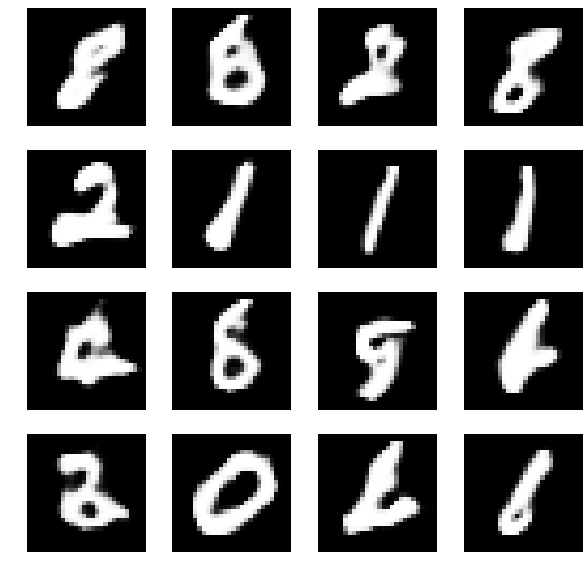

4800: [D loss:0.680747, acc:0.556641] [A loss:0.753052, acc:0.343750]
4801: [D loss:0.712075, acc:0.539062] [A loss:0.942103, acc:0.093750]
4802: [D loss:0.714504, acc:0.460938] [A loss:0.734962, acc:0.417969]
4803: [D loss:0.703357, acc:0.521484] [A loss:0.845022, acc:0.179688]
4804: [D loss:0.703469, acc:0.507812] [A loss:0.731739, acc:0.460938]
4805: [D loss:0.698454, acc:0.542969] [A loss:0.842294, acc:0.175781]
4806: [D loss:0.702690, acc:0.503906] [A loss:0.773970, acc:0.328125]
4807: [D loss:0.710533, acc:0.498047] [A loss:0.854573, acc:0.175781]
4808: [D loss:0.699230, acc:0.521484] [A loss:0.760061, acc:0.343750]
4809: [D loss:0.712431, acc:0.513672] [A loss:0.909037, acc:0.105469]
4810: [D loss:0.700920, acc:0.515625] [A loss:0.678430, acc:0.546875]
4811: [D loss:0.711027, acc:0.513672] [A loss:1.002180, acc:0.050781]
4812: [D loss:0.705658, acc:0.523438] [A loss:0.684947, acc:0.542969]
4813: [D loss:0.727641, acc:0.478516] [A loss:0.828941, acc:0.210938]
4814: [D loss:0.7043

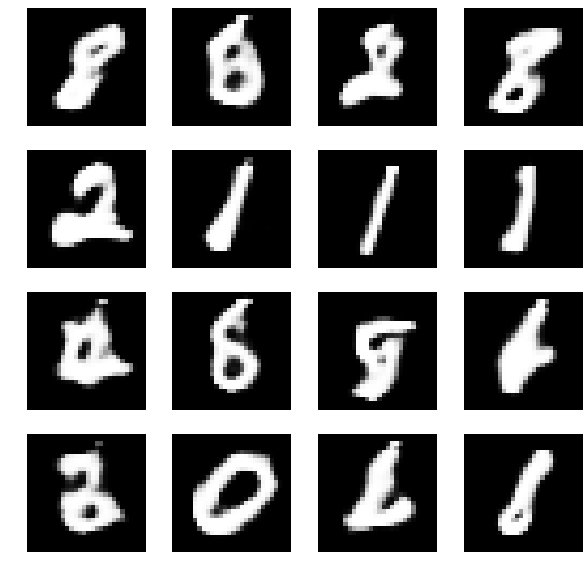

4900: [D loss:0.711178, acc:0.494141] [A loss:0.688028, acc:0.574219]
4901: [D loss:0.729306, acc:0.501953] [A loss:1.025975, acc:0.050781]
4902: [D loss:0.701228, acc:0.527344] [A loss:0.671365, acc:0.570312]
4903: [D loss:0.749928, acc:0.494141] [A loss:0.907176, acc:0.125000]
4904: [D loss:0.713548, acc:0.464844] [A loss:0.707942, acc:0.503906]
4905: [D loss:0.727178, acc:0.490234] [A loss:0.869027, acc:0.171875]
4906: [D loss:0.696422, acc:0.542969] [A loss:0.738947, acc:0.382812]
4907: [D loss:0.708361, acc:0.507812] [A loss:0.812181, acc:0.273438]
4908: [D loss:0.698196, acc:0.535156] [A loss:0.795302, acc:0.253906]
4909: [D loss:0.700055, acc:0.542969] [A loss:0.784968, acc:0.335938]
4910: [D loss:0.708968, acc:0.498047] [A loss:0.792475, acc:0.277344]
4911: [D loss:0.697886, acc:0.513672] [A loss:0.750560, acc:0.355469]
4912: [D loss:0.700054, acc:0.515625] [A loss:0.794473, acc:0.257812]
4913: [D loss:0.691151, acc:0.537109] [A loss:0.786105, acc:0.300781]
4914: [D loss:0.7089

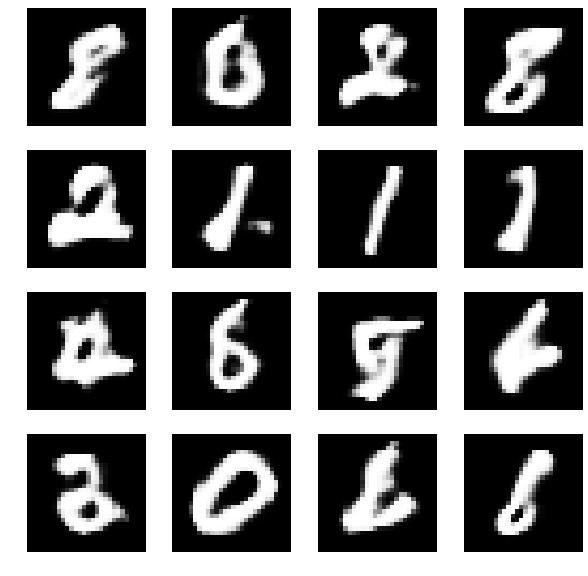

5000: [D loss:0.700871, acc:0.505859] [A loss:0.713821, acc:0.460938]
5001: [D loss:0.719420, acc:0.515625] [A loss:0.917670, acc:0.105469]
5002: [D loss:0.687385, acc:0.566406] [A loss:0.742732, acc:0.421875]
5003: [D loss:0.714059, acc:0.537109] [A loss:0.890746, acc:0.128906]
5004: [D loss:0.691766, acc:0.521484] [A loss:0.698100, acc:0.500000]
5005: [D loss:0.709563, acc:0.523438] [A loss:0.948965, acc:0.089844]
5006: [D loss:0.683789, acc:0.556641] [A loss:0.714444, acc:0.492188]
5007: [D loss:0.724711, acc:0.494141] [A loss:0.869936, acc:0.152344]
5008: [D loss:0.699330, acc:0.501953] [A loss:0.717443, acc:0.417969]
5009: [D loss:0.716762, acc:0.521484] [A loss:0.821186, acc:0.230469]
5010: [D loss:0.709691, acc:0.484375] [A loss:0.733052, acc:0.406250]
5011: [D loss:0.699237, acc:0.527344] [A loss:0.885970, acc:0.136719]
5012: [D loss:0.702364, acc:0.513672] [A loss:0.766887, acc:0.367188]
5013: [D loss:0.707694, acc:0.494141] [A loss:0.784093, acc:0.300781]
5014: [D loss:0.6990

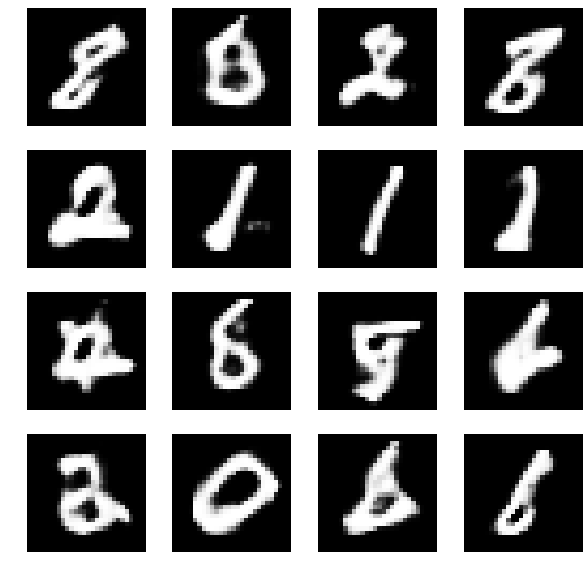

5100: [D loss:0.713376, acc:0.476562] [A loss:0.901219, acc:0.101562]
5101: [D loss:0.694402, acc:0.546875] [A loss:0.755849, acc:0.390625]
5102: [D loss:0.712278, acc:0.503906] [A loss:0.859533, acc:0.187500]
5103: [D loss:0.682697, acc:0.544922] [A loss:0.731562, acc:0.414062]
5104: [D loss:0.717245, acc:0.500000] [A loss:0.893135, acc:0.156250]
5105: [D loss:0.698002, acc:0.517578] [A loss:0.697653, acc:0.507812]
5106: [D loss:0.722160, acc:0.513672] [A loss:0.934798, acc:0.109375]
5107: [D loss:0.702325, acc:0.531250] [A loss:0.707132, acc:0.535156]
5108: [D loss:0.701214, acc:0.521484] [A loss:0.833928, acc:0.203125]
5109: [D loss:0.702198, acc:0.542969] [A loss:0.807633, acc:0.312500]
5110: [D loss:0.704644, acc:0.513672] [A loss:0.880066, acc:0.136719]
5111: [D loss:0.692607, acc:0.525391] [A loss:0.709503, acc:0.476562]
5112: [D loss:0.702633, acc:0.531250] [A loss:0.900480, acc:0.105469]
5113: [D loss:0.696890, acc:0.519531] [A loss:0.718614, acc:0.468750]
5114: [D loss:0.7256

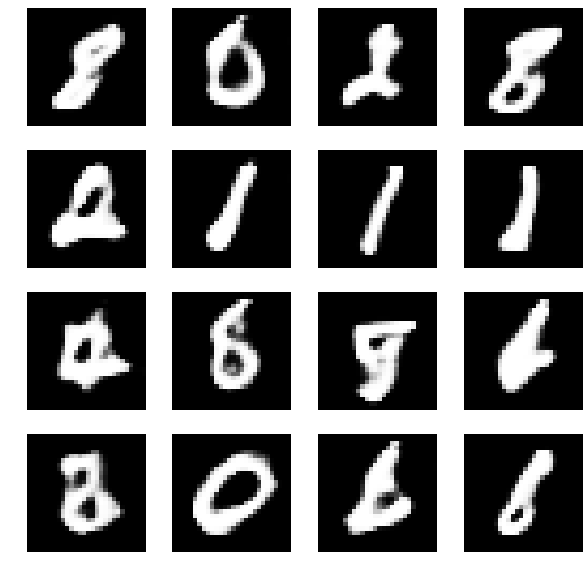

5200: [D loss:0.709109, acc:0.505859] [A loss:0.724755, acc:0.476562]
5201: [D loss:0.704890, acc:0.527344] [A loss:0.919725, acc:0.117188]
5202: [D loss:0.698154, acc:0.548828] [A loss:0.704642, acc:0.472656]
5203: [D loss:0.711295, acc:0.527344] [A loss:0.827770, acc:0.242188]
5204: [D loss:0.691860, acc:0.546875] [A loss:0.755018, acc:0.386719]
5205: [D loss:0.697748, acc:0.529297] [A loss:0.816609, acc:0.269531]
5206: [D loss:0.690828, acc:0.521484] [A loss:0.729173, acc:0.472656]
5207: [D loss:0.691775, acc:0.548828] [A loss:0.916656, acc:0.085938]
5208: [D loss:0.693034, acc:0.529297] [A loss:0.738890, acc:0.417969]
5209: [D loss:0.700813, acc:0.511719] [A loss:0.945969, acc:0.082031]
5210: [D loss:0.702347, acc:0.496094] [A loss:0.690635, acc:0.523438]
5211: [D loss:0.714907, acc:0.523438] [A loss:0.971300, acc:0.093750]
5212: [D loss:0.699514, acc:0.500000] [A loss:0.684489, acc:0.562500]
5213: [D loss:0.699513, acc:0.533203] [A loss:0.840141, acc:0.226562]
5214: [D loss:0.6867

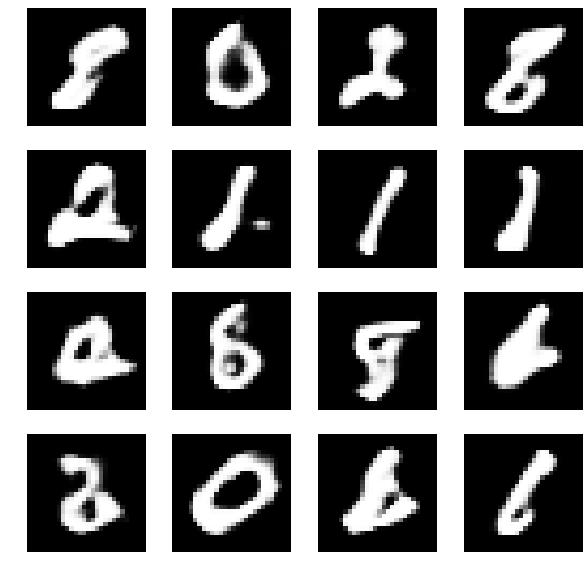

5300: [D loss:0.699477, acc:0.525391] [A loss:0.759768, acc:0.371094]
5301: [D loss:0.703312, acc:0.529297] [A loss:0.876251, acc:0.167969]
5302: [D loss:0.696960, acc:0.501953] [A loss:0.833244, acc:0.179688]
5303: [D loss:0.706944, acc:0.505859] [A loss:0.899013, acc:0.121094]
5304: [D loss:0.687269, acc:0.568359] [A loss:0.770081, acc:0.316406]
5305: [D loss:0.704916, acc:0.531250] [A loss:0.926880, acc:0.121094]
5306: [D loss:0.691066, acc:0.533203] [A loss:0.666300, acc:0.558594]
5307: [D loss:0.733651, acc:0.503906] [A loss:1.008044, acc:0.066406]
5308: [D loss:0.695780, acc:0.519531] [A loss:0.679467, acc:0.546875]
5309: [D loss:0.739192, acc:0.482422] [A loss:0.831343, acc:0.218750]
5310: [D loss:0.699711, acc:0.513672] [A loss:0.829715, acc:0.238281]
5311: [D loss:0.699034, acc:0.500000] [A loss:0.790447, acc:0.269531]
5312: [D loss:0.713961, acc:0.505859] [A loss:0.794373, acc:0.285156]
5313: [D loss:0.695322, acc:0.548828] [A loss:0.856377, acc:0.210938]
5314: [D loss:0.7076

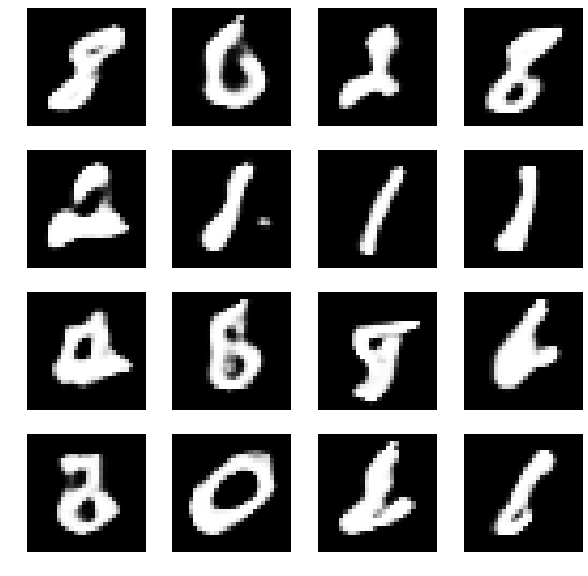

5400: [D loss:0.696331, acc:0.503906] [A loss:0.732474, acc:0.425781]
5401: [D loss:0.713424, acc:0.509766] [A loss:0.879797, acc:0.156250]
5402: [D loss:0.696687, acc:0.505859] [A loss:0.698986, acc:0.539062]
5403: [D loss:0.708889, acc:0.525391] [A loss:0.878358, acc:0.179688]
5404: [D loss:0.706473, acc:0.521484] [A loss:0.725991, acc:0.433594]
5405: [D loss:0.708195, acc:0.529297] [A loss:0.891587, acc:0.160156]
5406: [D loss:0.681659, acc:0.546875] [A loss:0.734581, acc:0.433594]
5407: [D loss:0.701206, acc:0.546875] [A loss:0.877340, acc:0.183594]
5408: [D loss:0.698677, acc:0.515625] [A loss:0.760109, acc:0.363281]
5409: [D loss:0.701132, acc:0.529297] [A loss:0.844588, acc:0.175781]
5410: [D loss:0.681128, acc:0.576172] [A loss:0.747218, acc:0.417969]
5411: [D loss:0.697997, acc:0.513672] [A loss:0.840655, acc:0.246094]
5412: [D loss:0.694468, acc:0.546875] [A loss:0.805366, acc:0.300781]
5413: [D loss:0.700198, acc:0.533203] [A loss:0.915324, acc:0.109375]
5414: [D loss:0.6915

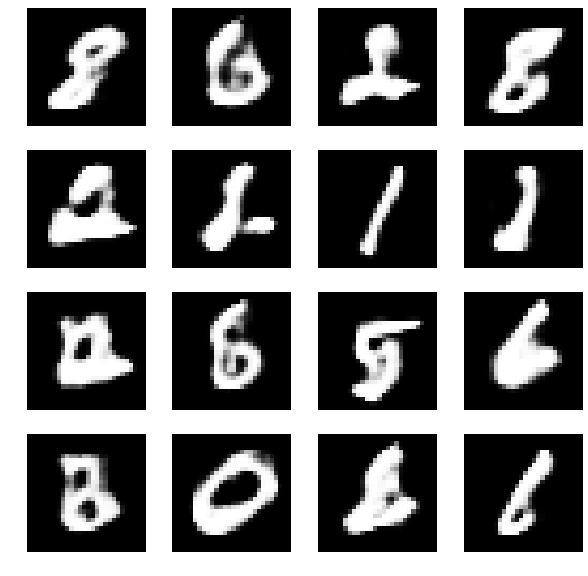

5500: [D loss:0.700487, acc:0.500000] [A loss:0.728661, acc:0.441406]
5501: [D loss:0.721339, acc:0.486328] [A loss:0.881889, acc:0.191406]
5502: [D loss:0.724593, acc:0.490234] [A loss:0.760606, acc:0.339844]
5503: [D loss:0.679411, acc:0.554688] [A loss:0.747810, acc:0.382812]
5504: [D loss:0.715581, acc:0.490234] [A loss:0.919976, acc:0.121094]
5505: [D loss:0.707349, acc:0.494141] [A loss:0.728500, acc:0.421875]
5506: [D loss:0.716597, acc:0.513672] [A loss:0.856661, acc:0.199219]
5507: [D loss:0.701061, acc:0.529297] [A loss:0.863756, acc:0.226562]
5508: [D loss:0.709101, acc:0.503906] [A loss:0.727130, acc:0.468750]
5509: [D loss:0.704602, acc:0.517578] [A loss:0.866716, acc:0.203125]
5510: [D loss:0.695185, acc:0.542969] [A loss:0.714703, acc:0.484375]
5511: [D loss:0.694093, acc:0.531250] [A loss:0.918785, acc:0.121094]
5512: [D loss:0.687735, acc:0.539062] [A loss:0.723550, acc:0.464844]
5513: [D loss:0.694395, acc:0.519531] [A loss:0.892217, acc:0.160156]
5514: [D loss:0.6922

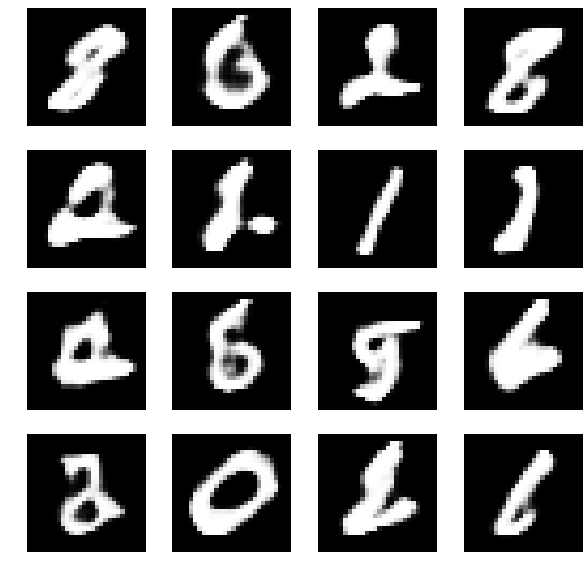

5600: [D loss:0.697361, acc:0.535156] [A loss:0.730587, acc:0.406250]
5601: [D loss:0.680175, acc:0.564453] [A loss:0.888445, acc:0.218750]
5602: [D loss:0.709765, acc:0.488281] [A loss:0.855758, acc:0.199219]
5603: [D loss:0.688380, acc:0.537109] [A loss:0.734579, acc:0.437500]
5604: [D loss:0.723987, acc:0.494141] [A loss:0.914778, acc:0.097656]
5605: [D loss:0.685869, acc:0.531250] [A loss:0.702692, acc:0.500000]
5606: [D loss:0.721234, acc:0.492188] [A loss:0.911573, acc:0.113281]
5607: [D loss:0.691927, acc:0.539062] [A loss:0.691410, acc:0.523438]
5608: [D loss:0.706380, acc:0.527344] [A loss:0.873858, acc:0.144531]
5609: [D loss:0.687559, acc:0.531250] [A loss:0.715160, acc:0.457031]
5610: [D loss:0.699161, acc:0.531250] [A loss:0.894731, acc:0.132812]
5611: [D loss:0.697069, acc:0.507812] [A loss:0.736240, acc:0.410156]
5612: [D loss:0.704552, acc:0.521484] [A loss:0.831681, acc:0.230469]
5613: [D loss:0.708430, acc:0.494141] [A loss:0.779610, acc:0.324219]
5614: [D loss:0.7073

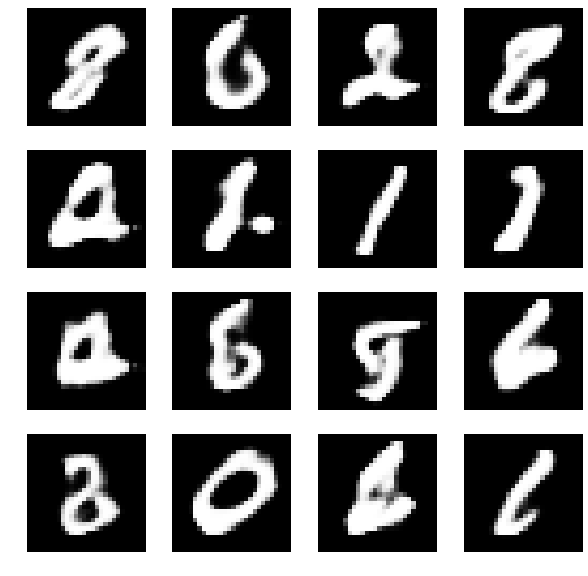

5700: [D loss:0.695711, acc:0.505859] [A loss:0.718191, acc:0.480469]
5701: [D loss:0.712378, acc:0.513672] [A loss:0.948376, acc:0.125000]
5702: [D loss:0.706805, acc:0.501953] [A loss:0.668265, acc:0.601562]
5703: [D loss:0.727193, acc:0.513672] [A loss:0.913338, acc:0.156250]
5704: [D loss:0.691754, acc:0.554688] [A loss:0.689961, acc:0.542969]
5705: [D loss:0.736406, acc:0.494141] [A loss:0.877536, acc:0.152344]
5706: [D loss:0.698138, acc:0.558594] [A loss:0.706072, acc:0.519531]
5707: [D loss:0.716628, acc:0.507812] [A loss:0.968433, acc:0.085938]
5708: [D loss:0.710530, acc:0.484375] [A loss:0.672854, acc:0.582031]
5709: [D loss:0.733306, acc:0.519531] [A loss:0.858041, acc:0.203125]
5710: [D loss:0.692387, acc:0.527344] [A loss:0.736314, acc:0.441406]
5711: [D loss:0.708408, acc:0.519531] [A loss:0.836338, acc:0.191406]
5712: [D loss:0.683606, acc:0.552734] [A loss:0.787437, acc:0.339844]
5713: [D loss:0.700218, acc:0.525391] [A loss:0.804816, acc:0.285156]
5714: [D loss:0.6995

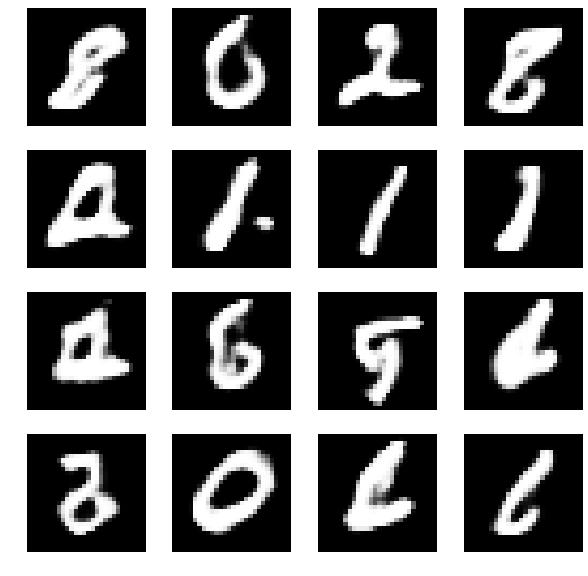

5800: [D loss:0.688209, acc:0.570312] [A loss:0.701595, acc:0.507812]
5801: [D loss:0.698353, acc:0.519531] [A loss:0.881613, acc:0.132812]
5802: [D loss:0.707780, acc:0.498047] [A loss:0.742103, acc:0.394531]
5803: [D loss:0.716946, acc:0.505859] [A loss:0.926241, acc:0.175781]
5804: [D loss:0.701381, acc:0.537109] [A loss:0.727752, acc:0.429688]
5805: [D loss:0.698223, acc:0.523438] [A loss:0.906714, acc:0.125000]
5806: [D loss:0.707447, acc:0.515625] [A loss:0.750445, acc:0.398438]
5807: [D loss:0.710041, acc:0.519531] [A loss:0.871534, acc:0.156250]
5808: [D loss:0.697505, acc:0.531250] [A loss:0.732947, acc:0.402344]
5809: [D loss:0.709599, acc:0.509766] [A loss:0.948307, acc:0.097656]
5810: [D loss:0.694944, acc:0.548828] [A loss:0.689887, acc:0.488281]
5811: [D loss:0.702588, acc:0.527344] [A loss:0.865995, acc:0.175781]
5812: [D loss:0.683984, acc:0.523438] [A loss:0.723524, acc:0.437500]
5813: [D loss:0.710960, acc:0.527344] [A loss:0.850516, acc:0.238281]
5814: [D loss:0.7091

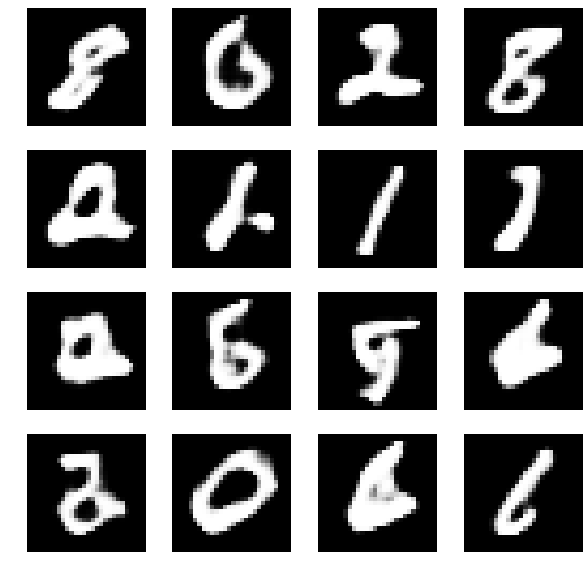

5900: [D loss:0.704397, acc:0.511719] [A loss:0.776386, acc:0.308594]
5901: [D loss:0.706717, acc:0.507812] [A loss:0.881640, acc:0.183594]
5902: [D loss:0.698333, acc:0.513672] [A loss:0.737229, acc:0.417969]
5903: [D loss:0.698528, acc:0.541016] [A loss:0.877700, acc:0.144531]
5904: [D loss:0.698509, acc:0.548828] [A loss:0.729262, acc:0.437500]
5905: [D loss:0.724812, acc:0.500000] [A loss:0.973409, acc:0.070312]
5906: [D loss:0.716495, acc:0.486328] [A loss:0.732973, acc:0.429688]
5907: [D loss:0.707994, acc:0.525391] [A loss:1.025064, acc:0.066406]
5908: [D loss:0.684133, acc:0.537109] [A loss:0.685898, acc:0.542969]
5909: [D loss:0.712557, acc:0.511719] [A loss:0.886201, acc:0.148438]
5910: [D loss:0.702962, acc:0.501953] [A loss:0.726388, acc:0.421875]
5911: [D loss:0.701272, acc:0.523438] [A loss:0.793565, acc:0.277344]
5912: [D loss:0.692688, acc:0.546875] [A loss:0.859097, acc:0.226562]
5913: [D loss:0.689116, acc:0.548828] [A loss:0.725277, acc:0.472656]
5914: [D loss:0.7133

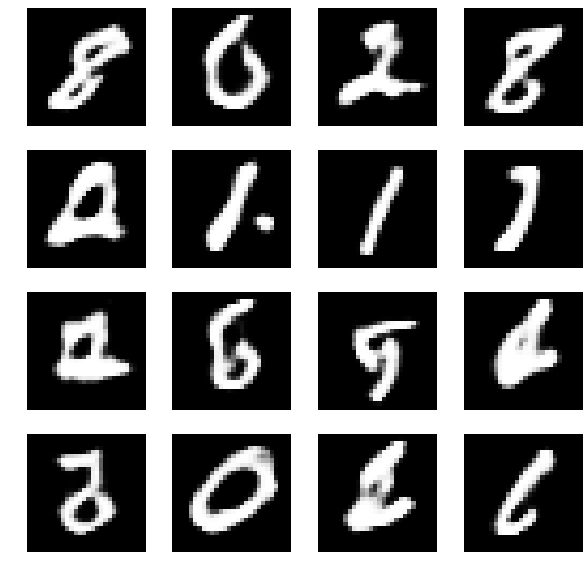

6000: [D loss:0.698194, acc:0.527344] [A loss:0.833394, acc:0.246094]
6001: [D loss:0.697343, acc:0.523438] [A loss:0.843069, acc:0.222656]
6002: [D loss:0.691453, acc:0.537109] [A loss:0.802452, acc:0.304688]
6003: [D loss:0.701058, acc:0.507812] [A loss:0.845212, acc:0.199219]
6004: [D loss:0.708339, acc:0.509766] [A loss:0.770148, acc:0.328125]
6005: [D loss:0.708302, acc:0.509766] [A loss:0.835556, acc:0.179688]
6006: [D loss:0.709270, acc:0.480469] [A loss:0.843944, acc:0.257812]
6007: [D loss:0.703237, acc:0.496094] [A loss:0.751776, acc:0.429688]
6008: [D loss:0.698068, acc:0.527344] [A loss:0.872938, acc:0.207031]
6009: [D loss:0.695595, acc:0.525391] [A loss:0.742181, acc:0.425781]
6010: [D loss:0.704218, acc:0.513672] [A loss:0.895531, acc:0.144531]
6011: [D loss:0.696220, acc:0.539062] [A loss:0.734948, acc:0.425781]
6012: [D loss:0.705189, acc:0.548828] [A loss:0.998074, acc:0.070312]
6013: [D loss:0.703342, acc:0.521484] [A loss:0.647462, acc:0.636719]
6014: [D loss:0.7171

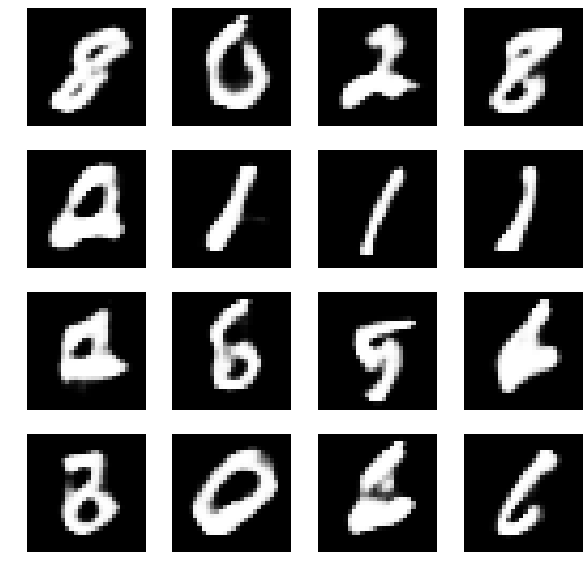

6100: [D loss:0.698331, acc:0.476562] [A loss:0.714576, acc:0.492188]
6101: [D loss:0.709875, acc:0.505859] [A loss:0.859522, acc:0.167969]
6102: [D loss:0.707316, acc:0.501953] [A loss:0.739518, acc:0.394531]
6103: [D loss:0.696395, acc:0.519531] [A loss:0.864982, acc:0.144531]
6104: [D loss:0.692642, acc:0.529297] [A loss:0.724223, acc:0.464844]
6105: [D loss:0.698386, acc:0.546875] [A loss:0.864803, acc:0.207031]
6106: [D loss:0.698887, acc:0.539062] [A loss:0.752113, acc:0.375000]
6107: [D loss:0.709967, acc:0.527344] [A loss:0.941792, acc:0.113281]
6108: [D loss:0.695761, acc:0.527344] [A loss:0.704732, acc:0.492188]
6109: [D loss:0.702841, acc:0.527344] [A loss:0.837765, acc:0.210938]
6110: [D loss:0.697094, acc:0.521484] [A loss:0.755202, acc:0.398438]
6111: [D loss:0.702578, acc:0.537109] [A loss:0.955802, acc:0.117188]
6112: [D loss:0.704626, acc:0.509766] [A loss:0.696694, acc:0.500000]
6113: [D loss:0.713884, acc:0.501953] [A loss:0.920683, acc:0.125000]
6114: [D loss:0.6866

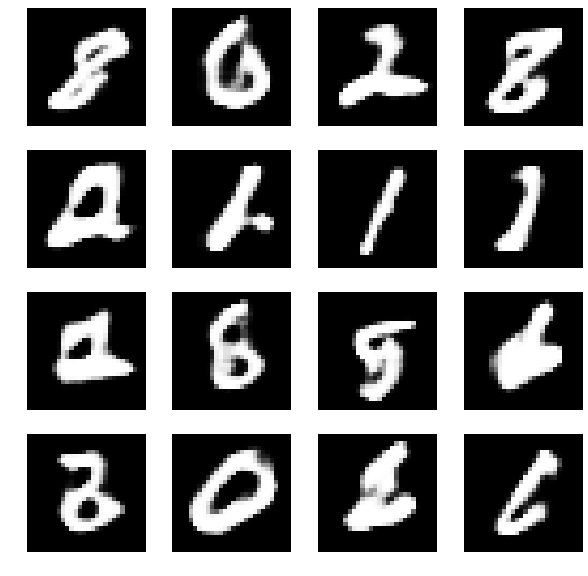

6200: [D loss:0.689063, acc:0.546875] [A loss:0.827206, acc:0.238281]
6201: [D loss:0.695115, acc:0.539062] [A loss:0.829119, acc:0.226562]
6202: [D loss:0.698765, acc:0.501953] [A loss:0.774537, acc:0.285156]
6203: [D loss:0.694867, acc:0.546875] [A loss:0.836269, acc:0.203125]
6204: [D loss:0.711154, acc:0.498047] [A loss:0.807000, acc:0.214844]
6205: [D loss:0.695236, acc:0.552734] [A loss:0.833808, acc:0.214844]
6206: [D loss:0.698940, acc:0.505859] [A loss:0.808180, acc:0.242188]
6207: [D loss:0.699425, acc:0.515625] [A loss:0.749447, acc:0.359375]
6208: [D loss:0.704893, acc:0.527344] [A loss:0.851629, acc:0.167969]
6209: [D loss:0.697715, acc:0.544922] [A loss:0.744713, acc:0.378906]
6210: [D loss:0.704215, acc:0.509766] [A loss:0.883545, acc:0.179688]
6211: [D loss:0.695626, acc:0.513672] [A loss:0.727939, acc:0.421875]
6212: [D loss:0.710692, acc:0.515625] [A loss:0.949438, acc:0.089844]
6213: [D loss:0.700491, acc:0.494141] [A loss:0.658677, acc:0.609375]
6214: [D loss:0.7254

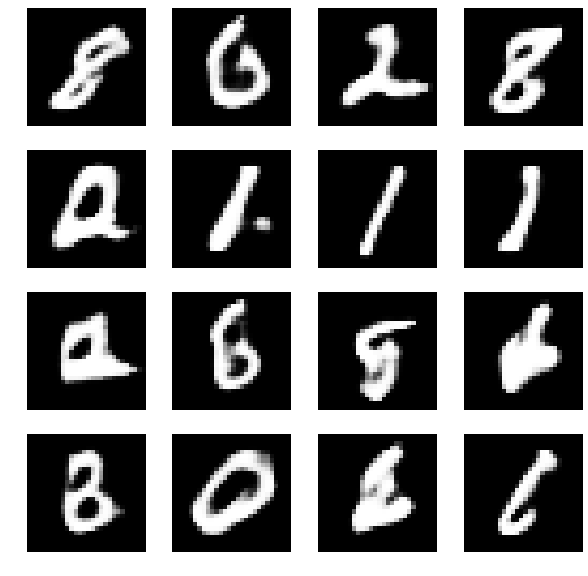

6300: [D loss:0.692333, acc:0.546875] [A loss:0.781544, acc:0.312500]
6301: [D loss:0.710952, acc:0.476562] [A loss:0.771875, acc:0.332031]
6302: [D loss:0.714122, acc:0.496094] [A loss:0.991746, acc:0.066406]
6303: [D loss:0.700157, acc:0.492188] [A loss:0.713921, acc:0.472656]
6304: [D loss:0.705712, acc:0.503906] [A loss:0.864190, acc:0.152344]
6305: [D loss:0.707716, acc:0.509766] [A loss:0.715173, acc:0.468750]
6306: [D loss:0.695576, acc:0.523438] [A loss:0.838945, acc:0.230469]
6307: [D loss:0.686610, acc:0.541016] [A loss:0.680303, acc:0.554688]
6308: [D loss:0.733543, acc:0.494141] [A loss:0.961584, acc:0.097656]
6309: [D loss:0.706400, acc:0.513672] [A loss:0.778083, acc:0.343750]
6310: [D loss:0.710466, acc:0.500000] [A loss:0.750396, acc:0.390625]
6311: [D loss:0.710515, acc:0.529297] [A loss:0.829670, acc:0.226562]
6312: [D loss:0.714456, acc:0.484375] [A loss:0.779270, acc:0.300781]
6313: [D loss:0.717918, acc:0.505859] [A loss:0.813358, acc:0.199219]
6314: [D loss:0.6996

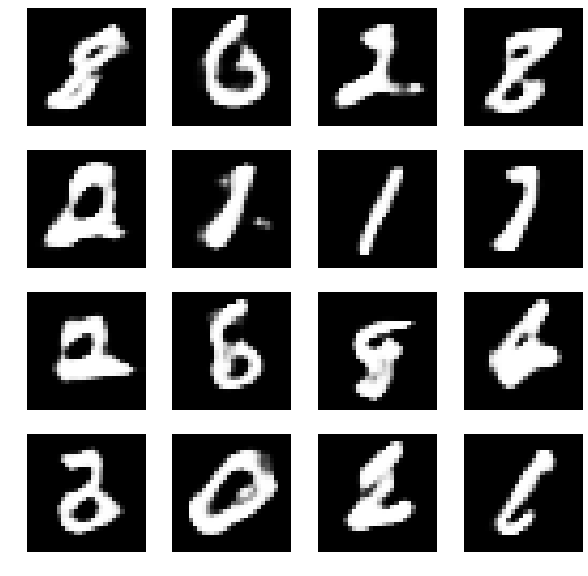

6400: [D loss:0.722176, acc:0.503906] [A loss:0.854358, acc:0.187500]
6401: [D loss:0.707833, acc:0.501953] [A loss:0.753483, acc:0.378906]
6402: [D loss:0.707470, acc:0.507812] [A loss:0.875390, acc:0.164062]
6403: [D loss:0.681311, acc:0.560547] [A loss:0.722394, acc:0.476562]
6404: [D loss:0.718057, acc:0.496094] [A loss:0.828882, acc:0.230469]
6405: [D loss:0.690902, acc:0.552734] [A loss:0.741625, acc:0.382812]
6406: [D loss:0.699333, acc:0.533203] [A loss:0.826023, acc:0.218750]
6407: [D loss:0.694926, acc:0.509766] [A loss:0.772882, acc:0.367188]
6408: [D loss:0.724463, acc:0.478516] [A loss:1.003171, acc:0.074219]
6409: [D loss:0.701225, acc:0.523438] [A loss:0.713767, acc:0.492188]
6410: [D loss:0.702785, acc:0.529297] [A loss:0.808363, acc:0.257812]
6411: [D loss:0.699808, acc:0.525391] [A loss:0.794071, acc:0.320312]
6412: [D loss:0.707899, acc:0.507812] [A loss:0.770310, acc:0.332031]
6413: [D loss:0.706942, acc:0.521484] [A loss:0.841754, acc:0.148438]
6414: [D loss:0.6957

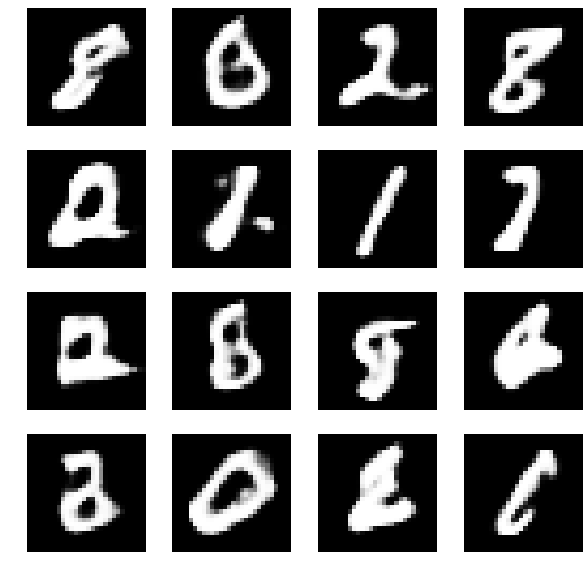

6500: [D loss:0.704683, acc:0.539062] [A loss:0.815664, acc:0.214844]
6501: [D loss:0.700112, acc:0.501953] [A loss:0.755534, acc:0.382812]
6502: [D loss:0.718845, acc:0.472656] [A loss:0.897243, acc:0.109375]
6503: [D loss:0.705751, acc:0.509766] [A loss:0.705622, acc:0.449219]
6504: [D loss:0.694047, acc:0.541016] [A loss:0.822867, acc:0.218750]
6505: [D loss:0.693933, acc:0.548828] [A loss:0.732426, acc:0.410156]
6506: [D loss:0.697250, acc:0.521484] [A loss:0.785410, acc:0.273438]
6507: [D loss:0.706809, acc:0.505859] [A loss:0.842328, acc:0.222656]
6508: [D loss:0.696588, acc:0.525391] [A loss:0.752959, acc:0.429688]
6509: [D loss:0.701478, acc:0.517578] [A loss:0.841929, acc:0.179688]
6510: [D loss:0.700683, acc:0.535156] [A loss:0.732222, acc:0.433594]
6511: [D loss:0.712503, acc:0.498047] [A loss:0.966880, acc:0.054688]
6512: [D loss:0.699731, acc:0.517578] [A loss:0.690903, acc:0.511719]
6513: [D loss:0.696552, acc:0.537109] [A loss:0.804590, acc:0.257812]
6514: [D loss:0.7014

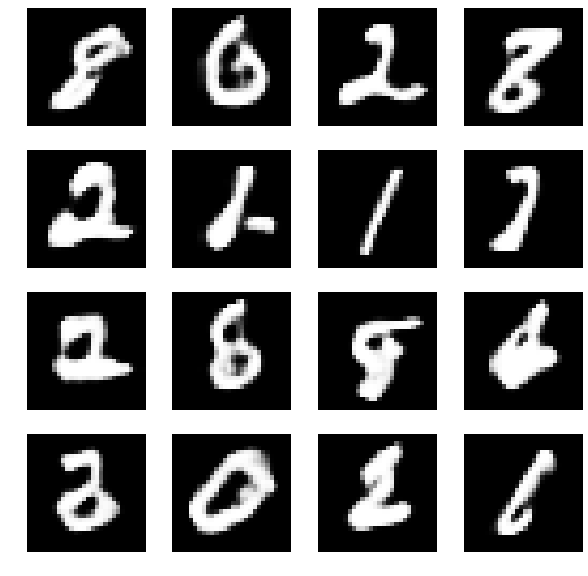

6600: [D loss:0.696599, acc:0.537109] [A loss:0.853755, acc:0.160156]
6601: [D loss:0.696469, acc:0.513672] [A loss:0.786418, acc:0.300781]
6602: [D loss:0.683973, acc:0.541016] [A loss:0.838031, acc:0.195312]
6603: [D loss:0.705113, acc:0.517578] [A loss:0.728787, acc:0.429688]
6604: [D loss:0.706247, acc:0.523438] [A loss:0.837208, acc:0.183594]
6605: [D loss:0.691754, acc:0.546875] [A loss:0.738747, acc:0.402344]
6606: [D loss:0.697486, acc:0.535156] [A loss:0.838235, acc:0.187500]
6607: [D loss:0.703160, acc:0.486328] [A loss:0.725947, acc:0.441406]
6608: [D loss:0.700741, acc:0.523438] [A loss:0.831711, acc:0.183594]
6609: [D loss:0.691646, acc:0.580078] [A loss:0.755586, acc:0.335938]
6610: [D loss:0.712061, acc:0.488281] [A loss:0.849192, acc:0.195312]
6611: [D loss:0.696912, acc:0.511719] [A loss:0.935853, acc:0.093750]
6612: [D loss:0.696625, acc:0.542969] [A loss:0.724819, acc:0.398438]
6613: [D loss:0.695189, acc:0.533203] [A loss:0.925183, acc:0.128906]
6614: [D loss:0.7035

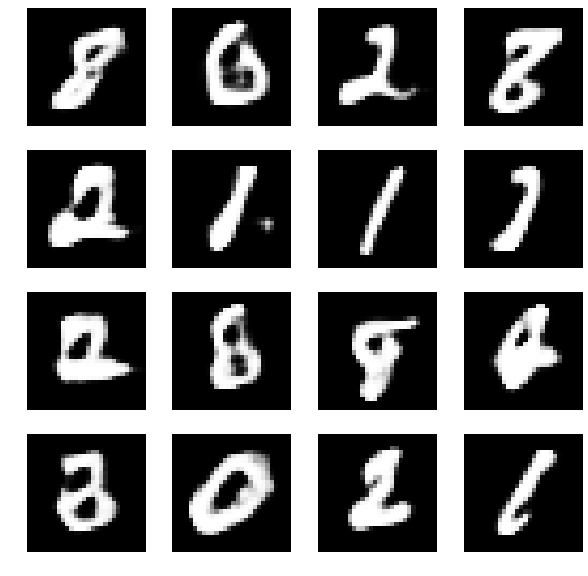

6700: [D loss:0.686781, acc:0.556641] [A loss:0.769680, acc:0.320312]
6701: [D loss:0.702039, acc:0.533203] [A loss:0.803784, acc:0.273438]
6702: [D loss:0.704997, acc:0.525391] [A loss:0.858318, acc:0.199219]
6703: [D loss:0.713157, acc:0.488281] [A loss:0.781877, acc:0.296875]
6704: [D loss:0.698852, acc:0.519531] [A loss:0.809594, acc:0.242188]
6705: [D loss:0.686770, acc:0.523438] [A loss:0.767060, acc:0.339844]
6706: [D loss:0.708207, acc:0.501953] [A loss:0.882674, acc:0.144531]
6707: [D loss:0.696558, acc:0.505859] [A loss:0.693616, acc:0.542969]
6708: [D loss:0.700736, acc:0.531250] [A loss:0.860325, acc:0.171875]
6709: [D loss:0.702967, acc:0.503906] [A loss:0.758299, acc:0.328125]
6710: [D loss:0.704966, acc:0.505859] [A loss:0.816734, acc:0.226562]
6711: [D loss:0.697411, acc:0.519531] [A loss:0.796775, acc:0.296875]
6712: [D loss:0.692163, acc:0.550781] [A loss:0.834986, acc:0.214844]
6713: [D loss:0.696341, acc:0.509766] [A loss:0.783733, acc:0.316406]
6714: [D loss:0.7019

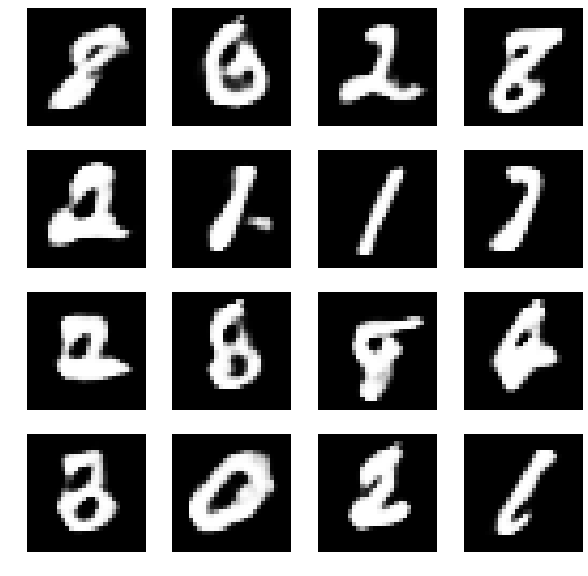

6800: [D loss:0.704456, acc:0.515625] [A loss:0.872928, acc:0.140625]
6801: [D loss:0.698832, acc:0.511719] [A loss:0.691675, acc:0.503906]
6802: [D loss:0.703582, acc:0.519531] [A loss:0.826376, acc:0.257812]
6803: [D loss:0.697290, acc:0.542969] [A loss:0.767807, acc:0.367188]
6804: [D loss:0.703644, acc:0.511719] [A loss:0.800525, acc:0.257812]
6805: [D loss:0.695404, acc:0.525391] [A loss:0.785273, acc:0.300781]
6806: [D loss:0.699750, acc:0.517578] [A loss:0.777159, acc:0.312500]
6807: [D loss:0.685907, acc:0.544922] [A loss:0.837941, acc:0.203125]
6808: [D loss:0.695313, acc:0.521484] [A loss:0.768734, acc:0.304688]
6809: [D loss:0.698223, acc:0.496094] [A loss:0.772144, acc:0.324219]
6810: [D loss:0.693339, acc:0.523438] [A loss:0.803921, acc:0.261719]
6811: [D loss:0.697545, acc:0.513672] [A loss:0.810918, acc:0.253906]
6812: [D loss:0.697046, acc:0.542969] [A loss:0.784191, acc:0.410156]
6813: [D loss:0.717937, acc:0.515625] [A loss:0.969944, acc:0.101562]
6814: [D loss:0.7227

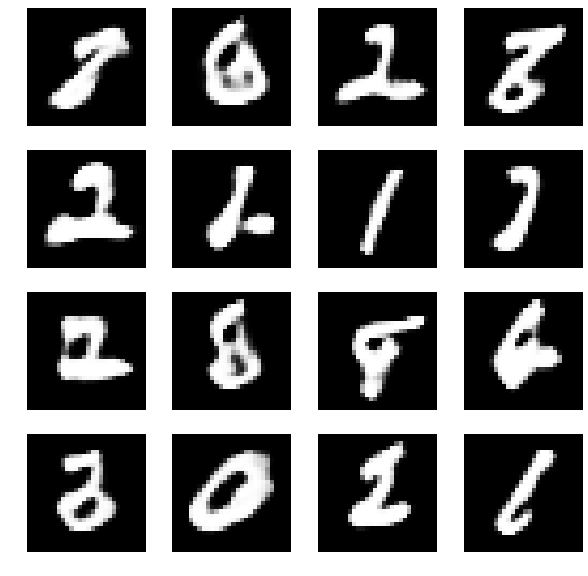

6900: [D loss:0.716428, acc:0.509766] [A loss:0.850571, acc:0.179688]
6901: [D loss:0.704449, acc:0.517578] [A loss:0.770002, acc:0.343750]
6902: [D loss:0.699678, acc:0.517578] [A loss:0.829589, acc:0.222656]
6903: [D loss:0.705243, acc:0.490234] [A loss:0.774911, acc:0.343750]
6904: [D loss:0.693096, acc:0.548828] [A loss:0.812306, acc:0.230469]
6905: [D loss:0.707346, acc:0.486328] [A loss:0.811034, acc:0.265625]
6906: [D loss:0.696655, acc:0.535156] [A loss:0.862376, acc:0.167969]
6907: [D loss:0.688584, acc:0.548828] [A loss:0.760683, acc:0.332031]
6908: [D loss:0.708930, acc:0.515625] [A loss:0.848808, acc:0.183594]
6909: [D loss:0.697921, acc:0.539062] [A loss:0.761422, acc:0.339844]
6910: [D loss:0.703657, acc:0.552734] [A loss:0.768757, acc:0.320312]
6911: [D loss:0.696808, acc:0.529297] [A loss:0.826221, acc:0.222656]
6912: [D loss:0.691218, acc:0.556641] [A loss:0.782645, acc:0.332031]
6913: [D loss:0.694411, acc:0.546875] [A loss:0.889600, acc:0.136719]
6914: [D loss:0.7100

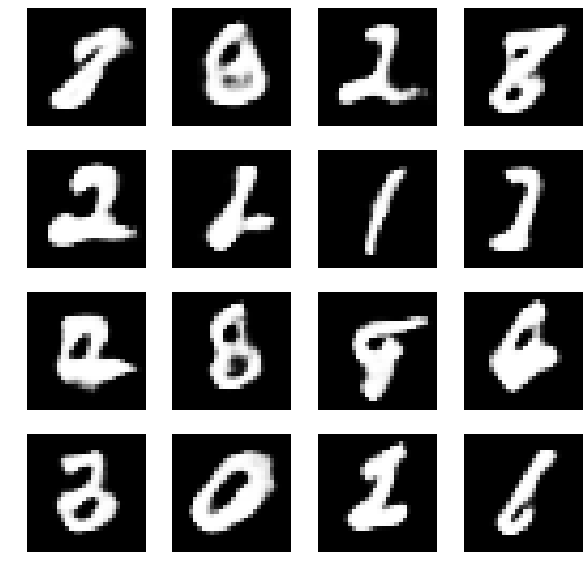

7000: [D loss:0.697885, acc:0.521484] [A loss:0.709294, acc:0.472656]
7001: [D loss:0.699191, acc:0.521484] [A loss:0.843927, acc:0.187500]
7002: [D loss:0.706217, acc:0.492188] [A loss:0.719919, acc:0.449219]
7003: [D loss:0.712280, acc:0.525391] [A loss:0.878293, acc:0.179688]
7004: [D loss:0.700003, acc:0.501953] [A loss:0.695192, acc:0.503906]
7005: [D loss:0.725965, acc:0.505859] [A loss:0.891260, acc:0.113281]
7006: [D loss:0.709652, acc:0.498047] [A loss:0.749257, acc:0.367188]
7007: [D loss:0.717014, acc:0.509766] [A loss:0.818289, acc:0.257812]
7008: [D loss:0.699300, acc:0.517578] [A loss:0.767469, acc:0.382812]
7009: [D loss:0.718815, acc:0.505859] [A loss:0.843132, acc:0.175781]
7010: [D loss:0.690704, acc:0.531250] [A loss:0.822926, acc:0.234375]
7011: [D loss:0.695658, acc:0.539062] [A loss:0.780675, acc:0.328125]
7012: [D loss:0.693332, acc:0.531250] [A loss:0.858037, acc:0.187500]
7013: [D loss:0.703399, acc:0.560547] [A loss:0.799906, acc:0.289062]
7014: [D loss:0.7160

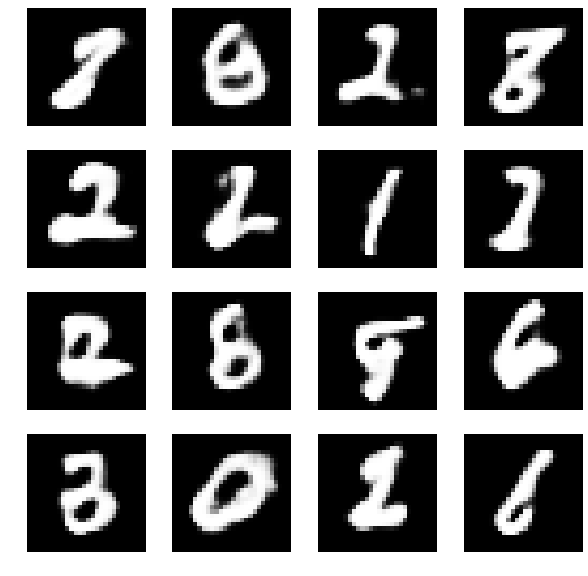

7100: [D loss:0.707623, acc:0.498047] [A loss:0.814283, acc:0.273438]
7101: [D loss:0.707539, acc:0.523438] [A loss:0.787214, acc:0.289062]
7102: [D loss:0.698929, acc:0.505859] [A loss:0.922117, acc:0.109375]
7103: [D loss:0.694649, acc:0.531250] [A loss:0.707854, acc:0.500000]
7104: [D loss:0.701248, acc:0.542969] [A loss:0.837672, acc:0.218750]
7105: [D loss:0.693148, acc:0.529297] [A loss:0.792260, acc:0.296875]
7106: [D loss:0.701741, acc:0.515625] [A loss:0.739552, acc:0.386719]
7107: [D loss:0.698443, acc:0.533203] [A loss:0.916288, acc:0.132812]
7108: [D loss:0.703260, acc:0.533203] [A loss:0.707578, acc:0.496094]
7109: [D loss:0.713949, acc:0.511719] [A loss:0.913479, acc:0.093750]
7110: [D loss:0.698779, acc:0.548828] [A loss:0.714107, acc:0.519531]
7111: [D loss:0.701382, acc:0.523438] [A loss:0.833078, acc:0.203125]
7112: [D loss:0.689527, acc:0.558594] [A loss:0.739118, acc:0.390625]
7113: [D loss:0.715620, acc:0.498047] [A loss:0.830320, acc:0.222656]
7114: [D loss:0.6806

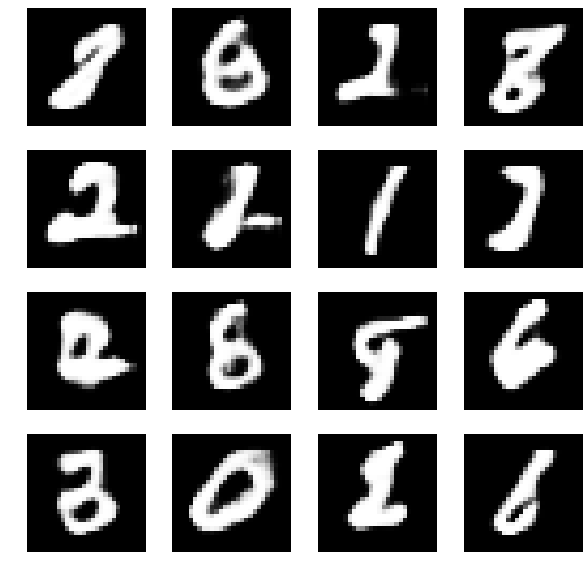

7200: [D loss:0.703296, acc:0.503906] [A loss:0.764701, acc:0.332031]
7201: [D loss:0.710575, acc:0.498047] [A loss:0.847358, acc:0.207031]
7202: [D loss:0.698761, acc:0.513672] [A loss:0.713872, acc:0.460938]
7203: [D loss:0.715053, acc:0.498047] [A loss:0.927400, acc:0.097656]
7204: [D loss:0.699384, acc:0.535156] [A loss:0.740513, acc:0.390625]
7205: [D loss:0.699121, acc:0.550781] [A loss:0.790271, acc:0.277344]
7206: [D loss:0.694062, acc:0.494141] [A loss:0.763933, acc:0.371094]
7207: [D loss:0.715744, acc:0.488281] [A loss:0.783610, acc:0.316406]
7208: [D loss:0.705430, acc:0.507812] [A loss:0.778376, acc:0.292969]
7209: [D loss:0.692198, acc:0.550781] [A loss:0.784917, acc:0.296875]
7210: [D loss:0.709448, acc:0.490234] [A loss:0.818401, acc:0.250000]
7211: [D loss:0.702630, acc:0.507812] [A loss:0.701404, acc:0.496094]
7212: [D loss:0.721426, acc:0.511719] [A loss:0.950260, acc:0.105469]
7213: [D loss:0.712152, acc:0.482422] [A loss:0.837277, acc:0.269531]
7214: [D loss:0.7070

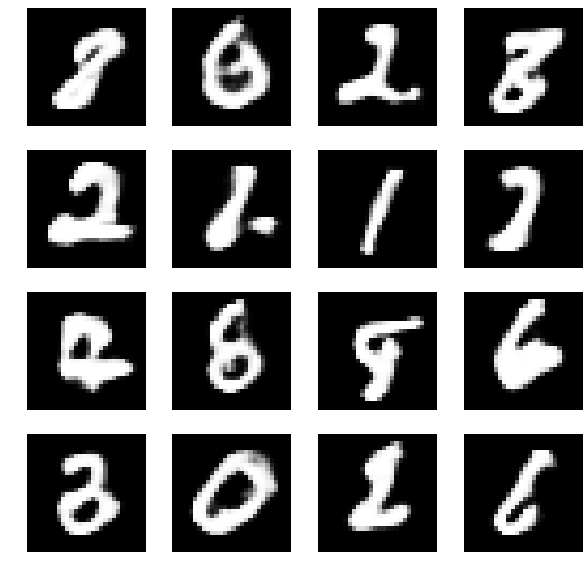

7300: [D loss:0.698205, acc:0.494141] [A loss:0.845583, acc:0.191406]
7301: [D loss:0.697162, acc:0.521484] [A loss:0.795384, acc:0.281250]
7302: [D loss:0.702910, acc:0.521484] [A loss:0.846327, acc:0.199219]
7303: [D loss:0.698869, acc:0.500000] [A loss:0.702391, acc:0.480469]
7304: [D loss:0.713444, acc:0.515625] [A loss:0.838978, acc:0.222656]
7305: [D loss:0.695672, acc:0.531250] [A loss:0.730819, acc:0.410156]
7306: [D loss:0.717612, acc:0.515625] [A loss:0.891030, acc:0.140625]
7307: [D loss:0.697339, acc:0.515625] [A loss:0.730827, acc:0.425781]
7308: [D loss:0.722494, acc:0.503906] [A loss:0.896955, acc:0.097656]
7309: [D loss:0.698242, acc:0.498047] [A loss:0.746379, acc:0.382812]
7310: [D loss:0.708133, acc:0.523438] [A loss:0.850928, acc:0.218750]
7311: [D loss:0.693314, acc:0.515625] [A loss:0.737797, acc:0.421875]
7312: [D loss:0.698803, acc:0.546875] [A loss:0.804363, acc:0.289062]
7313: [D loss:0.712020, acc:0.503906] [A loss:0.782255, acc:0.328125]
7314: [D loss:0.6965

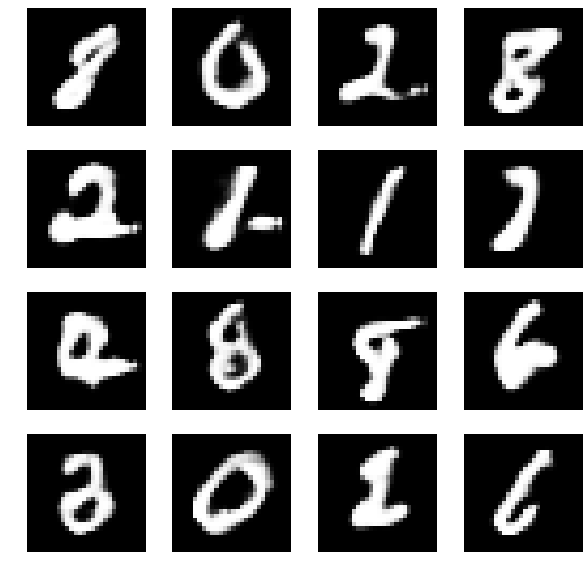

7400: [D loss:0.693030, acc:0.527344] [A loss:0.824225, acc:0.253906]
7401: [D loss:0.691233, acc:0.542969] [A loss:0.822353, acc:0.226562]
7402: [D loss:0.683336, acc:0.591797] [A loss:0.862597, acc:0.167969]
7403: [D loss:0.705192, acc:0.517578] [A loss:0.776502, acc:0.328125]
7404: [D loss:0.718397, acc:0.521484] [A loss:0.934344, acc:0.089844]
7405: [D loss:0.700138, acc:0.513672] [A loss:0.670351, acc:0.589844]
7406: [D loss:0.712159, acc:0.523438] [A loss:0.866741, acc:0.183594]
7407: [D loss:0.693628, acc:0.544922] [A loss:0.689803, acc:0.527344]
7408: [D loss:0.717392, acc:0.535156] [A loss:0.871893, acc:0.179688]
7409: [D loss:0.695400, acc:0.525391] [A loss:0.778803, acc:0.316406]
7410: [D loss:0.698046, acc:0.527344] [A loss:0.822731, acc:0.257812]
7411: [D loss:0.711557, acc:0.498047] [A loss:0.799963, acc:0.277344]
7412: [D loss:0.696631, acc:0.529297] [A loss:0.732243, acc:0.410156]
7413: [D loss:0.715831, acc:0.531250] [A loss:0.826690, acc:0.179688]
7414: [D loss:0.6943

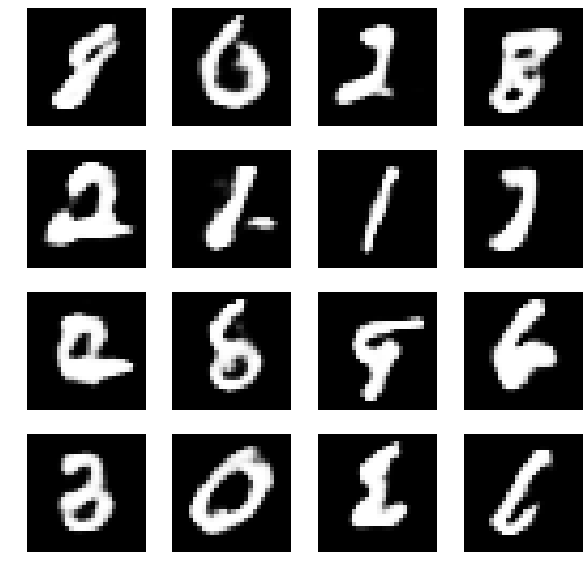

7500: [D loss:0.710870, acc:0.535156] [A loss:0.928770, acc:0.097656]
7501: [D loss:0.694911, acc:0.544922] [A loss:0.702979, acc:0.488281]
7502: [D loss:0.722169, acc:0.496094] [A loss:0.918172, acc:0.128906]
7503: [D loss:0.700118, acc:0.486328] [A loss:0.695297, acc:0.511719]
7504: [D loss:0.705696, acc:0.511719] [A loss:0.825535, acc:0.230469]
7505: [D loss:0.695683, acc:0.529297] [A loss:0.754434, acc:0.390625]
7506: [D loss:0.695752, acc:0.519531] [A loss:0.799369, acc:0.285156]
7507: [D loss:0.701270, acc:0.513672] [A loss:0.822221, acc:0.238281]
7508: [D loss:0.701952, acc:0.501953] [A loss:0.769697, acc:0.343750]
7509: [D loss:0.707853, acc:0.523438] [A loss:0.878484, acc:0.128906]
7510: [D loss:0.699112, acc:0.525391] [A loss:0.732001, acc:0.441406]
7511: [D loss:0.705495, acc:0.501953] [A loss:0.809656, acc:0.250000]
7512: [D loss:0.699603, acc:0.523438] [A loss:0.805075, acc:0.246094]
7513: [D loss:0.696427, acc:0.507812] [A loss:0.778883, acc:0.304688]
7514: [D loss:0.6848

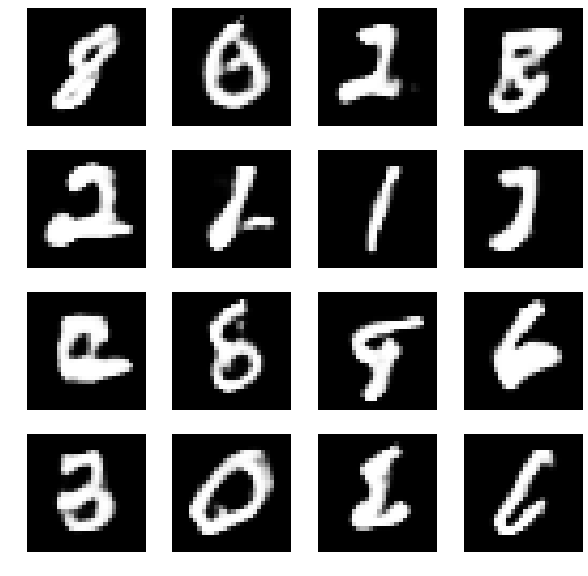

7600: [D loss:0.697511, acc:0.500000] [A loss:0.723692, acc:0.433594]
7601: [D loss:0.710604, acc:0.523438] [A loss:0.876700, acc:0.144531]
7602: [D loss:0.698521, acc:0.515625] [A loss:0.751035, acc:0.359375]
7603: [D loss:0.706697, acc:0.517578] [A loss:0.822817, acc:0.226562]
7604: [D loss:0.709692, acc:0.484375] [A loss:0.711143, acc:0.468750]
7605: [D loss:0.707605, acc:0.527344] [A loss:0.868740, acc:0.156250]
7606: [D loss:0.704169, acc:0.513672] [A loss:0.757635, acc:0.367188]
7607: [D loss:0.705136, acc:0.503906] [A loss:0.845056, acc:0.207031]
7608: [D loss:0.694941, acc:0.537109] [A loss:0.749539, acc:0.390625]
7609: [D loss:0.705322, acc:0.525391] [A loss:0.852289, acc:0.171875]
7610: [D loss:0.701234, acc:0.503906] [A loss:0.690186, acc:0.519531]
7611: [D loss:0.718280, acc:0.503906] [A loss:0.866969, acc:0.140625]
7612: [D loss:0.696542, acc:0.511719] [A loss:0.705076, acc:0.496094]
7613: [D loss:0.713229, acc:0.503906] [A loss:0.901153, acc:0.117188]
7614: [D loss:0.6955

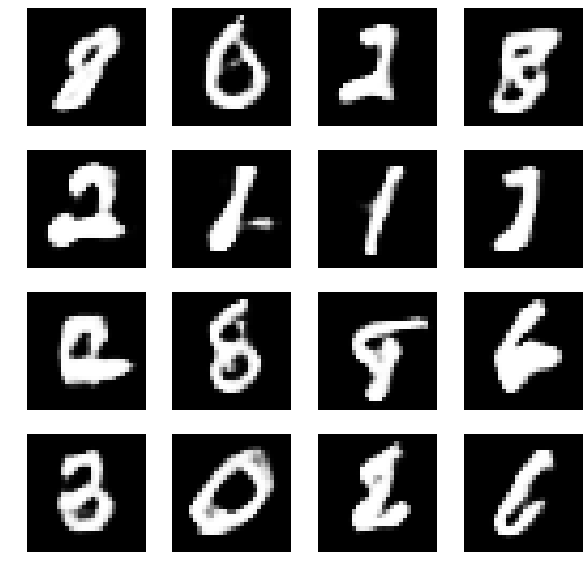

7700: [D loss:0.697657, acc:0.537109] [A loss:0.728686, acc:0.445312]
7701: [D loss:0.713859, acc:0.501953] [A loss:0.805620, acc:0.285156]
7702: [D loss:0.693279, acc:0.550781] [A loss:0.726293, acc:0.449219]
7703: [D loss:0.719521, acc:0.501953] [A loss:0.849537, acc:0.175781]
7704: [D loss:0.720017, acc:0.472656] [A loss:0.736350, acc:0.449219]
7705: [D loss:0.725968, acc:0.447266] [A loss:0.834498, acc:0.246094]
7706: [D loss:0.713982, acc:0.470703] [A loss:0.760168, acc:0.371094]
7707: [D loss:0.713484, acc:0.490234] [A loss:0.807637, acc:0.242188]
7708: [D loss:0.696673, acc:0.529297] [A loss:0.763972, acc:0.375000]
7709: [D loss:0.700116, acc:0.533203] [A loss:0.815387, acc:0.273438]
7710: [D loss:0.704508, acc:0.511719] [A loss:0.898747, acc:0.109375]
7711: [D loss:0.694510, acc:0.525391] [A loss:0.749620, acc:0.390625]
7712: [D loss:0.699281, acc:0.488281] [A loss:0.900010, acc:0.097656]
7713: [D loss:0.711978, acc:0.490234] [A loss:0.720119, acc:0.453125]
7714: [D loss:0.7207

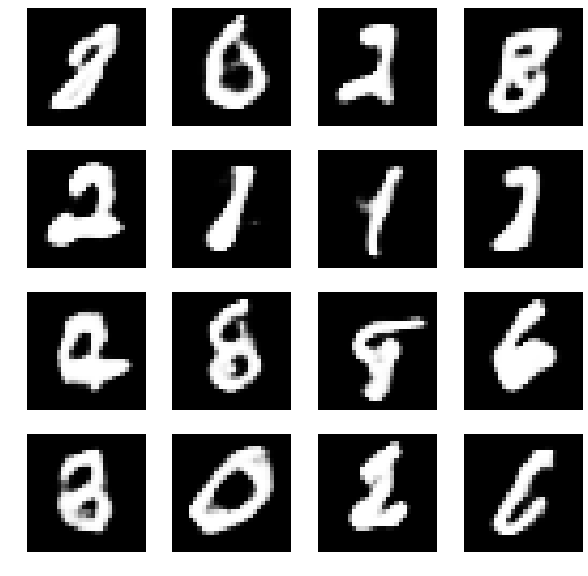

7800: [D loss:0.706145, acc:0.527344] [A loss:0.827996, acc:0.238281]
7801: [D loss:0.697201, acc:0.519531] [A loss:0.759600, acc:0.351562]
7802: [D loss:0.700381, acc:0.539062] [A loss:0.845396, acc:0.203125]
7803: [D loss:0.695223, acc:0.531250] [A loss:0.801613, acc:0.289062]
7804: [D loss:0.702273, acc:0.517578] [A loss:0.787364, acc:0.312500]
7805: [D loss:0.706897, acc:0.500000] [A loss:0.823443, acc:0.253906]
7806: [D loss:0.706516, acc:0.494141] [A loss:0.794035, acc:0.292969]
7807: [D loss:0.708154, acc:0.498047] [A loss:0.845229, acc:0.187500]
7808: [D loss:0.691958, acc:0.521484] [A loss:0.830659, acc:0.253906]
7809: [D loss:0.715404, acc:0.507812] [A loss:0.885414, acc:0.171875]
7810: [D loss:0.697972, acc:0.511719] [A loss:0.771588, acc:0.332031]
7811: [D loss:0.707447, acc:0.505859] [A loss:0.823846, acc:0.253906]
7812: [D loss:0.688040, acc:0.525391] [A loss:0.808304, acc:0.226562]
7813: [D loss:0.698447, acc:0.529297] [A loss:0.858082, acc:0.195312]
7814: [D loss:0.6959

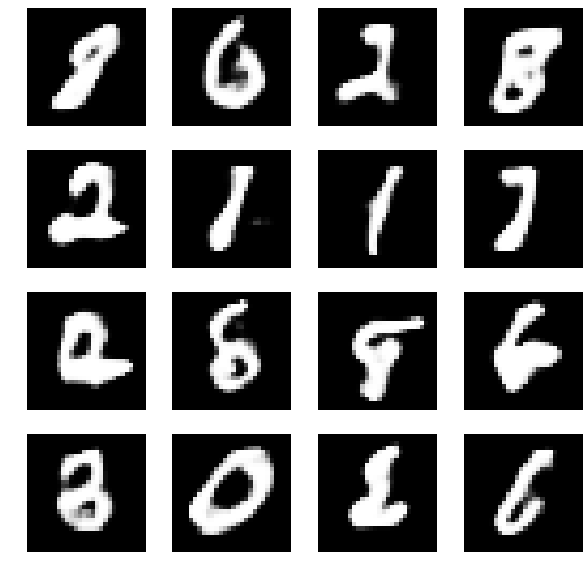

7900: [D loss:0.699417, acc:0.529297] [A loss:0.779438, acc:0.292969]
7901: [D loss:0.703497, acc:0.513672] [A loss:0.802136, acc:0.261719]
7902: [D loss:0.696797, acc:0.539062] [A loss:0.857180, acc:0.175781]
7903: [D loss:0.712301, acc:0.466797] [A loss:0.754544, acc:0.335938]
7904: [D loss:0.702810, acc:0.517578] [A loss:0.839837, acc:0.226562]
7905: [D loss:0.691786, acc:0.550781] [A loss:0.701262, acc:0.496094]
7906: [D loss:0.716797, acc:0.521484] [A loss:0.946171, acc:0.117188]
7907: [D loss:0.704088, acc:0.505859] [A loss:0.673126, acc:0.570312]
7908: [D loss:0.723207, acc:0.488281] [A loss:0.863066, acc:0.183594]
7909: [D loss:0.705373, acc:0.509766] [A loss:0.732769, acc:0.367188]
7910: [D loss:0.698047, acc:0.535156] [A loss:0.819403, acc:0.214844]
7911: [D loss:0.705227, acc:0.519531] [A loss:0.710787, acc:0.488281]
7912: [D loss:0.712052, acc:0.527344] [A loss:0.882998, acc:0.152344]
7913: [D loss:0.718404, acc:0.476562] [A loss:0.755787, acc:0.335938]
7914: [D loss:0.7091

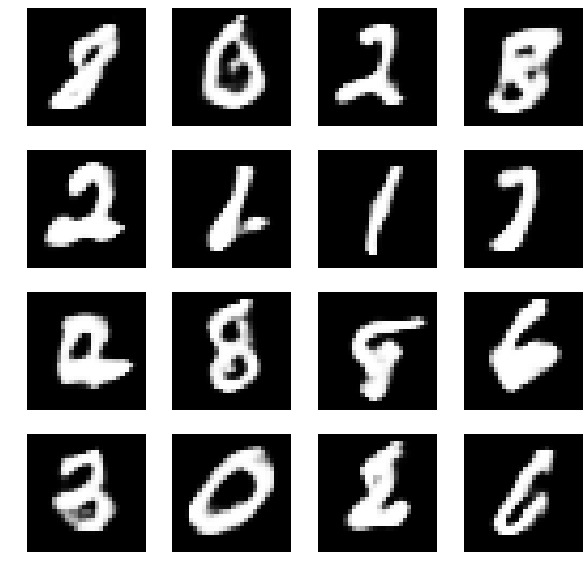

8000: [D loss:0.700435, acc:0.517578] [A loss:0.750333, acc:0.367188]
8001: [D loss:0.711738, acc:0.498047] [A loss:0.852373, acc:0.210938]
8002: [D loss:0.697756, acc:0.566406] [A loss:0.741408, acc:0.429688]
8003: [D loss:0.704300, acc:0.533203] [A loss:0.875594, acc:0.167969]
8004: [D loss:0.711467, acc:0.494141] [A loss:0.725363, acc:0.449219]
8005: [D loss:0.713757, acc:0.517578] [A loss:0.907544, acc:0.132812]
8006: [D loss:0.688858, acc:0.550781] [A loss:0.699355, acc:0.507812]
8007: [D loss:0.715522, acc:0.501953] [A loss:0.807753, acc:0.289062]
8008: [D loss:0.691156, acc:0.550781] [A loss:0.725153, acc:0.453125]
8009: [D loss:0.709539, acc:0.550781] [A loss:0.838769, acc:0.226562]
8010: [D loss:0.695006, acc:0.519531] [A loss:0.720272, acc:0.445312]
8011: [D loss:0.708805, acc:0.513672] [A loss:0.895173, acc:0.167969]
8012: [D loss:0.710022, acc:0.509766] [A loss:0.702602, acc:0.523438]
8013: [D loss:0.707920, acc:0.521484] [A loss:0.893982, acc:0.132812]
8014: [D loss:0.7117

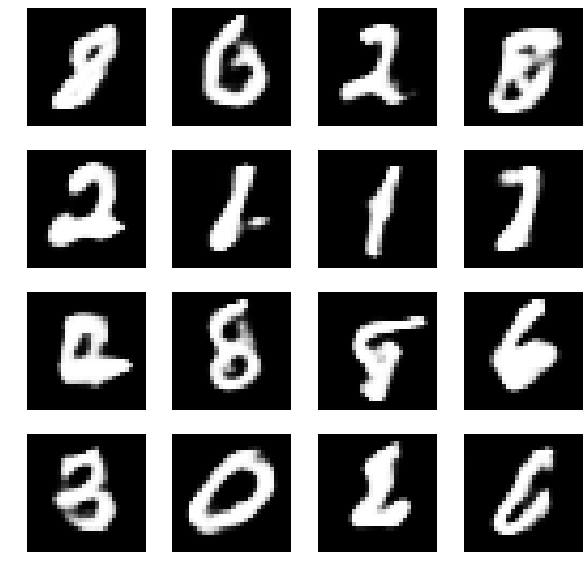

8100: [D loss:0.713513, acc:0.474609] [A loss:0.837828, acc:0.171875]
8101: [D loss:0.687955, acc:0.546875] [A loss:0.818651, acc:0.253906]
8102: [D loss:0.700034, acc:0.519531] [A loss:0.747086, acc:0.402344]
8103: [D loss:0.704308, acc:0.525391] [A loss:0.813400, acc:0.246094]
8104: [D loss:0.678121, acc:0.560547] [A loss:0.752221, acc:0.371094]
8105: [D loss:0.692613, acc:0.523438] [A loss:0.866601, acc:0.152344]
8106: [D loss:0.704285, acc:0.513672] [A loss:0.721426, acc:0.453125]
8107: [D loss:0.696186, acc:0.542969] [A loss:0.863430, acc:0.167969]
8108: [D loss:0.700668, acc:0.503906] [A loss:0.701347, acc:0.503906]
8109: [D loss:0.722631, acc:0.492188] [A loss:0.935096, acc:0.117188]
8110: [D loss:0.703218, acc:0.492188] [A loss:0.741775, acc:0.421875]
8111: [D loss:0.710012, acc:0.490234] [A loss:0.836547, acc:0.226562]
8112: [D loss:0.701129, acc:0.515625] [A loss:0.731583, acc:0.429688]
8113: [D loss:0.690792, acc:0.562500] [A loss:0.939228, acc:0.121094]
8114: [D loss:0.6870

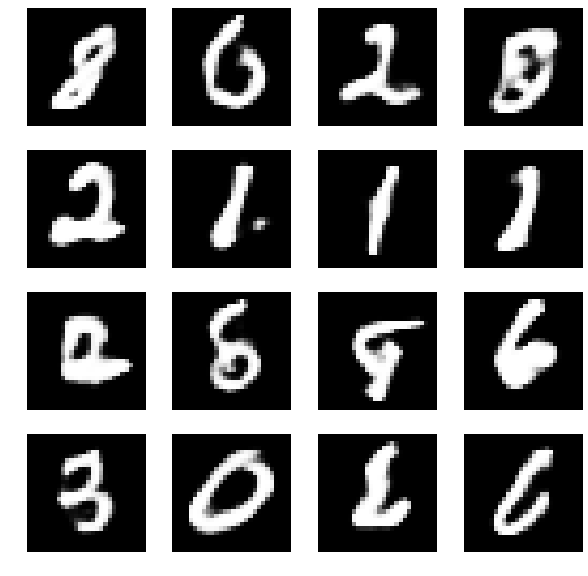

8200: [D loss:0.705918, acc:0.521484] [A loss:0.840600, acc:0.210938]
8201: [D loss:0.695301, acc:0.511719] [A loss:0.763228, acc:0.328125]
8202: [D loss:0.706804, acc:0.539062] [A loss:0.848562, acc:0.203125]
8203: [D loss:0.699296, acc:0.517578] [A loss:0.730090, acc:0.382812]
8204: [D loss:0.714321, acc:0.507812] [A loss:0.845243, acc:0.195312]
8205: [D loss:0.696083, acc:0.521484] [A loss:0.701791, acc:0.500000]
8206: [D loss:0.725811, acc:0.484375] [A loss:0.909532, acc:0.082031]
8207: [D loss:0.706708, acc:0.488281] [A loss:0.677410, acc:0.593750]
8208: [D loss:0.715714, acc:0.500000] [A loss:1.001702, acc:0.062500]
8209: [D loss:0.700884, acc:0.498047] [A loss:0.682928, acc:0.554688]
8210: [D loss:0.723070, acc:0.500000] [A loss:0.861269, acc:0.152344]
8211: [D loss:0.706485, acc:0.476562] [A loss:0.704361, acc:0.500000]
8212: [D loss:0.695039, acc:0.533203] [A loss:0.848923, acc:0.179688]
8213: [D loss:0.702049, acc:0.482422] [A loss:0.743423, acc:0.398438]
8214: [D loss:0.7064

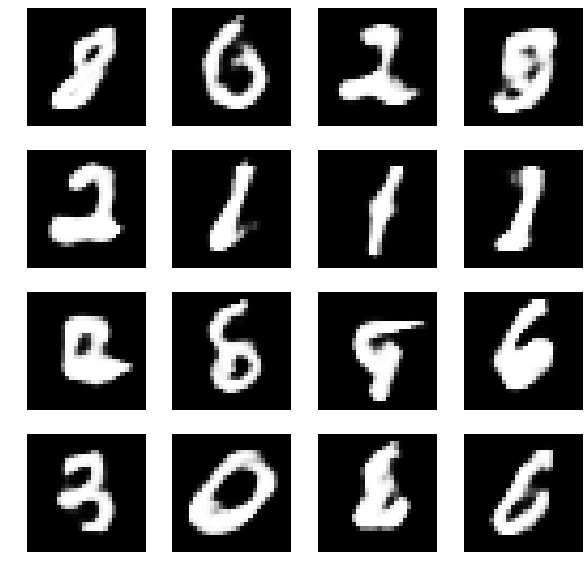

8300: [D loss:0.711681, acc:0.517578] [A loss:0.843318, acc:0.218750]
8301: [D loss:0.693908, acc:0.509766] [A loss:0.723179, acc:0.449219]
8302: [D loss:0.697693, acc:0.519531] [A loss:0.784989, acc:0.261719]
8303: [D loss:0.692955, acc:0.539062] [A loss:0.792527, acc:0.253906]
8304: [D loss:0.699184, acc:0.513672] [A loss:0.783972, acc:0.292969]
8305: [D loss:0.700233, acc:0.507812] [A loss:0.773432, acc:0.308594]
8306: [D loss:0.712217, acc:0.494141] [A loss:0.818093, acc:0.218750]
8307: [D loss:0.692408, acc:0.546875] [A loss:0.770316, acc:0.351562]
8308: [D loss:0.704204, acc:0.500000] [A loss:0.817925, acc:0.277344]
8309: [D loss:0.697194, acc:0.542969] [A loss:0.768975, acc:0.304688]
8310: [D loss:0.712381, acc:0.503906] [A loss:0.822076, acc:0.191406]
8311: [D loss:0.693110, acc:0.537109] [A loss:0.768820, acc:0.324219]
8312: [D loss:0.701539, acc:0.523438] [A loss:0.876229, acc:0.109375]
8313: [D loss:0.698176, acc:0.515625] [A loss:0.754051, acc:0.363281]
8314: [D loss:0.7056

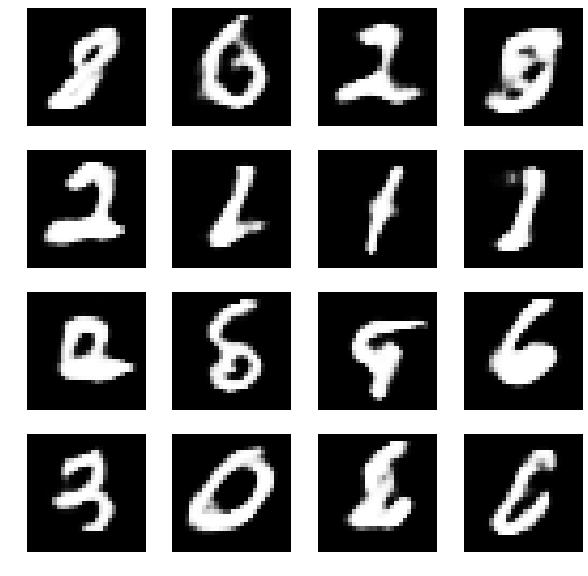

8400: [D loss:0.697702, acc:0.517578] [A loss:0.874488, acc:0.164062]
8401: [D loss:0.699161, acc:0.500000] [A loss:0.778836, acc:0.269531]
8402: [D loss:0.703754, acc:0.503906] [A loss:0.823543, acc:0.230469]
8403: [D loss:0.704989, acc:0.511719] [A loss:0.829173, acc:0.191406]
8404: [D loss:0.701905, acc:0.515625] [A loss:0.767469, acc:0.316406]
8405: [D loss:0.706792, acc:0.529297] [A loss:0.898931, acc:0.117188]
8406: [D loss:0.697904, acc:0.519531] [A loss:0.743589, acc:0.351562]
8407: [D loss:0.705034, acc:0.531250] [A loss:0.899330, acc:0.121094]
8408: [D loss:0.695891, acc:0.525391] [A loss:0.695994, acc:0.539062]
8409: [D loss:0.708524, acc:0.544922] [A loss:0.840865, acc:0.156250]
8410: [D loss:0.691729, acc:0.523438] [A loss:0.778814, acc:0.312500]
8411: [D loss:0.711067, acc:0.498047] [A loss:0.886474, acc:0.125000]
8412: [D loss:0.693591, acc:0.517578] [A loss:0.675252, acc:0.550781]
8413: [D loss:0.727904, acc:0.527344] [A loss:1.012740, acc:0.046875]
8414: [D loss:0.7114

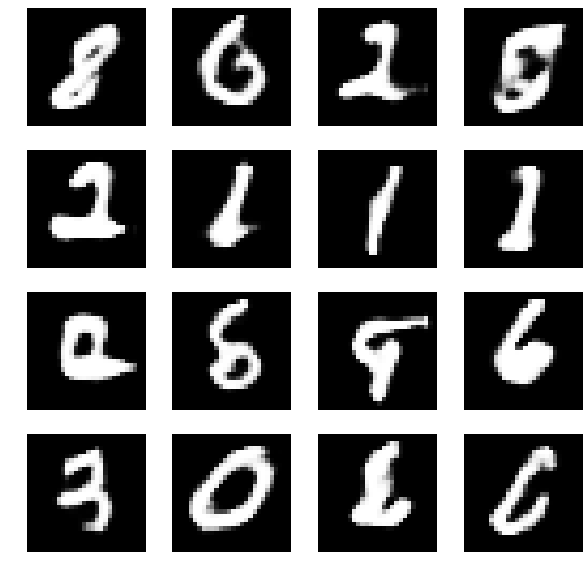

8500: [D loss:0.707425, acc:0.523438] [A loss:0.825219, acc:0.234375]
8501: [D loss:0.694827, acc:0.533203] [A loss:0.741700, acc:0.406250]
8502: [D loss:0.700908, acc:0.503906] [A loss:0.830222, acc:0.234375]
8503: [D loss:0.685317, acc:0.552734] [A loss:0.769014, acc:0.351562]
8504: [D loss:0.715622, acc:0.480469] [A loss:0.830404, acc:0.187500]
8505: [D loss:0.706272, acc:0.500000] [A loss:0.773474, acc:0.328125]
8506: [D loss:0.706796, acc:0.529297] [A loss:0.772494, acc:0.332031]
8507: [D loss:0.709856, acc:0.521484] [A loss:0.789376, acc:0.300781]
8508: [D loss:0.708569, acc:0.494141] [A loss:0.905483, acc:0.121094]
8509: [D loss:0.695089, acc:0.527344] [A loss:0.783642, acc:0.320312]
8510: [D loss:0.700458, acc:0.511719] [A loss:0.841107, acc:0.183594]
8511: [D loss:0.696837, acc:0.542969] [A loss:0.799707, acc:0.320312]
8512: [D loss:0.699911, acc:0.529297] [A loss:0.821566, acc:0.203125]
8513: [D loss:0.709215, acc:0.478516] [A loss:0.859573, acc:0.164062]
8514: [D loss:0.7003

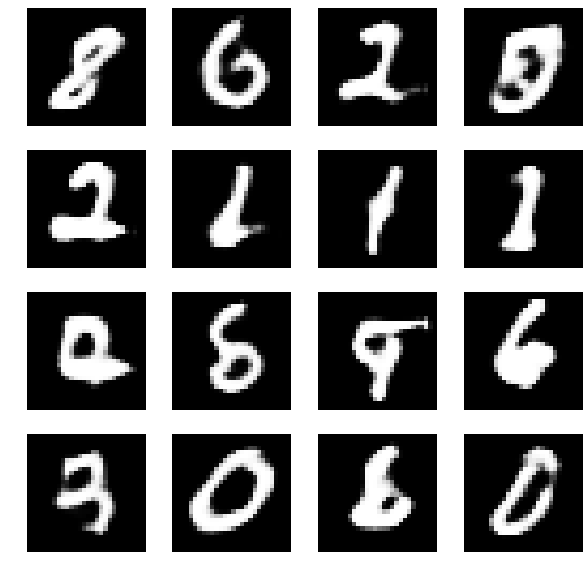

8600: [D loss:0.702183, acc:0.507812] [A loss:0.714358, acc:0.445312]
8601: [D loss:0.705417, acc:0.519531] [A loss:0.821578, acc:0.226562]
8602: [D loss:0.703535, acc:0.507812] [A loss:0.765095, acc:0.324219]
8603: [D loss:0.697828, acc:0.533203] [A loss:0.992142, acc:0.179688]
8604: [D loss:0.706768, acc:0.490234] [A loss:0.697879, acc:0.519531]
8605: [D loss:0.703279, acc:0.539062] [A loss:0.985619, acc:0.066406]
8606: [D loss:0.697754, acc:0.488281] [A loss:0.706653, acc:0.476562]
8607: [D loss:0.709441, acc:0.529297] [A loss:0.840295, acc:0.179688]
8608: [D loss:0.695699, acc:0.507812] [A loss:0.749758, acc:0.371094]
8609: [D loss:0.710134, acc:0.519531] [A loss:0.799061, acc:0.300781]
8610: [D loss:0.690180, acc:0.537109] [A loss:0.799376, acc:0.277344]
8611: [D loss:0.695504, acc:0.513672] [A loss:0.774093, acc:0.296875]
8612: [D loss:0.697356, acc:0.525391] [A loss:0.825690, acc:0.207031]
8613: [D loss:0.699488, acc:0.513672] [A loss:0.739815, acc:0.410156]
8614: [D loss:0.7015

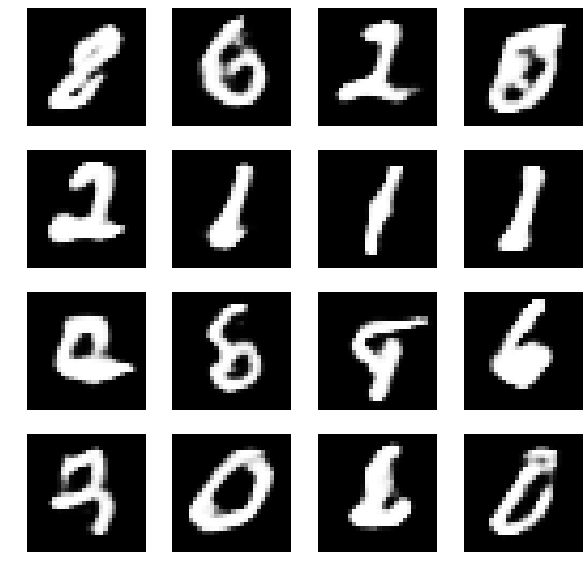

8700: [D loss:0.691845, acc:0.531250] [A loss:0.804838, acc:0.250000]
8701: [D loss:0.705090, acc:0.513672] [A loss:0.779246, acc:0.277344]
8702: [D loss:0.699905, acc:0.509766] [A loss:0.713156, acc:0.476562]
8703: [D loss:0.708816, acc:0.523438] [A loss:0.915258, acc:0.101562]
8704: [D loss:0.693460, acc:0.550781] [A loss:0.699866, acc:0.515625]
8705: [D loss:0.715657, acc:0.496094] [A loss:0.865660, acc:0.171875]
8706: [D loss:0.688878, acc:0.541016] [A loss:0.695346, acc:0.500000]
8707: [D loss:0.718500, acc:0.519531] [A loss:0.924749, acc:0.121094]
8708: [D loss:0.686106, acc:0.548828] [A loss:0.742180, acc:0.410156]
8709: [D loss:0.714918, acc:0.507812] [A loss:0.832254, acc:0.203125]
8710: [D loss:0.704891, acc:0.507812] [A loss:0.775461, acc:0.351562]
8711: [D loss:0.702332, acc:0.511719] [A loss:0.825896, acc:0.234375]
8712: [D loss:0.685495, acc:0.548828] [A loss:0.724725, acc:0.437500]
8713: [D loss:0.699697, acc:0.503906] [A loss:0.810232, acc:0.234375]
8714: [D loss:0.7017

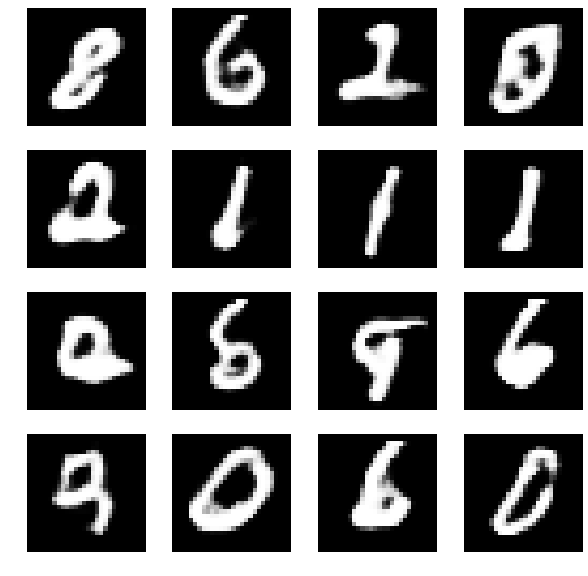

8800: [D loss:0.709991, acc:0.478516] [A loss:0.752340, acc:0.351562]
8801: [D loss:0.708039, acc:0.490234] [A loss:0.783095, acc:0.277344]
8802: [D loss:0.705278, acc:0.535156] [A loss:0.890828, acc:0.160156]
8803: [D loss:0.702290, acc:0.519531] [A loss:0.786516, acc:0.312500]
8804: [D loss:0.693818, acc:0.550781] [A loss:0.775620, acc:0.312500]
8805: [D loss:0.690719, acc:0.535156] [A loss:0.826099, acc:0.234375]
8806: [D loss:0.717944, acc:0.498047] [A loss:0.885397, acc:0.156250]
8807: [D loss:0.693129, acc:0.521484] [A loss:0.791753, acc:0.296875]
8808: [D loss:0.712118, acc:0.496094] [A loss:0.911559, acc:0.125000]
8809: [D loss:0.718960, acc:0.468750] [A loss:0.742081, acc:0.390625]
8810: [D loss:0.709071, acc:0.498047] [A loss:0.869959, acc:0.222656]
8811: [D loss:0.687481, acc:0.548828] [A loss:0.718232, acc:0.421875]
8812: [D loss:0.706816, acc:0.521484] [A loss:0.991747, acc:0.039062]
8813: [D loss:0.696901, acc:0.507812] [A loss:0.708929, acc:0.472656]
8814: [D loss:0.7136

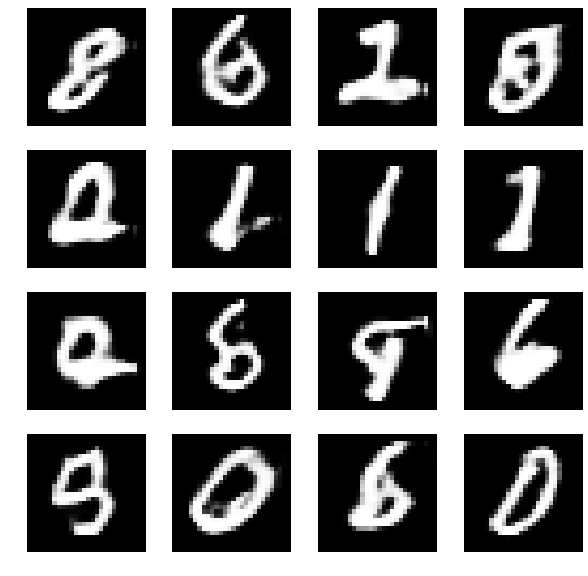

8900: [D loss:0.693080, acc:0.523438] [A loss:0.765342, acc:0.355469]
8901: [D loss:0.711304, acc:0.494141] [A loss:0.800476, acc:0.265625]
8902: [D loss:0.700820, acc:0.511719] [A loss:0.773473, acc:0.324219]
8903: [D loss:0.706983, acc:0.490234] [A loss:0.811962, acc:0.269531]
8904: [D loss:0.689283, acc:0.558594] [A loss:0.795414, acc:0.257812]
8905: [D loss:0.703571, acc:0.529297] [A loss:0.821374, acc:0.203125]
8906: [D loss:0.710533, acc:0.503906] [A loss:0.772438, acc:0.300781]
8907: [D loss:0.703404, acc:0.496094] [A loss:0.858603, acc:0.167969]
8908: [D loss:0.703459, acc:0.505859] [A loss:0.695134, acc:0.539062]
8909: [D loss:0.710873, acc:0.519531] [A loss:0.965809, acc:0.046875]
8910: [D loss:0.697498, acc:0.507812] [A loss:0.668800, acc:0.578125]
8911: [D loss:0.699621, acc:0.541016] [A loss:0.921619, acc:0.082031]
8912: [D loss:0.701212, acc:0.515625] [A loss:0.710297, acc:0.480469]
8913: [D loss:0.703334, acc:0.525391] [A loss:0.819547, acc:0.230469]
8914: [D loss:0.6959

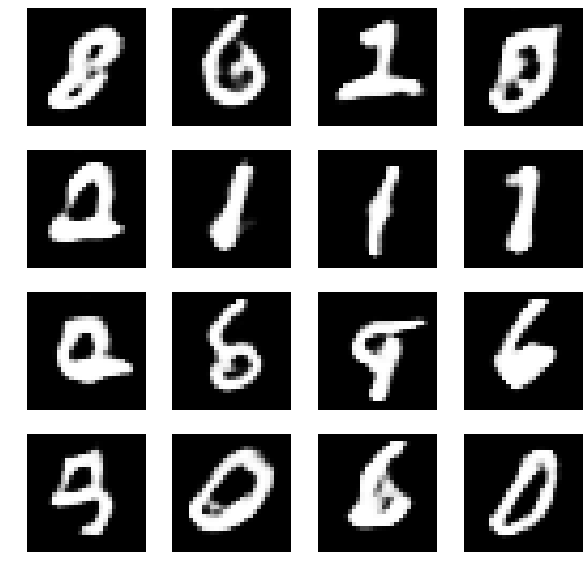

9000: [D loss:0.700748, acc:0.513672] [A loss:0.824949, acc:0.230469]
9001: [D loss:0.707419, acc:0.496094] [A loss:0.729459, acc:0.421875]
9002: [D loss:0.700539, acc:0.544922] [A loss:0.815445, acc:0.253906]
9003: [D loss:0.696809, acc:0.533203] [A loss:0.744102, acc:0.425781]
9004: [D loss:0.699996, acc:0.531250] [A loss:0.900993, acc:0.101562]
9005: [D loss:0.701019, acc:0.537109] [A loss:0.724410, acc:0.429688]
9006: [D loss:0.703692, acc:0.513672] [A loss:0.845841, acc:0.187500]
9007: [D loss:0.700387, acc:0.519531] [A loss:0.722441, acc:0.453125]
9008: [D loss:0.712805, acc:0.515625] [A loss:0.811792, acc:0.191406]
9009: [D loss:0.700239, acc:0.507812] [A loss:0.752002, acc:0.406250]
9010: [D loss:0.701119, acc:0.500000] [A loss:0.844966, acc:0.183594]
9011: [D loss:0.704920, acc:0.519531] [A loss:0.762052, acc:0.320312]
9012: [D loss:0.705824, acc:0.509766] [A loss:0.859287, acc:0.171875]
9013: [D loss:0.701224, acc:0.492188] [A loss:0.742248, acc:0.375000]
9014: [D loss:0.6965

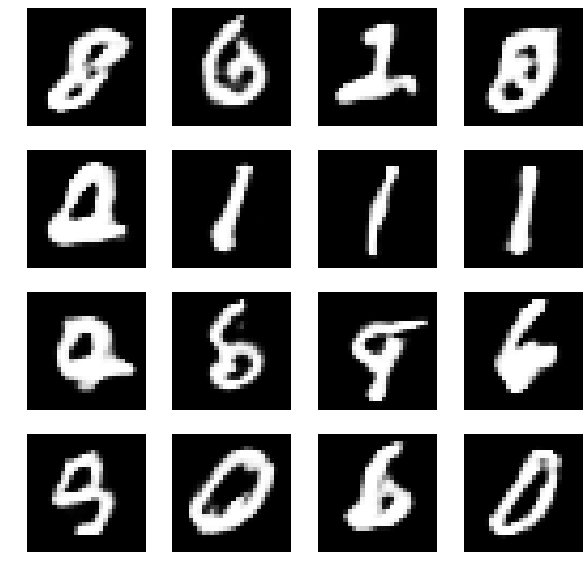

9100: [D loss:0.711937, acc:0.505859] [A loss:0.931554, acc:0.093750]
9101: [D loss:0.707847, acc:0.480469] [A loss:0.692889, acc:0.515625]
9102: [D loss:0.698630, acc:0.533203] [A loss:0.829051, acc:0.191406]
9103: [D loss:0.714454, acc:0.488281] [A loss:0.747165, acc:0.429688]
9104: [D loss:0.707308, acc:0.500000] [A loss:0.803238, acc:0.250000]
9105: [D loss:0.696720, acc:0.500000] [A loss:0.776017, acc:0.281250]
9106: [D loss:0.702083, acc:0.513672] [A loss:0.842248, acc:0.171875]
9107: [D loss:0.699019, acc:0.535156] [A loss:0.752753, acc:0.328125]
9108: [D loss:0.713288, acc:0.521484] [A loss:0.870119, acc:0.160156]
9109: [D loss:0.703265, acc:0.500000] [A loss:0.810981, acc:0.257812]
9110: [D loss:0.699234, acc:0.511719] [A loss:0.773288, acc:0.308594]
9111: [D loss:0.698928, acc:0.513672] [A loss:0.815847, acc:0.269531]
9112: [D loss:0.694487, acc:0.533203] [A loss:0.684038, acc:0.546875]
9113: [D loss:0.712912, acc:0.494141] [A loss:0.830221, acc:0.257812]
9114: [D loss:0.7017

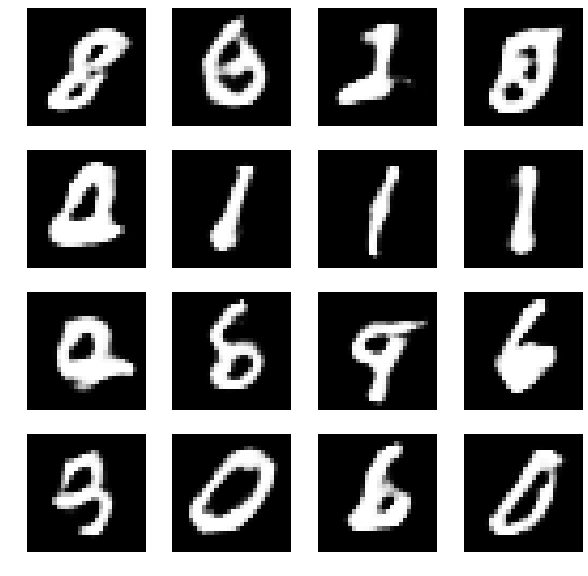

9200: [D loss:0.702547, acc:0.513672] [A loss:0.878195, acc:0.140625]
9201: [D loss:0.708838, acc:0.488281] [A loss:0.691679, acc:0.527344]
9202: [D loss:0.704659, acc:0.527344] [A loss:0.856267, acc:0.140625]
9203: [D loss:0.706709, acc:0.501953] [A loss:0.756300, acc:0.359375]
9204: [D loss:0.701484, acc:0.515625] [A loss:0.825843, acc:0.187500]
9205: [D loss:0.696886, acc:0.541016] [A loss:0.759699, acc:0.347656]
9206: [D loss:0.711065, acc:0.507812] [A loss:0.825647, acc:0.218750]
9207: [D loss:0.683756, acc:0.566406] [A loss:0.724893, acc:0.433594]
9208: [D loss:0.714127, acc:0.496094] [A loss:0.965835, acc:0.089844]
9209: [D loss:0.693816, acc:0.519531] [A loss:0.697714, acc:0.500000]
9210: [D loss:0.705391, acc:0.517578] [A loss:0.789382, acc:0.281250]
9211: [D loss:0.709917, acc:0.501953] [A loss:0.778435, acc:0.296875]
9212: [D loss:0.693636, acc:0.546875] [A loss:0.802376, acc:0.230469]
9213: [D loss:0.687824, acc:0.521484] [A loss:0.725287, acc:0.449219]
9214: [D loss:0.7180

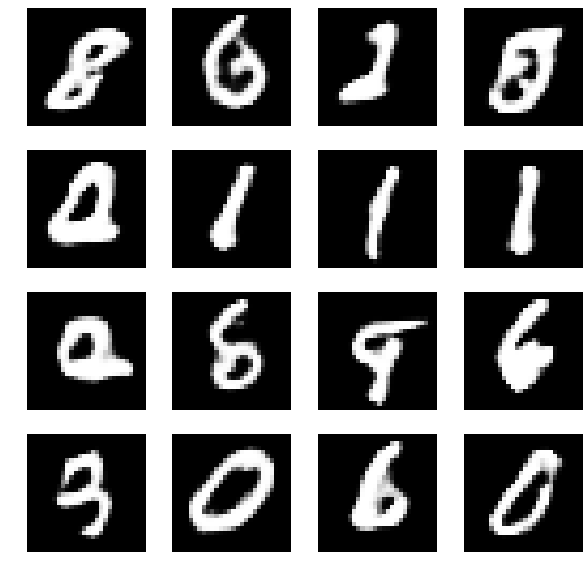

9300: [D loss:0.705902, acc:0.498047] [A loss:0.762618, acc:0.304688]
9301: [D loss:0.701184, acc:0.517578] [A loss:0.864194, acc:0.144531]
9302: [D loss:0.702697, acc:0.515625] [A loss:0.746717, acc:0.371094]
9303: [D loss:0.703543, acc:0.517578] [A loss:0.933093, acc:0.125000]
9304: [D loss:0.694519, acc:0.519531] [A loss:0.739972, acc:0.398438]
9305: [D loss:0.699928, acc:0.511719] [A loss:0.817090, acc:0.257812]
9306: [D loss:0.694594, acc:0.521484] [A loss:0.710280, acc:0.484375]
9307: [D loss:0.700043, acc:0.535156] [A loss:0.860922, acc:0.156250]
9308: [D loss:0.698677, acc:0.523438] [A loss:0.710792, acc:0.480469]
9309: [D loss:0.699141, acc:0.531250] [A loss:0.882966, acc:0.132812]
9310: [D loss:0.703654, acc:0.505859] [A loss:0.772725, acc:0.289062]
9311: [D loss:0.718710, acc:0.460938] [A loss:0.849460, acc:0.152344]
9312: [D loss:0.687621, acc:0.556641] [A loss:0.711306, acc:0.472656]
9313: [D loss:0.696442, acc:0.539062] [A loss:0.846465, acc:0.175781]
9314: [D loss:0.6972

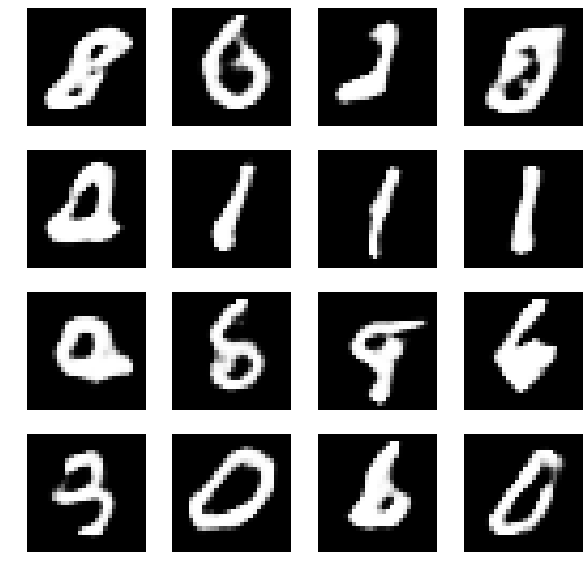

9400: [D loss:0.702860, acc:0.537109] [A loss:0.805690, acc:0.269531]
9401: [D loss:0.701219, acc:0.503906] [A loss:0.769340, acc:0.316406]
9402: [D loss:0.695616, acc:0.539062] [A loss:0.798555, acc:0.304688]
9403: [D loss:0.697726, acc:0.521484] [A loss:0.815201, acc:0.203125]
9404: [D loss:0.692803, acc:0.541016] [A loss:0.730655, acc:0.437500]
9405: [D loss:0.706378, acc:0.511719] [A loss:0.930642, acc:0.117188]
9406: [D loss:0.700268, acc:0.529297] [A loss:0.705696, acc:0.511719]
9407: [D loss:0.709723, acc:0.500000] [A loss:0.802591, acc:0.281250]
9408: [D loss:0.700018, acc:0.511719] [A loss:0.750908, acc:0.378906]
9409: [D loss:0.698210, acc:0.521484] [A loss:0.831587, acc:0.171875]
9410: [D loss:0.697279, acc:0.505859] [A loss:0.701693, acc:0.496094]
9411: [D loss:0.701702, acc:0.507812] [A loss:0.882428, acc:0.191406]
9412: [D loss:0.689103, acc:0.546875] [A loss:0.705341, acc:0.503906]
9413: [D loss:0.700566, acc:0.503906] [A loss:0.834725, acc:0.214844]
9414: [D loss:0.6862

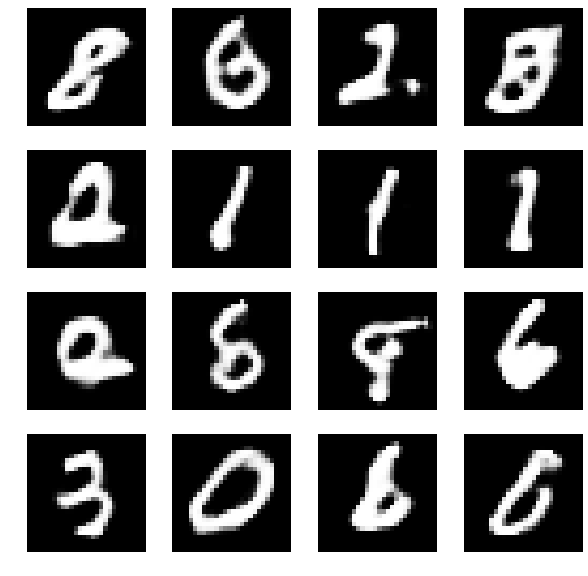

9500: [D loss:0.700242, acc:0.531250] [A loss:0.766773, acc:0.324219]
9501: [D loss:0.697461, acc:0.527344] [A loss:0.840865, acc:0.191406]
9502: [D loss:0.697603, acc:0.525391] [A loss:0.745990, acc:0.378906]
9503: [D loss:0.710552, acc:0.501953] [A loss:0.875246, acc:0.140625]
9504: [D loss:0.698644, acc:0.531250] [A loss:0.713723, acc:0.445312]
9505: [D loss:0.704632, acc:0.501953] [A loss:0.850489, acc:0.195312]
9506: [D loss:0.707269, acc:0.492188] [A loss:0.757139, acc:0.363281]
9507: [D loss:0.694158, acc:0.507812] [A loss:0.841009, acc:0.218750]
9508: [D loss:0.696977, acc:0.521484] [A loss:0.771771, acc:0.296875]
9509: [D loss:0.699204, acc:0.519531] [A loss:0.906088, acc:0.144531]
9510: [D loss:0.700101, acc:0.511719] [A loss:0.741806, acc:0.394531]
9511: [D loss:0.702371, acc:0.503906] [A loss:0.798683, acc:0.265625]
9512: [D loss:0.697141, acc:0.531250] [A loss:0.740966, acc:0.390625]
9513: [D loss:0.704829, acc:0.509766] [A loss:0.884213, acc:0.125000]
9514: [D loss:0.6886

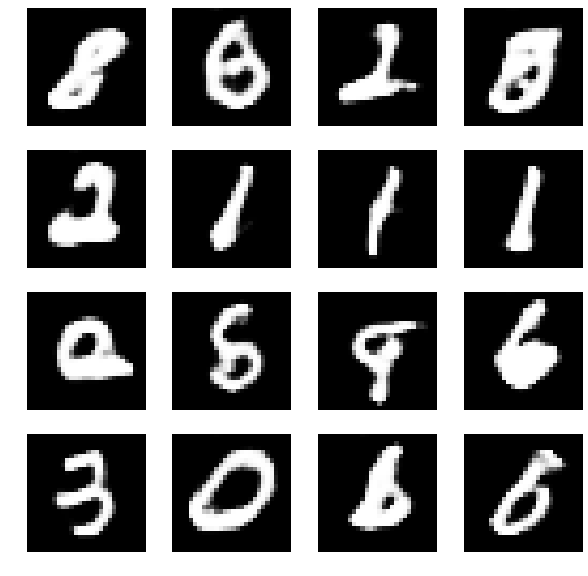

9600: [D loss:0.706868, acc:0.523438] [A loss:0.810702, acc:0.222656]
9601: [D loss:0.697061, acc:0.501953] [A loss:0.807435, acc:0.265625]
9602: [D loss:0.685396, acc:0.548828] [A loss:0.717919, acc:0.445312]
9603: [D loss:0.697659, acc:0.507812] [A loss:0.849539, acc:0.152344]
9604: [D loss:0.699590, acc:0.509766] [A loss:0.763600, acc:0.316406]
9605: [D loss:0.706630, acc:0.488281] [A loss:0.793863, acc:0.265625]
9606: [D loss:0.704076, acc:0.515625] [A loss:0.777194, acc:0.324219]
9607: [D loss:0.713568, acc:0.500000] [A loss:0.812207, acc:0.191406]
9608: [D loss:0.692342, acc:0.533203] [A loss:0.725388, acc:0.468750]
9609: [D loss:0.715556, acc:0.474609] [A loss:0.852994, acc:0.144531]
9610: [D loss:0.700791, acc:0.507812] [A loss:0.744876, acc:0.390625]
9611: [D loss:0.703502, acc:0.503906] [A loss:0.833219, acc:0.195312]
9612: [D loss:0.706057, acc:0.515625] [A loss:0.793823, acc:0.312500]
9613: [D loss:0.702823, acc:0.482422] [A loss:0.823062, acc:0.199219]
9614: [D loss:0.6901

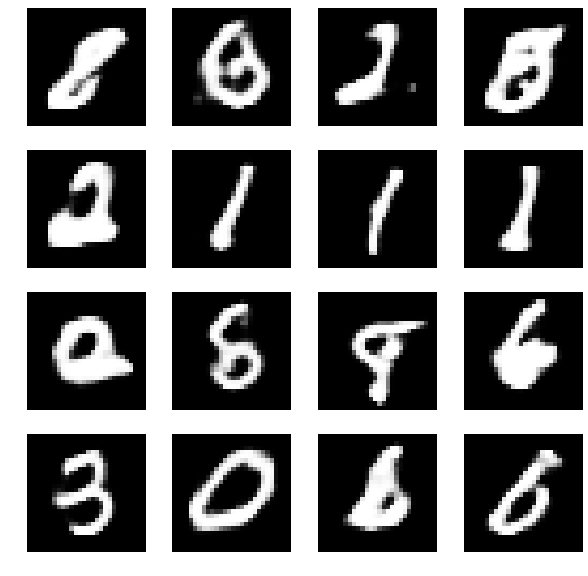

9700: [D loss:0.709164, acc:0.494141] [A loss:0.770196, acc:0.328125]
9701: [D loss:0.699354, acc:0.505859] [A loss:0.925589, acc:0.136719]
9702: [D loss:0.693881, acc:0.550781] [A loss:0.738286, acc:0.382812]
9703: [D loss:0.700346, acc:0.513672] [A loss:0.825555, acc:0.195312]
9704: [D loss:0.702870, acc:0.517578] [A loss:0.760067, acc:0.339844]
9705: [D loss:0.698249, acc:0.492188] [A loss:0.798606, acc:0.242188]
9706: [D loss:0.697690, acc:0.501953] [A loss:0.803314, acc:0.289062]
9707: [D loss:0.698210, acc:0.542969] [A loss:0.778290, acc:0.320312]
9708: [D loss:0.700389, acc:0.527344] [A loss:0.823353, acc:0.214844]
9709: [D loss:0.701292, acc:0.529297] [A loss:0.807441, acc:0.246094]
9710: [D loss:0.693694, acc:0.529297] [A loss:0.762973, acc:0.339844]
9711: [D loss:0.706296, acc:0.498047] [A loss:0.835425, acc:0.179688]
9712: [D loss:0.701315, acc:0.496094] [A loss:0.680501, acc:0.550781]
9713: [D loss:0.717324, acc:0.494141] [A loss:0.905450, acc:0.105469]
9714: [D loss:0.6966

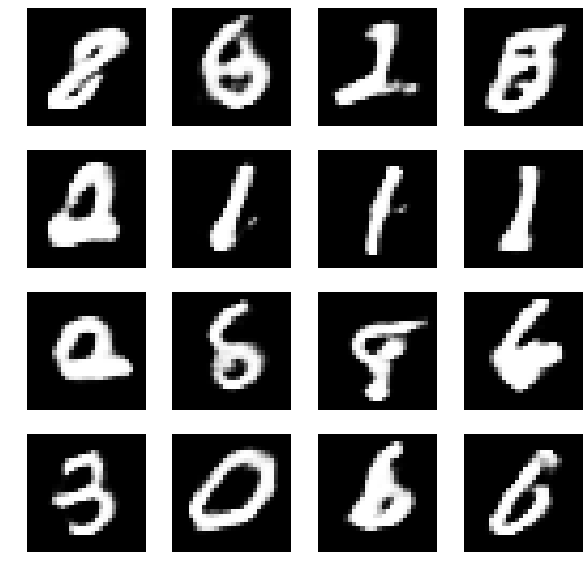

9800: [D loss:0.712591, acc:0.484375] [A loss:0.909706, acc:0.085938]
9801: [D loss:0.692795, acc:0.501953] [A loss:0.682856, acc:0.582031]
9802: [D loss:0.711194, acc:0.531250] [A loss:0.870550, acc:0.140625]
9803: [D loss:0.690925, acc:0.535156] [A loss:0.703533, acc:0.511719]
9804: [D loss:0.702615, acc:0.519531] [A loss:0.888263, acc:0.109375]
9805: [D loss:0.694991, acc:0.509766] [A loss:0.736317, acc:0.410156]
9806: [D loss:0.702845, acc:0.515625] [A loss:0.796393, acc:0.257812]
9807: [D loss:0.693813, acc:0.531250] [A loss:0.770118, acc:0.351562]
9808: [D loss:0.702793, acc:0.515625] [A loss:0.746835, acc:0.382812]
9809: [D loss:0.708874, acc:0.507812] [A loss:0.810826, acc:0.238281]
9810: [D loss:0.698907, acc:0.513672] [A loss:0.788854, acc:0.289062]
9811: [D loss:0.700645, acc:0.521484] [A loss:0.805021, acc:0.242188]
9812: [D loss:0.700475, acc:0.513672] [A loss:0.791939, acc:0.273438]
9813: [D loss:0.696795, acc:0.517578] [A loss:0.787204, acc:0.296875]
9814: [D loss:0.6981

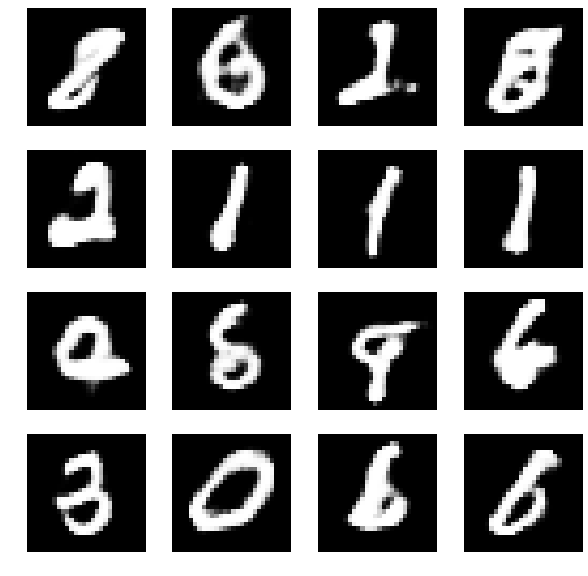

9900: [D loss:0.697209, acc:0.537109] [A loss:0.759568, acc:0.335938]
9901: [D loss:0.706125, acc:0.525391] [A loss:0.882432, acc:0.128906]
9902: [D loss:0.695129, acc:0.501953] [A loss:0.728989, acc:0.457031]
9903: [D loss:0.705869, acc:0.535156] [A loss:0.861787, acc:0.140625]
9904: [D loss:0.706705, acc:0.486328] [A loss:0.724509, acc:0.414062]
9905: [D loss:0.705828, acc:0.517578] [A loss:0.910746, acc:0.074219]
9906: [D loss:0.696151, acc:0.511719] [A loss:0.718189, acc:0.445312]
9907: [D loss:0.710300, acc:0.500000] [A loss:0.830378, acc:0.171875]
9908: [D loss:0.690630, acc:0.511719] [A loss:0.741079, acc:0.414062]
9909: [D loss:0.707021, acc:0.509766] [A loss:0.907252, acc:0.082031]
9910: [D loss:0.697851, acc:0.507812] [A loss:0.740071, acc:0.417969]
9911: [D loss:0.688376, acc:0.550781] [A loss:0.864115, acc:0.175781]
9912: [D loss:0.690198, acc:0.544922] [A loss:0.746525, acc:0.371094]
9913: [D loss:0.702903, acc:0.505859] [A loss:0.819287, acc:0.175781]
9914: [D loss:0.6864

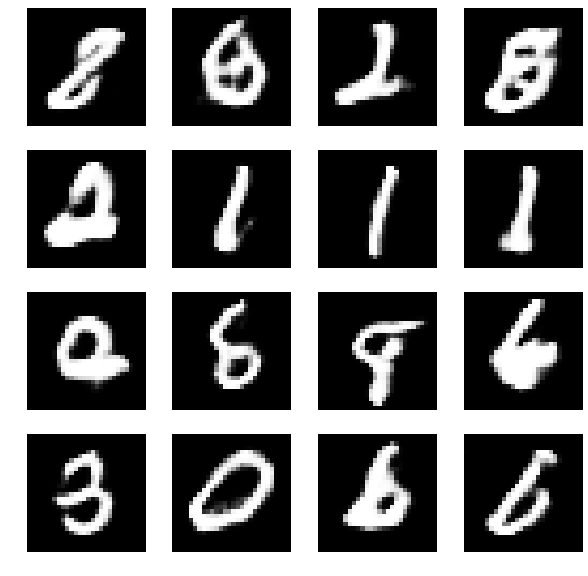

In [6]:
# 实例化网络的类
mnist_dcgan = MNIST_DCGAN()
# 训练模型
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=100)

##### 保存模型

In [0]:
mnist_dcgan.generator.save('generator_10000.h5')
mnist_dcgan.discriminator.save('discriminator_10000.h5')
mnist_dcgan.adversarial.save('adversarial_10000.h5')

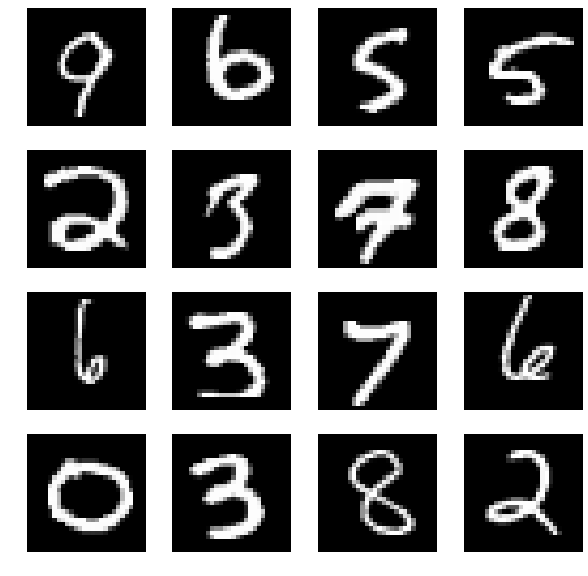

In [8]:
mnist_dcgan.plot_images(fake=False)

#####  总结
模型效果一般，训练10000次效果肯定是比初始情况好，但是还是不太理想。后续尝试方法：可增加迭代次数；尝试不同的优化器，这里使用的是RMSprop，也可以尝试不同的激活函数，这里使用的是relu；

##### 备注
本地位置：E:\python\ai_cv\chp8_cv_theory\03-图像风格转换和生成对抗网络\资料\图像风格转换和生成对抗网络\CLASSDATA_第八门_第四周图像风格转换和生成对抗网络\生成式对抗网络GAN  
colab位置：(1)/content/drive/My Drive/tensorflow_data/GAN_mnist  
模型文件位置：colab   
运行时间：5315.76秒  

